# "A method for determining the accuracy of formulas for calculation of crack wdith and spacing in reinforced concrete elements"

This file generates the working database, from the origional database "Crack width and crack spacing in reinforced and prestressed concrete elements: database". <br>

This is related to the paper "A method for determining the performance of formulas for calculating the crack width and spacing in reinforced concrete elements".

2025-08-04 <br>
(c) Anton van der Esch <br>
-antonvanderesch@hotmail.com or i.a.v.d.esch@tue.nl \

Please read the licence.

Sections: <br>
00 - Import packages <br>
01 - Settings <br>
02 - Import and prepare data <br>
03 - Set data types <br>
04 - Inspect various variables <br>
05 - Functions <br>
06 - Export database

## 00 - Import packages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import numpy.ma as ma

from pathlib import Path
import ast

from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

from sklearn.metrics import r2_score 

from contextlib import suppress

from scipy.stats import norm
from scipy.stats import lognorm
from sklearn.metrics import root_mean_squared_error

import time
import os

## 01 - Settings

In [3]:
Ncond = 15;
Nint = 100;
g = 9.81;
timecutoff = 100; # Transition from short to long term
Nrepcutoff = 2000; # Transition from static to repeated loading
chi = 0.8; # Aeging factor

importsigs = "no"; # Choice to import steel stress calculation from previous calculation --> save tremendous time
# Pas op! Als je Hordijk stress berekend, dan kan deze worden opgeslagen. Geldt dit ook voor staalspanningen die niet met Hordijk worden berekend?
importdat = "no";

exclude_secondary_cracks = "no";
uniformtargets = "yes";
hordijksigs = "no"; # In case yes, then the stress according to Hordijk is calculated
includeinitshrinkage = "no"; # Include initial shrinkage in the calculations

# no means: it is fully calculated
# yes means: it is not calculated but imported from a saved file
# Global constraints
globalfilterstress = "yes"; # Filters for the steel stress on the complete database!
sigslower = 150; # <-- eigenlijk vind ik dat dit 138 of 150 MPa moet zijn, komt ook overeen met ondergrens volgens Frosch?
sigsupper = 350;

filtercrackingplateau = "yes";

# Impute mean crack spacings based on known values?
targetimputation = "no";
Ncracksub = 4; # 4 means: imputation by 5 cracks or more (in case target imputation is switched on)

# Transform wm and sm to wmax and smax, respectively
# Constraints
soft_constraints = "no";
hard_constraints = "yes";

tol = 0.001;

fitleroutliers = "yes";
wmaxL = 0.05;
wmaxU = 0.5; # Cut-off limit mean and maximum crack width
smaxU = 400; # Cut-off limit mean and maximum crack spacing

ignorewarnings = "yes";

# Filter on the lengths
filter_length = 500; # Filter out considered lengths equal and smaller than .....

# Filter on a lower bound of the cylindrical compression strength
fcmlower = 5;

In [4]:
if ignorewarnings == "yes":

    import warnings
    warnings.filterwarnings('ignore');

In [5]:
# https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot

# 8, 10, 12
# 10, 12, 14

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## 02 - Import and prepare data

### 02.01 - Import data

In [6]:
motherpath = Path(r"C:\Users/20210065/OneDrive - TU Eindhoven/60_Publications/");
df = pd.read_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\New\Database\orgsize_expanded_features\df_master_sorted.csv"));

In [7]:
print(df.shape)
print("Number of tested elements",df['ELID'].nunique());

(6375, 79)
Number of tested elements 481


In [8]:
print("Number of elements loaded in tension",df[df["epsin"] == str("1a")]["ELID"].nunique());
print("Number of elements loaded in tension",df[df["epsin"] == str("1b")]["ELID"].nunique());
print("Number of elements loaded in bending",df[df["epsin"] == str("2")]["ELID"].nunique());
print("Number of elements with prestressing",df[(df["epsin"] == str("3")) & (df["Ap"] != 0)]["ELID"].nunique());
print("Number of elements with eccentric tension",df[(df["epsin"] == str("3")) & (df["Ap"] == 0)]["ELID"].nunique());

Number of elements loaded in tension 262
Number of elements loaded in tension 6
Number of elements loaded in bending 159
Number of elements with prestressing 54
Number of elements with eccentric tension 0


In [9]:
df.drop(df[(df["ELID"] == "A-FPhs/f1-5")].index, inplace=True); # Contains fibres in region outside constant bending moment
df.drop(df[(df["ELID"] == "A-PPhs/f1-5")].index, inplace=True); # Contains fibres in region outside constant bending moment
df.drop(df[(df["EPID"] == 8)].index, inplace=True); # Holmberg; no crack spacing available
df.drop(df[(df["EPID"] == 9)].index, inplace=True); # Bennet; too little info available for analysis
df.drop(df[(df["EPID"] == 22)].index, inplace=True); # Dawood; bi-axial loading
df.drop(df[(df["EPID"] == 26)].index, inplace=True); # Heuveln; light-weigth concrete

df.drop(df[(df["EPID"] == 31)].index, inplace=True); # Lisa; reinforcing ratio is very low

df.drop(df[(df["ELID"] == "1B1a")].index, inplace=True); # Contains excentric tension
df.drop(df[(df["ELID"] == "2B1a")].index, inplace=True); # Contains excentric tension
df.drop(df[(df["ELID"] == "3B1a")].index, inplace=True); # Contains excentric tension
df.drop(df[(df["ELID"] == "1C1a")].index, inplace=True); # Contains excentric tension
df.drop(df[(df["ELID"] == "3C1a")].index, inplace=True); # Contains excentric tension
# 5

# Contains likely measurement errors
df.drop(df[(df["ELID"] == "S1UND")].index, inplace=True);
# 6

# Contains likely measurement errors
df.drop(df[(df["ELID"] == "250-20-2")].index, inplace=True);
df.drop(df[(df["ELID"] == "250-20-3")].index, inplace=True);
df.drop(df[(df["ELID"] == "350-20-3")].index, inplace=True);
# 9

# Data files inconsistent with thesis
df.drop(df[(df["ELID"] == "350-10-1")].index, inplace=True);
df.drop(df[(df["ELID"] == "350-10-2")].index, inplace=True);
df.drop(df[(df["ELID"] == "350-10-3")].index, inplace=True);
# 12

# High-strength concrete
df.drop(df[(df["ELID"] == "H50-10-1")].index, inplace=True);
df.drop(df[(df["ELID"] == "H50-10-2")].index, inplace=True);
df.drop(df[(df["ELID"] == "H50-10-3")].index, inplace=True);
df.drop(df[(df["ELID"] == "H50-14-1")].index, inplace=True);
df.drop(df[(df["ELID"] == "H50-14-2")].index, inplace=True);
df.drop(df[(df["ELID"] == "H50-14-3")].index, inplace=True);
df.drop(df[(df["ELID"] == "H50-20-1")].index, inplace=True);
df.drop(df[(df["ELID"] == "H50-20-2")].index, inplace=True);
df.drop(df[(df["ELID"] == "H50-20-3")].index, inplace=True);
df.drop(df[(df["ELID"] == "H52-10-1")].index, inplace=True);
df.drop(df[(df["ELID"] == "H52-10-2")].index, inplace=True);
df.drop(df[(df["ELID"] == "H52-14-1")].index, inplace=True);
df.drop(df[(df["ELID"] == "H52-14-2")].index, inplace=True);
df.drop(df[(df["ELID"] == "H52-14-3")].index, inplace=True);
df.drop(df[(df["ELID"] == "H52-20-1")].index, inplace=True);
# 27

# Unrealistic values
df.drop(df[(df["ELID"] == "S20-10-1")].index, inplace=True);
df.drop(df[(df["ELID"] == "S20-10-2")].index, inplace=True);
df.drop(df[(df["ELID"] == "S22-10-1")].index, inplace=True);
df.drop(df[(df["ELID"] == "S22-10-2")].index, inplace=True);
df.drop(df[(df["ELID"] == "S22-10-3")].index, inplace=True);
df.drop(df[(df["ELID"] == "S30-10-1")].index, inplace=True);
df.drop(df[(df["ELID"] == "S30-10-2")].index, inplace=True);
df.drop(df[(df["ELID"] == "S30-10-3")].index, inplace=True);
df.drop(df[(df["ELID"] == "S32-10-1")].index, inplace=True);
df.drop(df[(df["ELID"] == "S32-10-2")].index, inplace=True);
# 38

# Unrealistic crack widths
df.drop(df[(df["ELID"] == "C210")].index, inplace=True);
# 39

"""
# Remove elements where fatigue was tested (repeated loading)
df.drop(df[(df["ELID"] == "PD2")].index, inplace=True);
df.drop(df[(df["ELID"] == "PP2D2")].index, inplace=True);
df.drop(df[(df["ELID"] == "PP1D2")].index, inplace=True);
df.drop(df[(df["ELID"] == "RD2")].index, inplace=True);
df.drop(df[(df["ELID"] == "PD1")].index, inplace=True);
df.drop(df[(df["ELID"] == "PD3")].index, inplace=True);
df.drop(df[(df["ELID"] == "PP2D1")].index, inplace=True);
df.drop(df[(df["ELID"] == "PP2D3")].index, inplace=True);
df.drop(df[(df["ELID"] == "PP1D1")].index, inplace=True);
df.drop(df[(df["ELID"] == "PP1D3")].index, inplace=True);
df.drop(df[(df["ELID"] == "RD1")].index, inplace=True);
df.drop(df[(df["ELID"] == "RD2")].index, inplace=True);
# 51
"""

# Unrealistic crack widths; possibly yielding
df.drop(df[(df["ELID"] == "1C2a")].index, inplace=True);
df.drop(df[(df["ELID"] == "3C2a")].index, inplace=True);
df.drop(df[(df["ELID"] == "3C2b")].index, inplace=True);
# 42

# Implicit calculation required to compute the section forces
df.drop(df[(df["ELID"] == "B8")].index, inplace=True);
df.drop(df[(df["ELID"] == "P7")].index, inplace=True);
df.drop(df[(df["ELID"] == "T16")].index, inplace=True);
# 45

# Unrealistic crack widths
df.drop(df[(df["ELID"] == "T-C3-1")].index, inplace=True);
df.drop(df[(df["ELID"] == "T-C3-2")].index, inplace=True);
df.drop(df[(df["ELID"] == "T-C3-4")].index, inplace=True);
# 48

# Unrealistic crack widths
df.drop(df[(df["ELID"] == "PL/201")].index, inplace=True);
# 49

# Secondary cracks + unrealistic crack widths
df.drop(df[(df["ELID"] == "T40")].index, inplace=True);
df.drop(df[(df["ELID"] == "T31")].index, inplace=True); # <-- Potentially OK
df.drop(df[(df["ELID"] == "T13")].index, inplace=True);
df.drop(df[(df["ELID"] == "T39")].index, inplace=True);
df.drop(df[(df["ELID"] == "T26")].index, inplace=True);
df.drop(df[(df["ELID"] == "T29")].index, inplace=True); # <-- Potentially OK
df.drop(df[(df["ELID"] == "T16")].index, inplace=True);
# 56

# Unrealistic crack widths and spacings
df.drop(df[(df["ELID"] == "R22")].index, inplace=True);
df.drop(df[(df["ELID"] == "R13")].index, inplace=True);
df.drop(df[(df["ELID"] == "R23")].index, inplace=True);
df.drop(df[(df["ELID"] == "R24")].index, inplace=True);
df.drop(df[(df["ELID"] == "R1")].index, inplace=True); # <-- Potentially OK
df.drop(df[(df["ELID"] == "R34")].index, inplace=True); # <-- Potentially OK
df.drop(df[(df["ELID"] == "R35")].index, inplace=True);
df.drop(df[(df["ELID"] == "R38")].index, inplace=True);
df.drop(df[(df["ELID"] == "R4")].index, inplace=True);
df.drop(df[(df["ELID"] == "R14")].index, inplace=True);
df.drop(df[(df["ELID"] == "R50")].index, inplace=True); # <-- Potentially OK
df.drop(df[(df["ELID"] == "R54")].index, inplace=True);
df.drop(df[(df["ELID"] == "R70")].index, inplace=True);
df.drop(df[(df["ELID"] == "R65")].index, inplace=True);
df.drop(df[(df["ELID"] == "R8")].index, inplace=True);
df.drop(df[(df["ELID"] == "R9")].index, inplace=True); # <-- Potentially OK
df.drop(df[(df["ELID"] == "R69")].index, inplace=True);
df.drop(df[(df["ELID"] == "R72")].index, inplace=True);
df.drop(df[(df["ELID"] == "R37")].index, inplace=True);
# 75

# Yielding of reinforcement
df.drop(df[(df["ELID"] == "2-32R2")].index, inplace=True);
df.drop(df[(df["ELID"] == "2-4.75R")].index, inplace=True); # Implicit calculation required to compute the section forces
df.drop(df[(df["ELID"] == "3-S3")].index, inplace=True); # Implicit calculation required to compute the section forces
df.drop(df[(df["ELID"] == "3-S4")].index, inplace=True); # Implicit calculation required to compute the section forces
# 79

In [10]:
df.drop_duplicates(inplace=True);

In [11]:
print("Dataset contains",df.shape[0], "rows")
print("Dataset contains",df.shape[1], "columns")

Dataset contains 4903 rows
Dataset contains 79 columns


In [12]:
df.rename(columns={"Unnamed: 0": "ID"},inplace=True);

In [13]:
df.reset_index(drop=True, inplace=True)

In [14]:
print("Number of tested elements",df['ELID'].nunique());

Number of tested elements 354


### 02.02 - Impute data

Estimate the values of $f_{p01k}$, which are unknown in some experimental programs, from $f_{\text{pk}}$.

#### EPID 14

$f_{\text{pk}}$ is known, $f_{\text{p}01\text{k}}$ is estimated using EN 10138: $f_{\text{p}01\text{k}} = 0.9 \cdot f_{\text{pk}}$

In [15]:
for i in range(df.shape[0]):
    if df["EPID"].iloc[i] == 14 and df["fpk"].iloc[i] > tol:
        df["fp01k"].iloc[i] = 0.9*df["fpk"].iloc[i];

#### EPID 17

$f_{\text{pk}}$ is known, $f_{\text{p}01\text{k}}$ is estimated using EN 10138: $f_{\text{p}01\text{k}} = 0.9 \cdot f_{\text{pk}}$

In [16]:
for i in range(df.shape[0]):
    if df["EPID"].iloc[i] == 17 and df["fpk"].iloc[i] > tol:
        df["fp01k"].iloc[i] = 0.9*df["fpk"].iloc[i];

#### Change target type of EPID28

Change, since characteristic crack widths $w_{\text{k}}$ will be considered as maximum crack widths $w_{\text{max}}$.

In [17]:
for i in range(df.shape[0]):
    if df["EPID"].iloc[i] == 28:
        if df["wk"].iloc[i] > tol:
            df["wmax"].iloc[i] = df["wk"].iloc[i];

for i in range(df.shape[0]):
    if df["EPID"].iloc[i] == 28:
        df["wk"].iloc[i] = 0;

#### Impute $cat_{\text{f}}$

In [18]:
for i in range(df.shape[0]):
    if df["EPID"].iloc[i] == 12:
        df["catf"].iloc[i] == 2;
    elif df["EPID"].iloc[i] == 22:
        df["catf"].iloc[i] == 2;

#### Inpute $f_{\text{pr}}$

In [19]:
for i in range(df.shape[0]):
    if df["EPID"].iloc[i] == 9:
        df["fpr"].iloc[i] == 1;
    elif df["EPID"].iloc[i] == 14:
        df["fpr"].iloc[i] == 1;
    elif df["EPID"].iloc[i] == 17:
        df["fpr"].iloc[i] == 1;

## 03 - Set DF types and extract additional data types

### 03.01 - Functions

Function to extract concrete properties from the imported database.

In [20]:
def func_extract_prop(data,var):

    Nrow = data.shape[0];
    hc = np.zeros((Nrow,Ncond));

    for i in range(Nrow):
        hctemp = ast.literal_eval(data[var].iloc[i]);
        Nhc = np.shape(hctemp)[0];
        
        for j in range(Nhc):
            hc[i,j] = float(hctemp[j]);

    return hc

Function to extract concrete properties from the variable $\text{cat}_{\text{fcm}}$.

In [21]:
def func_extract_catfcm(data):

    Nrowele = data.shape[0];
    
    col = ["Shape","Dim","Treat"];
    catfcm = pd.DataFrame(np.zeros((Nrowele,len(col))),columns=col);

    for i in range(data.shape[0]):
        for j in range(len(col)):
            catfcm[col[j]].iloc[i] = data["catfcm"].iloc[i].strip("[]").split(",")[j];

    fcm_shape = catfcm["Shape"].astype(int);
    fcm_dim = catfcm["Dim"].astype(str);
    fcm_treat = catfcm["Treat"].astype(int);

    return fcm_shape, fcm_dim, fcm_treat

Function to extract concrete properties from the variable $\text{cat}_{\text{fctm}}$.

In [22]:
def func_extract_catfctm(data):

    Nrowele = data.shape[0];
    
    col = ["Shape","Dim","Test"];
    catfctm = pd.DataFrame(np.zeros((Nrowele,len(col))),columns=col);

    for i in range(data.shape[0]):
        for j in range(len(col)):
            catfctm[col[j]].iloc[i] = data["catfctm"].iloc[i].strip("[]").split(",")[j];

    fctm_shape = catfctm["Shape"].astype(int);
    fctm_dim = catfctm["Dim"].astype(str);
    fctm_test = catfctm["Test"].astype(int);

    return fctm_shape, fctm_dim, fctm_test

Function to extract concrete properties from the variable $\text{cat}_{\text{Ecm}}$.

In [23]:
def func_extract_catEcm(data):

    Nrowele = data.shape[0];
    
    col = ["Shape","Dim","Test"];
    catEcm = pd.DataFrame(np.zeros((Nrowele,len(col))),columns=col);

    for i in range(data.shape[0]):
        for j in range(len(col)):
            catEcm[col[j]].iloc[i] = data["catEcm"].iloc[i].strip("[]").split(",")[j];

    Ecm_shape = catEcm["Shape"].astype(int);
    Ecm_dim = catEcm["Dim"].astype(str);
    Ecm_test = catEcm["Test"].astype(int);

    return Ecm_shape, Ecm_dim, Ecm_test

Function to extract concrete properties from the variable $\text{mix}$.

In [24]:
def func_extract_mix(data):
    
    Nrowele = data.shape[0];
    
    col = ["CEM","classCEM","cons","clinker","w/c","dmax","typeagg","add","rho"];
    mix = pd.DataFrame(np.zeros((Nrowele,len(col))),columns=col);
    
    for i in range(Nrowele):
        for j in range(len(col)):
            mix[col[j]].iloc[i] = data["mix"].iloc[i].strip("[]").split(",")[j];

    CEM = mix["CEM"].astype(int);
    classCEM = mix["classCEM"].astype(int);
    cons = mix["cons"].astype(int);
    clinker = mix["clinker"].astype(int);
    wc = mix["w/c"].astype(float);
    dmax = mix["dmax"].astype(float);
    typeagg = mix["typeagg"].astype(int);
    add = mix["add"].astype(str);
    rho = mix["rho"].astype(float);

    return CEM, classCEM, cons, clinker, wc, dmax, typeagg, add, rho

### 03.02 - Metadata

In [25]:
df = df.astype({
    "EPID": "int64",
    "ELID": "string",
    "LOADID": "int64",
    "DOI": "string",
    "title": "string",
    "year": "int64",
    "journal": "string",
    "country": "string",
    "institution": "string",
    "laboratory": "string",
    "authors": "string"
});

### 03.03 - Geometry

In [26]:
df = df.astype({
    "Ltot": "float",
    "Lspan": "float",
    "Lcons": "float",
    "Lmeas": "float",
    "h": "float",
    "b": "string"
});

### 03.04 - Element preparations

In [27]:
df = df.astype({
    "hc": "string",
    "thc": "string",
    "RH": "string",
    "Temp": "string",
    "pd": "int64",
});

In [28]:
hc = func_extract_prop(df,"hc");
thc = func_extract_prop(df,"thc");
RH = func_extract_prop(df,"RH");
Temp = func_extract_prop(df,"Temp");

### 03.05 - Concrete

In [29]:
df = df.astype({
    "fcm": "string",
    "catfcm": "string",
    "tfcm": "string",
    "fctm": "string",
    "catfctm": "string",
    "tfctm": "string",
    "Ecm": "string",
    "catEcm": "string",
    "tEcm": "string",
    "mix": "string",
});

In [30]:
fcm = func_extract_prop(df,"fcm");
tfcm = func_extract_prop(df,"tfcm");
fctm = func_extract_prop(df,"fctm");
tfctm = func_extract_prop(df,"tfctm");
Ecm = func_extract_prop(df,"Ecm");
tEcm = func_extract_prop(df,"tEcm");

fcm_shape, fcm_dim, fcm_treat = func_extract_catfcm(df);
fctm_shape, fctm_dim, fctm_test = func_extract_catfctm(df);
Ecm_shape, Ecm_dim, Ecm_test = func_extract_catEcm(df);

CEM, classCEM, cons, clinker, wc, dmax, typeagg, add, rho = func_extract_mix(df);

### 03.06 - Reinforcing steel - longitudinal direction

In [31]:
df = df.astype({
    "Es": "float",
    "fsr": "int64",
    "fy": "float",
    "phi": "string",
    "zs": "string",
    "nbl": "string",
    "clat": "string"
});

In [32]:
phi = func_extract_prop(df,"phi");
zs = func_extract_prop(df,"zs");
nbl = func_extract_prop(df,"nbl");
clat = func_extract_prop(df,"clat")

### 03.07 - Reinforcing steel - transverse direction

In [33]:
df = df.astype({
    "phit": "string",
    "st": "string"
});

In [34]:
phit = func_extract_prop(df,"phit");
st = func_extract_prop(df,"st");

### 03.08 - Reinforcing steel - stirrups

In [35]:
df = df.astype({
    "phiw": "float",
    "sw": "float"
});

### 03.09 - Prestressing steel

In [36]:
df = df.astype({
    "type": "string",
    "method": "int64",
    "fpk": "float",
    "fp01k": "float",
    "Ep": "float",
    "rel": "int64",
    "fpr": "int64",
    "npl": "string",
    "phip": "string",
    "Ap": "string",
    "zp": "string",
    "cplat": "string"
});

In [37]:
npl = func_extract_prop(df,"npl");
phip = func_extract_prop(df,"phip");
Ap = func_extract_prop(df,"Ap");
zp = func_extract_prop(df,"zp");
cplat = func_extract_prop(df,"cplat");

### 03.10 - Test setup

In [38]:
df = df.astype({
    "catf": "int64",
    "epsin": "string",
    "catcal": "int64",
    "selfw": "int64",
    "typew": "int64",
    "locw": "int64"  
});

### 03.11 - Loads

In [39]:
df = df.astype({
    "LOADID": "int64",
    "epsc": "float",
    "Nrep": "int64",
    "N": "float",
    "M": "float",
    "sigs": "float",
    "t0": "int64",
    "t": "int64",
    "PL": "float",
    "catp": "int64",
    "t0p": "int64",
    "tp": "int64",
});

### 03.12 - Datapoints

In [40]:
df = df.astype({
    "ncr": "int64",
    "wm": "float",
    "wk": "float",
    "wmax": "float",
    "sm": "float",
    "smax": "float",
});

## 04 - Inspect the various variables

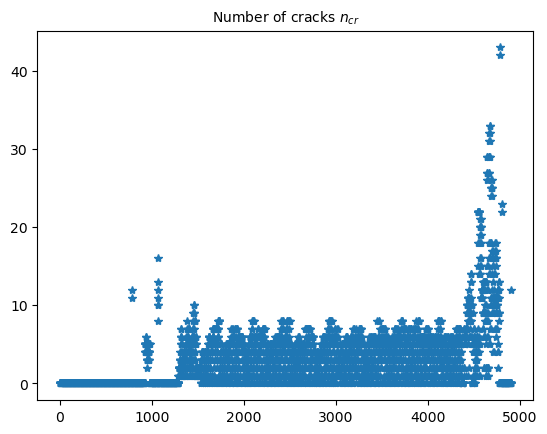

In [41]:
plt.figure();
plt.plot(df["ncr"],"*");
plt.title("Number of cracks $n_{cr}$");

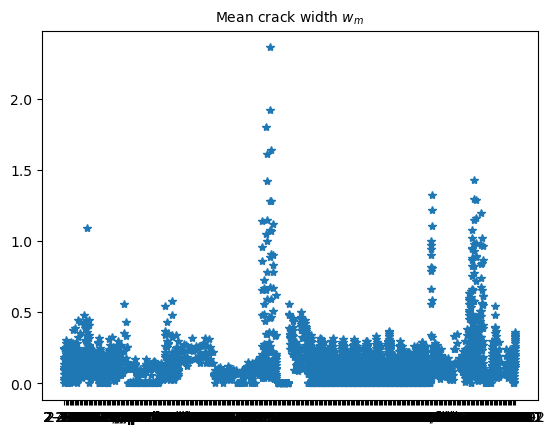

In [42]:
plt.figure();
plt.plot(df["ELID"],df["wm"],"*");
plt.title("Mean crack width $w_m$");

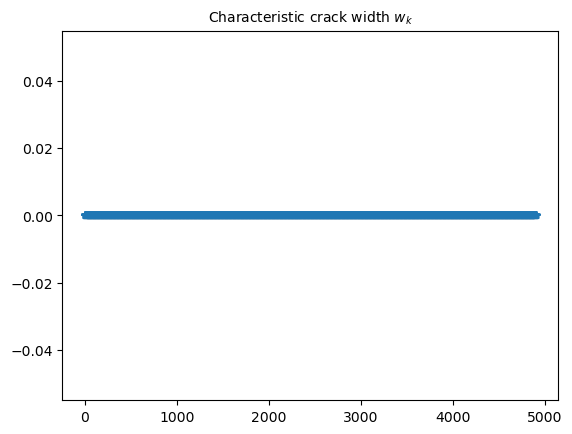

In [43]:
plt.figure();
plt.plot(df["wk"],"*");
plt.title("Characteristic crack width $w_k$");

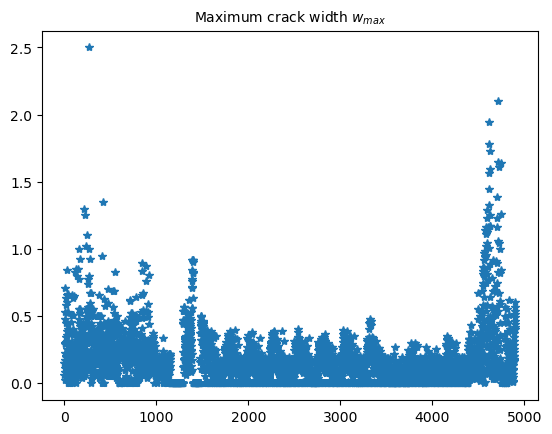

In [44]:
plt.figure();
plt.plot(df["wmax"],"*");
plt.title("Maximum crack width $w_{max}$");

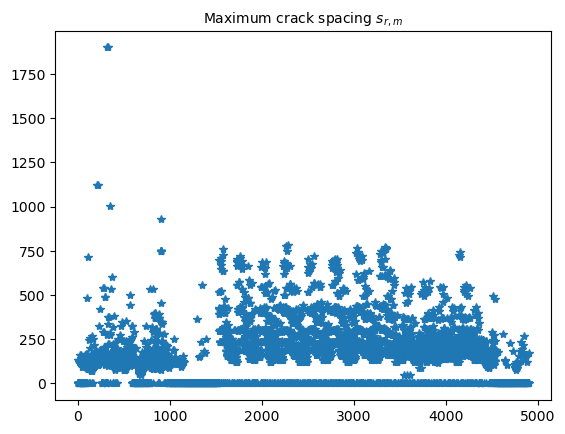

In [45]:
plt.figure();
plt.plot(df["sm"],"*");
plt.title("Maximum crack spacing $s_{r,m}$");

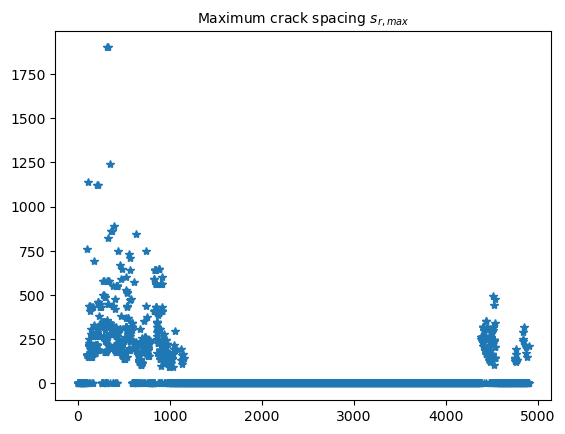

In [46]:
plt.figure();
plt.plot(df["smax"],"*");
plt.title("Maximum crack spacing $s_{r,max}$");

## 05 - Functions

### 05.02 - Nonzero layers

Function to inspect which elments in a array-type cell are empty. Returns last element that is not zero.

In [47]:
def func_cal_nonzero(data,var):
    nonzero = np.zeros(data.shape[0]);

    for i in range(data.shape[0]):
        nonzero[i] = int(np.where(var[i,:]<tol)[0][0]-1);
        
    return nonzero

In [48]:
df["indLR"] = func_cal_nonzero(df,zs);
df["indNP"] = func_cal_nonzero(df,zp);
df["indtfcm"] = func_cal_nonzero(df,tfcm);
df["indtfctm"] = func_cal_nonzero(df,tfctm);
df["indtEcm"] = func_cal_nonzero(df,tEcm);

df = df.astype({
    "indLR": "int",
    "indNP": "int",
    "indtfcm": "int",
    "indtfctm": "int",
    "indtEcm": "int"
});

### 05.03 - Functions to extract geometrical properties

#### Function to extract the section width of a string

In [49]:
def func_extract_width(z,bstr):

    # This function computes the widht of a cross-section, at a certain height
    bstr = str(bstr);
    tempstr = bstr.strip("[]");    
    nfunc = len(tempstr.split(","));
    
    # Create temparray to store different bounds, widths and heights
    if nfunc > 1:
        
        boundstore = np.zeros((2,nfunc)); # Lower resp. upper bound
        funcstore = [];
        
        for j in range(nfunc):
            boundstore[0,j] = float(tempstr.split(",")[j].split("if")[1].split("<z<")[0]);
            boundstore[1,j] = float(tempstr.split(",")[j].split("if")[1].split("<z<")[1]);
    
            def f(z):
                return float(eval(tempstr.split(",")[j].split("if")[0]));
            
            funcstore.append(f(z));
                    
        b = np.piecewise(
                        z,
                        [(z < boundstore[1,j]) & (z >= boundstore[0,j]) for j in range(nfunc)],funcstore);
  
    else:
        b = float(eval(bstr));

    return b

#### Function to determine if something is a beam or a slab

In [50]:
def func_slab_or_beam(data):

    # Determine if an element is a slab (yes/no)
    
    slab = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):
        if data["epsin"].iloc[i] == str("2"):
            if data["h"].iloc[i] <= 200:
                # Width evaluated at most compressed fibre; since otherwise, T-beams would be assigned as slabs
                if func_extract_width(tol,data["b"].iloc[i])/data["h"].iloc[i] >= 2:
                    slab[i] = 1; # It is a slab
        else:
            slab[i] = 0; # It is not a slab
    
    return slab

In [51]:
df["slab"] = func_slab_or_beam(df);
df = df.astype({
    "slab": "int64"
});

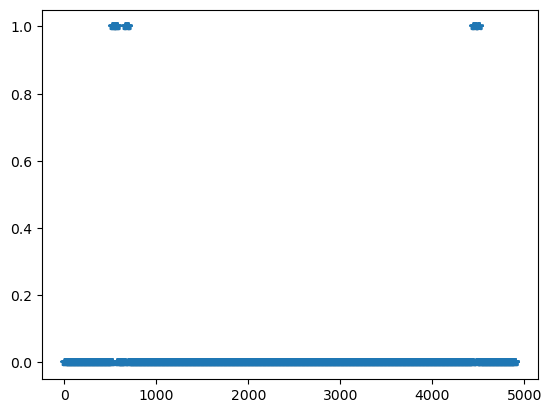

In [52]:
plt.plot(df["slab"],"*")

#### Function to calculate the concrete area (including reinforcing steel)

In [53]:
def func_cal_Ac(data):
   
    Ac = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):
        Ac[i] = quad(func_extract_width,0,data["h"].iloc[i],args=(data["b"].iloc[i]))[0];
    
    return Ac

In [54]:
df["Ac"] = func_cal_Ac(df);
df = df.astype({
    "Ac": "float"
});

#### Computation of total reinforcing steel

In [55]:
def func_cal_Astot(data):
    Astot = np.zeros(data.shape[0]);
    for i in range(data.shape[0]):
        Aslayer = np.zeros(Ncond);
        for j in range(Ncond):
            Aslayer[j] = nbl[i,j]*(1/4)*np.pi*(phi[i,j]**2);

        Astot[i] = sum(Aslayer);
        
    return Astot

In [56]:
df["Astot"] = func_cal_Astot(df);
df = df.astype({
    "Astot": "float"
});

### 05.04 - Functions to extract structural element preparations

#### Imputation of t0

$t_0$ is the age of the concrete when the structural element is loaded first.

In [57]:
def func_impute_t0(data,thc,tfcm):
    t0 = np.zeros(data.shape[0]);

    for i in range(data.shape[0]):
        
        if data["t0"].iloc[i] == 0: # Assume the time where loading starts; start of unloading is unknown
            if thc[i,0] > 0 and tfcm[i,0] == 0: # Address thc
                t0[i] = sum(thc[i,:]);
            elif thc[i,0] > 0 and tfcm[i,0] > 0: # Address tfcm
                t0[i] = max(tfcm[i,:]);  # Take the last value of the nonzero values
            else:
                t0[i] = 28;
        if data["t0"].iloc[i] > 0: # Start of loading is known
            t0[i] = data["t0"].iloc[i];
        
    return t0

In [58]:
df["t0"] = func_impute_t0(df,thc,tfcm);
df = df.astype({
    "t0": "int"
});

#### Imputation of t (duration of the loading)

In [59]:
def func_impute_t(data):
    t = np.zeros(data.shape[0]);

    for i in range(data.shape[0]):

        if data["t"].iloc[i] == 0:
            t[i] = 1; # Just impute a 1 --> this an assumption of the load duration, for unreported cases
        else:
            t[i] = data["t"].iloc[i];

    return t

In [60]:
df["t"] = func_impute_t(df);
df = df.astype({
    "t": "int"
});

#### Adjustment of RH

In [61]:
def func_determine_RH(rh):

    RH = np.zeros(rh.shape[0]);

    for i in range(rh.shape[0]):
        RHtemp = np.max(rh[i,:]);
        if RHtemp > 1:
            RH[i] = RHtemp;
        else:
            RH[i] = 65;

    return RH

In [62]:
df["RH"] = func_determine_RH(RH);
df = df.astype({
    "RH": "float"
});

#### Computation of $t_s$

$t_s$ is the age of the concrete at the beginning of drying in days. Assumption: in case hardening condition $hc$ equals 0 (unknown), 6 (elements stored inside test hall) or 8 (elements stored outside), then it is assumed that the hardening condition is contributing to the drying shrinkage.

In [63]:
def func_determine_ts(hc,data):
    ts = np.zeros(data.shape[0]);
    tstemp = np.zeros((data.shape[0],Ncond));

    indxtemp = np.zeros((data.shape[0],Ncond));
    for i in range(data.shape[0]):
        for j in range(Ncond):
            if int(hc[i,j]) not in [6,8,0]:
                indxtemp[i,j] = int(thc[i,j]);

        idx = np.where(indxtemp[i,:] == 0)[0][0];
        ts[i] = sum(indxtemp[i,0:idx]);
    
    return ts

In [64]:
df["ts"] = func_determine_ts(hc,df);
df = df.astype({
    "ts": "int"
});

### 05.05 - Functions to extract concrete properties

#### Diff fcm

In [65]:
diff_tfcm = np.zeros((df.shape[0],10));
for i in range(df.shape[0]):
    for j in range(df["indtfcm"].iloc[i]+1):
        diff_tfcm[i,j] = abs(df["t0"].iloc[i] + df["t"].iloc[i] - 1 - tfcm[i,j]);

#### Diff fctm

In [66]:
diff_tfctm = np.zeros((df.shape[0],10));
for i in range(df.shape[0]):
    for j in range(df["indtfctm"].iloc[i]+1):
        diff_tfctm[i,j] = abs(df["t0"].iloc[i] + df["t"].iloc[i] - 1 - tfctm[i,j]);

#### Diff Ecm

In [67]:
diff_tEcm = np.zeros((df.shape[0],10));
for i in range(df.shape[0]):
    for j in range(df["indtEcm"].iloc[i]+1):
        diff_tEcm[i,j] = abs(df["t0"].iloc[i] + df["t"].iloc[i] - 1 - tEcm[i,j]);

#### Estimation of the characteristic compression strength from the mean strength

Conversion is according to fib MC 2020.

In [68]:
def func_cal_fck(fcm):
    return fcm - 8;

#### Calculation of uniformly defined concrete compression strength, related to correct loading stage

Conversions according to HEFT 597.

In [69]:
def func_cal_fcm_unified(fcm):

    fcm_unified = np.zeros((fcm.shape[0],fcm.shape[1]));
    
    for i in range(fcm.shape[0]):
        
        if int(fcm_shape[i]) == 1: # Conversion to cylinder 150x300
            if float(fcm_dim[i].split("x")[0]) > 100-10 and float(fcm_dim[i].split("x")[0]) < 100+10:
                for j in range(fcm.shape[1]):
                    fcm_unified[i,j] = (0.92/0.95)*fcm[i,j];
            elif float(fcm_dim[i].split("x")[0]) > 150-15 and float(fcm_dim[i].split("x")[0]) < 150+15:
                for j in range(fcm.shape[1]):
                    fcm_unified[i,j] = 1*fcm[i,j];
            elif float(fcm_dim[i].split("x")[0]) > 70-7 and float(fcm_dim[i].split("x")[0]) < 70+7:
                for j in range(fcm.shape[1]):
                    fcm_unified[i,j] = (1/1.06)*fcm[i,j];
            else:
                for j in range(fcm.shape[1]):
                    fcm_unified[i,j] = fcm[i,j];

        elif int(fcm_shape[i]) == 2: # Conversion from cubes to cylinders 150x300
            if float(fcm_dim[i].split("x")[0]) > 200-20 and float(fcm_dim[i].split("x")[0]) < 200+20:
                for j in range(fcm.shape[1]):
                    fcm_unified[i,j] = 0.975*fcm[i,j]; # This factor converts directly to cylinder 150x300, the conversion from cube to cyl is incor.
            elif float(fcm_dim[i].split("x")[0]) > 100-10 and float(fcm_dim[i].split("x")[0]) < 100+10:
                for j in range(fcm.shape[1]):
                    if fcm[i,j] <= 72.5:
                        fcm_unified[i,j] = 0.745*fcm[i,j];
                    else:
                        fcm_unified[i,j] = 1.2*fcm[i,j]-32.4;
            elif float(fcm_dim[i].split("x")[0]) > 150-15 and float(fcm_dim[i].split("x")[0]) < 150+15:
                for j in range(fcm.shape[1]):
                    #fcm_unified[i,j] = 0.75*fcm[i,j];
                    if fcm[i,j] <= 65:
                        fcm_unified[i,j] = 0.83*fcm[i,j];
                    else:
                        fcm_unified[i,j] = 1.0*fcm[i,j] - 11.1;
            else:
                for j in range(fcm.shape[1]): # In case no dimensions of cubes are available1
                    fcm_unified[i,j] = fcm[i,j];

        else: # No correction, in case of missing values
            for j in range(fcm.shape[1]):
                fcm_unified[i,j] = fcm[i,j];
                
    return fcm_unified

In [70]:
fcm_unified = func_cal_fcm_unified(fcm);

#### Coefficient considering the strength development

$s_c$ is a coefficient depending on the strength development class of concrete. In case the strength development class is unknown, class $CN$ is assumed.

In [71]:
def func_cal_sc(data,fcm,CEM):
    sc = np.zeros(data.shape[0]);
    class_C = np.empty(data.shape[0],dtype="U256");
    for i in range(data.shape[0]):
        
        # Determination of sc; according to fib MC 2020, table 14.9-1
        # =============================

        fck = func_cal_fck(fcm[i,0]); # Call function func_cal_fck
        
        if CEM[i] == 1 or CEM[i] == 2:
            if classCEM[i] == 2 or classCEM[i] == 0: # address class SC = CN
                class_C[i] = "CN";
                if fck > 35 and fck < 60:
                    sc[i] = 0.4;
                elif fck < 35:
                    sc[i] = 0.5;
                elif fck > 60:
                    sc[i] = 0.3;
            elif classCEM[i] == 3: # address class SC = CR
                class_C[i] = "CR";
                if fck > 35 and fck < 60:
                    sc[i] = 0.2;
                elif fck < 35:
                    sc[i] = 0.3;
                elif fck > 60:
                    sc[i] = 0.1;
        elif CEM[i] == 3:
            class_C[i] = "CS";
            if fck > 35 and fck < 60:
                sc[i] = 0.6;
            elif fck < 35:
                sc[i] = 0.5;
            elif fck > 60:
                sc[i] = 0.4;
        else:
            class_C[i] = "CN";
            if fck > 35 and fck < 60:
                sc[i] = 0.4;
            elif fck < 35:
                sc[i] = 0.5;
            elif fck > 60:
                sc[i] = 0.3;
    
    return sc, class_C

In [72]:
df["sc"], df["class_C"] = func_cal_sc(df,fcm,CEM);
df = df.astype({
    "sc": "float",
    "class_C": "str"
});

#### Correction of the strength, based on the reference time

In [73]:
# For the correction in time, the reference time closest to the testing time (in absolute sense) is considered.

def func_correct_time(t0,t,sc,fcm,tfcm,exp):
   
    # Adjustment in time - concrete compression strength - determination testing structural element
    # =============================

    t28 = 28;
    t_ele_test = t0 + t - 1; # Time at testing
    t_mat_test_fcm = 0;

    if len(tfcm) > 1 and max(tfcm) > 0:
            arg = np.argmin(np.where(tfcm > 0,abs(tfcm-t28),1000)); # Temporarily substitutes 1000 in places of 0
            t_mat_test_fcm = tfcm[arg]; # Selection of the test
            fcm_not_adjusted = fcm[arg];
    else:
        fcm_not_adjusted = fcm[0]; # Because then no compression strength was tested

    if t_mat_test_fcm == 0 or t_ele_test == 0:
        Bcc = 1;
    else:
        Bcc = np.exp(sc*((1-(t_mat_test_fcm/t_ele_test)**0.5)) * (28/t_mat_test_fcm)**0.5);
    
    fcm_adj = ((Bcc)**(exp))*fcm_not_adjusted;
    
    # Adjustment in time - concrete compression strength - determination 28 day strength
    # =============================
    if len(tfcm) > 1 and max(tfcm) > 0:
            arg = np.argmin(np.where(tfcm > 0,abs(tfcm-t28),1000)); # Temporarily substitutes 1000 in places of 0
            t_mat_test_fcm = tfcm[arg]; # Selection of the test
            fcm_not_adjusted = fcm[arg];
    else:
        fcm_not_adjusted = fcm[0]; # Because then no compression strength was tested

    if t_mat_test_fcm == 0 or t_ele_test == 0:
        Bccadj = 1;
    else:
        Bccadj = np.exp(sc*((1-(t_mat_test_fcm/t28)**0.5)) * (28/t_mat_test_fcm)**0.5);

    fcm28 = ((Bccadj)**(exp))*fcm_not_adjusted;
    
    return fcm_adj, fcm28, Bcc
        
# Outputs: 28 day fcm unified strength, fcm strength at moment of testing structural element

In [74]:
fcm_uni = np.zeros(df.shape[0]);
fcm28_uni = np.zeros(df.shape[0]);
Bcc = np.zeros(df.shape[0]);

for i in range(df.shape[0]):
    fcm_uni[i], fcm28_uni[i], Bcc[i] = func_correct_time(df["t0"].iloc[i],df["t"].iloc[i],df["sc"].iloc[i],fcm_unified[i,:],tfcm[i,:],1); 

df["fcm"], df["fcm28"], df["Bcc"] = fcm_uni, fcm28_uni, Bcc;

df = df.astype({
    "fcm": "float",
    "fcm28": "float",
    "Bcc": "float"
});

In [75]:
df["fck28"] = func_cal_fck(df["fcm28"]);
df = df.astype({
    "fck28": "float"
});

#### Calculation of the cube compression strength (based on dimensions 150x150x150mm)

For the conversion, HEFT 597 is used.

In [76]:
def func_cal_fcm_cube_150(fcm):
    if fcm <= 54:
        fcm_cube_150 = fcm/0.83;
    else:
        fcm_cube_150 = fcm + 11.1;

    return fcm_cube_150

In [77]:
fcm_cube_150_temp = np.zeros(df.shape[0]);

for i in range(df.shape[0]):
    fcm_cube_150_temp[i] = func_cal_fcm_cube_150(df["fcm"].iloc[i]);

df["fcm_cube_150"] = fcm_cube_150_temp;
df = df.astype({
    "fcm_cube_150": "float"
});

#### Calculation of uniformly defined concrete tensile strength, related to correct loading stage

Estimation of the mean tensile strength, based on the mean compression strength.

In [78]:
def func_cal_fctm_from_fcm(fck28,fcm28):
  
    if fck28 < 50:
        fctm = 0.3*fck28**(2/3);
    else:
        fctm = 2.12 * np.log(1+fcm28/10);
    
    return fctm

In [79]:
# Requires input of 28 day splitting tensile strength
def func_cal_fctm_from_fctm_splitting(fctm_splitting):
    asp = 1;
    return asp*fctm_splitting

In [80]:
# Requires input of 28 day flexural tensile strength
def func_cal_fctm_from_fctmfl(fctmfl,h):
    arup = (1 + 0.06*(h**0.7))/(0.06*(h**0.7));
    fctm = fctmfl/arup;
    return fctm

In [81]:
# Requires input of 28 day tensile strength
def func_cal_fctmfl_from_fctm(fctm,h):
    arup = (1 + 0.06*(h**0.7))/(0.06*(h**0.7));
    fctmfl = fctm*arup;
    return fctmfl

In [82]:
def func_cal_fcteff_from_fctm(fctm):
    fcteff = 1.3*fctm
    return fcteff

In [83]:
def func_cal_fcteff_from_fctm_005(fctm):
    fcteff = 0.7*fctm
    return fcteff

In [84]:
# In case tensile stress was not determined using tests; the testing time was imputed
# In case of direct tensile test: this tensile stress was not used; however, testing time was employed when direct tensile test was performed

In [85]:
def func_cal_uniformly_fctm(data,fctm,tfctm,exp):

    fctm_unified_28 = np.zeros(data.shape[0]); # This is the 28th day tensile strength (uniformly defined)
    fctm_unified = np.zeros(data.shape[0]); # This is the unixial tensile strength, based on the testing time!

    fctmfl_unified_28 = np.zeros(data.shape[0]);
    fctmfl_unified = np.zeros(data.shape[0]);

    fct095_28 = np.zeros(data.shape[0]);
    fct095 = np.zeros(data.shape[0]);

    fct095_28_fl = np.zeros(data.shape[0]);
    fct095_fl = np.zeros(data.shape[0]);

    fct005_28 = np.zeros(data.shape[0]);
    fct005 = np.zeros(data.shape[0]);

    fct005_28_fl = np.zeros(data.shape[0]);
    fct005_fl = np.zeros(data.shape[0]);

    for i in range(data.shape[0]): # Loop through all the rows in the database

        # step 1: describe the tensile strength uniformly
        # ==========================
        t0 = data["t0"].iloc[i];
        t = data["t"].iloc[i];
        sc = data["sc"].iloc[i];
    
        t_ele_test = t0 + t - 1;
        
        if fctm[i,0] < tol: # First, address the cases where the tensile strength is unknown
            
            fctm_unified_28[i] = func_cal_fctm_from_fcm(data["fck28"].iloc[i],data["fcm28"].iloc[i]);  # Replace with the 28th day tensile strength
            fctmfl_unified_28[i] = func_cal_fctmfl_from_fctm(fctm_unified_28[i],data["h"].iloc[i]);
    
            fct095_28[i] = func_cal_fcteff_from_fctm(fctm_unified_28[i]);
            fct095_28_fl[i] = func_cal_fcteff_from_fctm(fctmfl_unified_28[i]);

            fct005_28[i] = func_cal_fcteff_from_fctm_005(fctm_unified_28[i]);
            fct005_28_fl[i] = func_cal_fcteff_from_fctm_005(fctmfl_unified_28[i]);
            
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fctm_unified_28[i];
    
            time_temp = np.zeros(Ncond);
            time_temp[0] = t_ele_test; # Impute testing time

            tfctm_temp = np.zeros(Ncond);
            tfctm_temp[0] = 28;
            
            #fctm_unified[i] = func_correct_time(t0,t,sc,fctm_temp,time_temp,exp)[0];
            fctm_unified[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm_temp,exp)[0];
    
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fctmfl_unified_28[i];
    
            time_temp = np.zeros(Ncond);
            time_temp[0] = t_ele_test; # Impute testing time

            tfctm_temp = np.zeros(Ncond);
            tfctm_temp[0] = 28;
            
            fctmfl_unified[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm_temp,exp)[0];
    
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fct095_28[i];
    
            time_temp = np.zeros(Ncond);
            #time_temp[0] = t_ele_test; # Impute testing time
            #time_temp[0] = t_ele_test; # Impute testing time

            tfctm_temp = np.zeros(Ncond);
            tfctm_temp[0] = 28;

            fct095[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm_temp,exp)[0];
            
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fct095_28_fl[i];
    
            time_temp = np.zeros(Ncond);
            time_temp[0] = t_ele_test; # Impute testing time

            tfctm_temp = np.zeros(Ncond);
            tfctm_temp[0] = 28;
    
            fct095_fl[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm_temp,exp)[0];

            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fct005_28[i];
    
            time_temp = np.zeros(Ncond);
            time_temp[0] = t_ele_test; # Impute testing time

            tfctm_temp = np.zeros(Ncond);
            tfctm_temp[0] = 28;
    
            fct005[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm_temp,exp)[0];

            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fct005_28_fl[i];
    
            time_temp = np.zeros(Ncond);
            time_temp[0] = t_ele_test; # Impute testing time
            
            tfctm_temp = np.zeros(Ncond);
            tfctm_temp[0] = 28;
    
            fct005_fl[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm_temp,exp)[0];
        
        elif fctm[i,0] > tol and fctm_test[i] == 1: # Tensile strength measured with direct tensile test --> unusuable
            
            fctm_unified_28[i] = func_cal_fctm_from_fcm(data["fck28"].iloc[i],data["fcm28"].iloc[i]);  # Replace with the 28th day tensile strength
            fctmfl_unified_28[i] = func_cal_fctmfl_from_fctm(fctm_unified_28[i],data["h"].iloc[i]);
    
            fct095_28[i] = func_cal_fcteff_from_fctm(fctm_unified_28[i]);
            fct095_28_fl[i] = func_cal_fcteff_from_fctm(fctmfl_unified_28[i]);

            fct005_28[i] = func_cal_fcteff_from_fctm_005(fctm_unified_28[i]);
            fct005_28_fl[i] = func_cal_fcteff_from_fctm_005(fctmfl_unified_28[i]);
            
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fctm_unified_28[i]; # Use testing time when the direct tensile test was performed
            tfctm_temp = np.zeros(Ncond);
            tfctm_temp[0] = 28;
            
            fctm_unified[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm_temp,exp)[0];
    
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fctmfl_unified_28[i]; # Use testing time when the direct tensile test was performed
            tfctm_temp = np.zeros(Ncond);
            tfctm_temp[0] = 28;
            
            fctmfl_unified[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm_temp,exp)[0];
    
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fct095_28[i];
    
            time_temp = np.zeros(Ncond);
            time_temp[0] = t_ele_test; # Impute testing time
            tfctm_temp = np.zeros(Ncond);
            tfctm_temp[0] = 28;
            
            fct095[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm_temp,exp)[0];
            
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fct095_28_fl[i];
    
            time_temp = np.zeros(Ncond);
            time_temp[0] = t_ele_test; # Impute testing time
            tfctm_temp = np.zeros(Ncond);
            tfctm_temp[0] = 28;
    
            fct095_fl[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm_temp,exp)[0];

            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fct005_28[i];
    
            time_temp = np.zeros(Ncond);
            time_temp[0] = t_ele_test; # Impute testing time
            tfctm_temp = np.zeros(Ncond);
            tfctm_temp[0] = 28;
    
            #fct005[i] = func_correct_time(t0,t,sc,fctm_temp,time_temp,exp)[0];
            fct005[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm_temp,exp)[0];
            
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fct005_28_fl[i];
    
            time_temp = np.zeros(Ncond);
            time_temp[0] = t_ele_test; # Impute testing time
            tfctm_temp = np.zeros(Ncond);
            tfctm_temp[0] = 28;
    
            fct005_fl[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm_temp,exp)[0];
        
        elif fctm[i,0] > 0.01 and fctm_test[i] == 2: # Address tensile splitting test
            
            fctm_temp = func_cal_fctm_from_fctm_splitting(fctm[i,:]); # Value of tensile strength at moment of testing
            
            # convert it to 28 day tensile testing
            fctm_unified_28[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm[i,:],exp)[1]; # Replace with the 28th day tensile strength
            fctmfl_unified_28[i] = func_cal_fctmfl_from_fctm(fctm_unified_28[i],data["h"].iloc[i]);
                  
            fct095_28[i] = func_cal_fcteff_from_fctm(fctm_unified_28[i]);
            fct095_28_fl[i] = func_cal_fcteff_from_fctm(fctmfl_unified_28[i]);

            fct005_28[i] = func_cal_fcteff_from_fctm_005(fctm_unified_28[i]);
            fct005_28_fl[i] = func_cal_fcteff_from_fctm_005(fctmfl_unified_28[i]);

            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fctm_unified_28[i];
            tfctm_temp = np.zeros(Ncond);
            tfctm_temp[0] = 28;
            
            #fctm_unified[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm[i,:],exp)[0]; # Value of tensile strength at moment of testing
            fctm_unified[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm_temp,exp)[0]; # Value of tensile strength at moment of testing
            
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fctmfl_unified_28[i]; # Use testing time when the direct tensile test was performed
            tfctm_temp = np.zeros(Ncond);
            tfctm_temp[0] = 28;
            
            fctmfl_unified[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm_temp,exp)[0]; 
    
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fct095_28[i]; 
            tfctm_temp = np.zeros(Ncond);
            tfctm_temp[0] = 28;
            
            fct095[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm_temp,exp)[0]; 
    
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fct095_28_fl[i]; 
            tfctm_temp = np.zeros(Ncond);
            tfctm_temp[0] = 28;
    
            fct095_fl[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm_temp,exp)[0]; 

            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fct005_28[i];
            tfctm_temp = np.zeros(Ncond);
            tfctm_temp[0] = 28;

            #print("t0",t0)
            #print(,"t",t)

            fct005[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm_temp,exp)[0];
            #fct005[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm[i,:],exp)[0];

            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fct005_28_fl[i];
            tfctm_temp = np.zeros(Ncond);
            tfctm_temp[0] = 28;

            fct005_fl[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm_temp,exp)[0];
        
        elif fctm[i,0] > tol and fctm_test[i] == 3: # Address flexural tensile strength
            
            fctm_temp = func_correct_time(t0,t,sc,fctm[i,:],tfctm[i,:],exp)[1]; # Replace with the 28th day tensile strength
            fctm_unified_28[i] = func_cal_fctm_from_fctmfl(fctm_temp,data["h"].iloc[i]); # Replace with the 28th day tensile strength
            fctmfl_unified_28[i] = fctm_temp;
            fct095_28[i] = func_cal_fcteff_from_fctm(fctm_unified_28[i]);
            fct095_28_fl[i] = func_cal_fcteff_from_fctm(fctmfl_unified_28[i]);

            fct005_28[i] = func_cal_fcteff_from_fctm_005(fctm_unified_28[i]);
            fct005_28_fl[i] = func_cal_fcteff_from_fctm_005(fctmfl_unified_28[i]);
            
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fctm_unified_28[i];
    
            time_temp = np.zeros(Ncond);
            time_temp[0] = t_ele_test; # Impute testing time (at first element in the array)

            tfctm_temp = np.zeros(Ncond);
            tfctm_temp[0] = 28;
            
            fctm_unified[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm_temp,exp)[0]; # Value of tensile strength at moment of testing
    
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fctmfl_unified_28[i];
    
            time_temp = np.zeros(Ncond);
            time_temp[0] = t_ele_test; # Impute testing time (at first element in the array)
            tfctm_temp = np.zeros(Ncond);
            tfctm_temp[0] = 28;
            
            fctmfl_unified[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm_temp,exp)[0]; 
    
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fct095_28[i];
    
            time_temp = np.zeros(Ncond);
            time_temp[0] = t_ele_test; # Impute testing time (at first element in the array)

            tfctm_temp = np.zeros(Ncond);
            tfctm_temp[0] = 28;
            
            fct095[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm_temp,exp)[0]; 
    
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fct095_28_fl[i];
    
            time_temp = np.zeros(Ncond);
            time_temp[0] = t_ele_test; # Impute testing time (at first element in the array)

            tfctm_temp = np.zeros(Ncond);
            tfctm_temp[0] = 28;
            
            fct095_fl[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm_temp,exp)[0]; 

            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fct005_28[i];

            time_temp = np.zeros(Ncond);
            time_temp[0] = t_ele_test; # Impute testing time (at the first element in the array)

            tfctm_temp = np.zeros(Ncond);
            tfctm_temp[0] = 28;
            
            fct005[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm_temp,exp)[0];

            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fct005_28_fl[i];

            time_temp = np.zeros(Ncond);
            time_temp[0] = t_ele_test; # Impute testing time (at the first element in the array)
            tfctm_temp = np.zeros(Ncond);
            tfctm_temp[0] = 28;
            
            fct005_fl[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm_temp,exp)[0];
        
        elif fctm[i,0] > tol and fctm_test[i] == 0: # Address case were testing method was unknown, but it was tested --> assume splitting tensile test
            fctm_unified_28[i] = func_correct_time(t0,t,sc,fctm[i,:],tfctm[i,:],exp)[1]; # Replace with the 28th day tensile strength
            fctmfl_unified_28[i] = func_cal_fctmfl_from_fctm(fctm_unified_28[i],data["h"].iloc[i]);
            fct095_28[i] = func_cal_fcteff_from_fctm(fctm_unified_28[i]);
            fct095_28_fl[i] = func_cal_fcteff_from_fctm(fctmfl_unified_28[i]);

            fct005_28[i] = func_cal_fcteff_from_fctm_005(fctm_unified_28[i]);
            fct005_28_fl[i] = func_cal_fcteff_from_fctm_005(fctmfl_unified_28[i]);
            
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fctm_unified_28[i];
    
            time_temp = np.zeros(Ncond);
            time_temp[0] = t_ele_test; # Impute testing time (at first element in the array)
            tfctm_temp = np.zeros(Ncond);
            tfctm_temp[0] = 28;
            
            fctm_unified[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm_temp,exp)[0]; # Value of tensile strength at moment of testing
    
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fctmfl_unified_28[i];
    
            time_temp = np.zeros(Ncond);
            time_temp[0] = t_ele_test; # Impute testing time (at first element in the array)
            tfctm_temp = np.zeros(Ncond);
            tfctm_temp[0] = 28;
    
            fctmfl_unified[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm_temp,exp)[0];
    
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fct095_28[i];
    
            time_temp = np.zeros(Ncond);
            time_temp[0] = t_ele_test; # Impute testing time (at first element in the array)
            tfctm_temp = np.zeros(Ncond);
            tfctm_temp[0] = 28;
            
            fct095[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm_temp,exp)[0];
            
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fct095_28_fl[i];
            
            time_temp = np.zeros(Ncond);
            time_temp[0] = t_ele_test; # Impute testing time (at first element in the array)
            
            tfctm_temp = np.zeros(Ncond);
            tfctm_temp[0] = 28;
            
            fct095_fl[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm_temp,exp)[0];
            
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fct005_28[i];

            time_temp = np.zeros(Ncond);
            time_temp[0] = t_ele_test; # Impute testing time (at first element in the array)

            tfctm_temp = np.zeros(Ncond);
            tfctm_temp[0] = 28;
            
            fct005[i] = func_correct_time(t0,t,sc,fctm_temp,fctm_temp,exp)[0];

            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fct005_28_fl[i];

            time_temp = np.zeros(Ncond);
            time_temp[0] = t_ele_test; # Impute testing time (at first element in the array)

            tfctm_temp = np.zeros(Ncond);
            tfctm_temp[0] = 28;
            
            fct005_fl[i] = func_correct_time(t0,t,sc,fctm_temp,fctm_temp,exp)[0];
    
    return fctm_unified_28, fctm_unified, fctmfl_unified_28, fctmfl_unified, fct095_28, fct095, fct095_28_fl, fct095_fl, fct005, fct005_28, fct005_fl

In [86]:
df["fctm28"], df["fctm"], df["fctmfl28"], df["fctmfl"], df["fct095_28"], df["fct095"], df["fct095fl_28"], df["fct095fl"], \
    df["fct005"], df["fct005_28"], df["fct005fl"] = func_cal_uniformly_fctm(df,fctm,tfctm,0.6)
df = df.astype({
    "fctm28": "float",
    "fctm": "float",
    "fctmfl28": "float",
    "fctmfl": "float",
    "fct095_28": "float",
    "fct095": "float", 
    "fct095fl_28": "float",
    "fct095fl": "float",
    "fct005": "float",
    "fct005_28": "float",
    "fct005fl": "float"
});

#### Calculation of uniformly defined youngs modulus, related to correct loading stage

Estimation of the Youngs Modulus, based on the mean compression strength. Since the aggregate type is unknown, the standard value of $21500$ MPa is used.

In [87]:
def func_cal_Ecm_from_fcm(fcm,ae):
    Ec0 = 21500;
    Ecm = Ec0*ae*(fcm/10)**(1/3);
    return Ecm

In [89]:
def func_cal_uniformly_Ecm(data,Ecm,tEcm,exp):

    Ecm_unified_28 = np.zeros(data.shape[0]);
    Ecm_unified = np.zeros(data.shape[0]);

    for i in range(data.shape[0]):
        
        # ==========================
        t0 = data["t0"].iloc[i];
        t = data["t"].iloc[i];
        sc = data["sc"].iloc[i];

        t_ele_test = t0 + t - 1;
        # Address case were the Youngs modulus is unknown (not tested)
        if Ecm[i,0] < tol:
            Ecm_unified_28[i] = func_cal_Ecm_from_fcm(data["fcm28"].iloc[i],1);  # Replace with the 28th day tensile strength

            Ecm_temp = np.zeros(Ncond);
            Ecm_temp[0] = Ecm_unified_28[i];

            time_temp = np.zeros(Ncond);
            time_temp[0] = 28;
            #time_temp[0] = t_ele_test; # Impute testing time
            
            Ecm_unified[i] = func_correct_time(t0,t,sc,Ecm_temp,time_temp,exp)[0];

        # Address case were the Youngs modulus is known
        elif Ecm[i,0] > tol:

            Ecm_unified_28[i] = func_correct_time(t0,t,sc,Ecm[i,:],tEcm[i,:],exp)[1];
            Ecm_temp = np.zeros(Ncond);
            Ecm_temp[0] = Ecm_unified_28[i];

            time_temp = np.zeros(Ncond);
            time_temp[0] = 28;

            Ecm_unified[i] = func_correct_time(t0,t,sc,Ecm_temp,time_temp,exp)[0]; 
            
    return Ecm_unified_28, Ecm_unified

In [90]:
df["Ecm28"], df["Ecm"] = func_cal_uniformly_Ecm(df,Ecm,tEcm,0.33)
df = df.astype({
    "Ecm28": "float",
    "Ecm": "float"
});

#### Calculation of the creep coefficient

##### Basic creep (load, no prestressing)

In [92]:
def func_alpha(class_conc):
    
    if class_conc == "CS":
        alpha = -1;
    elif class_conc == "CN":
        alpha = 0;
    elif class_conc == "CR":
        alpha = 1;

    return alpha

In [93]:
def func_beta_bc_fcm(fcm):
    return (1.8/(fcm**0.7))

In [94]:
def func_beta_t_t0(t0adj,t,t0,xi_bc2):
    return np.log(  (((30/t0adj) + 0.035)**2) * ((t-t0)/xi_bc2) + 1);

In [95]:
def func_t0adj(t0T,alpha):
    return max(t0T*(9/(2+t0T**1.2) + 1)**alpha , 0.5);    

In [96]:
def func_compute_basic_creep(data):

    xi_bc2 = 1;
    phi_bc = np.zeros(data.shape[0]); # Basic creep coefficient
    
    for i in range(data.shape[0]):

        t = data["t"].iloc[i] + data["t0"].iloc[i] - 1;
        t0 = data["t0"].iloc[i];
        t0T = t0; # In case of lab conditions with temperature of 20 degrees
        
        beta_bc_fcm = func_beta_bc_fcm(data["fcm28"].iloc[i]);

        alpha = func_alpha(data["class_C"].iloc[i]);
        
        t0adj = func_t0adj(t0T,alpha);
        beta_t_t0 = func_beta_t_t0(t0adj,t,t0,xi_bc2);

        phi_bc[i] = beta_bc_fcm*beta_t_t0; # Basic creep coefficient
    
    return phi_bc, t0adj

In [97]:
df["phi_bc"],t0adj = func_compute_basic_creep(df);
df = df.astype({
    "phi_bc": "float"
});

##### Basis creep (prestressing)

In [98]:
def func_compute_basic_creep_prestress(data):

    xi_bc2 = 1;
    phi_bc = np.zeros(data.shape[0]); # Basic creep coefficient
    
    for i in range(data.shape[0]):

        t = data["t"].iloc[i] + data["t0"].iloc[i] - 1; # fib MC 2020 convention
        t0 = data["t0p"].iloc[i]; # fib MC 2020 convention
        t0T = t0; # In case of lab conditions with temperature of 20 degrees
        
        beta_bc_fcm = func_beta_bc_fcm(data["fcm28"].iloc[i]);

        alpha = func_alpha(data["class_C"].iloc[i]);
        
        t0adj = func_t0adj(t0T,alpha);
        beta_t_t0 = func_beta_t_t0(t0adj,t,t0,xi_bc2);

        phi_bc[i] = beta_bc_fcm*beta_t_t0; # Basic creep coefficient
    
    return phi_bc, t0adj

In [99]:
df["phi_bc_prestress"],t0adj = func_compute_basic_creep_prestress(df);
df = df.astype({
    "phi_bc_prestress": "float"
});

##### Basis creep (prior to loading)

In [100]:
def func_compute_basic_creep_prior_load(data):

    xi_bc2 = 1;
    phi_bc = np.zeros(data.shape[0]); # Basic creep coefficient
    
    for i in range(data.shape[0]):

        t = data["t"].iloc[i] + data["t0"].iloc[i] - 1; # fib MC 2020 convention
        t0 = 0; # fib MC 2020 convention
        t0T = t0; # In case of lab conditions with temperature of 20 degrees
        
        beta_bc_fcm = func_beta_bc_fcm(data["fcm28"].iloc[i]);

        alpha = func_alpha(data["class_C"].iloc[i]);
        
        t0adj = func_t0adj(t0T,alpha);
        beta_t_t0 = func_beta_t_t0(t0adj,t,t0,xi_bc2);

        phi_bc[i] = beta_bc_fcm*beta_t_t0; # Basic creep coefficient
    
    return phi_bc, t0adj

In [101]:
df["phi_bc_prior_load"],t0adj = func_compute_basic_creep_prior_load(df);
df = df.astype({
    "phi_bc_prior_load": "float"
});

##### Drying creep (load, no prestress)

In [102]:
def func_dc_fcm(fcm):
    return 412/(fcm**1.4);

In [103]:
def func_compute_h0(b,h,Ac,Nint):

    Lint = np.zeros(Nint);
    zint = np.zeros(Nint);
    bint = np.zeros(Nint);

    dz = h/Nint;

    for i in range(Nint):
        if i > 1 and i < Nint:
            zint[i] = (h/Nint)*i;
            bint[i] = (func_extract_width(max(zint[i],tol),b) - func_extract_width(max(zint[i-1],tol),b))/2;
            Lint[i] = np.sqrt(dz**2 + bint[i]**2);

        if i == 0:
            bint[i] = (func_extract_width(max(zint[1],tol),b) - func_extract_width(max(zint[0],tol),b))/2;
            Lint[i] = np.sqrt(dz**2 + bint[i]**2);
           
    arclength = sum(Lint);

    u = func_extract_width(0+tol,b) + func_extract_width(h-tol,b) + 2*arclength;

    h0 = 2*Ac/u;
    
    return h0

In [104]:
def func_beta_RH(h0,RH):
    return (1-RH/100)/( (0.1*h0/100)**(1/3) );

In [105]:
def func_a_fcm(fcm):
    return (35/fcm)**0.5;

In [106]:
def func_gamma_t0(t0adj):
    return (1/(2.3 + 3.5/(np.sqrt(t0adj))));

In [107]:
def func_beta_h(h0,afcm):
    return min(1.5*h0 + 250*afcm , 1500*afcm)

In [108]:
def func_dc_t0(t0adj):
    return 1/(0.1 + t0adj**0.2);

In [109]:
def func_beta_dc(t,t0,gamma_t0,beta_h,xi_dc2):
    return ( (t-t0)/(beta_h*xi_dc2 + (t-t0)) )**gamma_t0

In [110]:
def func_compute_drying_creep(data):

    xi_dc2 = 1;
    phi_dc = np.zeros(data.shape[0]); # drying creep coefficient

    for i in range(data.shape[0]):

        t = data["t"].iloc[i] + data["t0"].iloc[i] - 1; # fib MC 2020 convention
        t0 = data["t0"].iloc[i]; # fib MC 2020 convention
        t0T = t0; # In case of lab conditions with temperature of 20 degrees

        alpha = func_alpha(data["class_C"].iloc[i]);
        t0adj = func_t0adj(t0T,alpha);
        
        dc_fcmb = func_dc_fcm(data["fcm28"].iloc[i]);
        h0 = func_compute_h0(data["b"].iloc[i],data["h"].iloc[i],data["Ac"].iloc[i],Nint);
        beta_RH = func_beta_RH(h0,data["RH"].iloc[i]);
        a_fcm = func_a_fcm(data["fcm28"].iloc[i]);
        
        gamma_t0 = func_gamma_t0(t0adj);
        beta_h = func_beta_h(h0,a_fcm);
    
        dc_t0 = func_dc_t0(t0adj);
        beta_dc = func_beta_dc(t,t0,gamma_t0,beta_h,xi_dc2);
        phi_dc[i] = dc_fcmb*beta_RH*dc_t0*beta_dc;
    
    return phi_dc

In [111]:
df["phi_dc"] = func_compute_drying_creep(df);
df = df.astype({
    "phi_dc": "float"
});

##### Drying creep, prestress

In [112]:
def func_compute_drying_creep_prestress(data):

    xi_dc2 = 1;
    phi_dc = np.zeros(data.shape[0]); # drying creep coefficient

    for i in range(data.shape[0]):

        t = data["t"].iloc[i] + data["t0"].iloc[i] - 1; # fib MC 2020 convention
        t0 = data["t0p"].iloc[i]; # fib MC 2020 convention
        t0T = t0; # In case of lab conditions with temperature of 20 degrees

        alpha = func_alpha(data["class_C"].iloc[i]);
        t0adj = func_t0adj(t0T,alpha);
        
        dc_fcmb = func_dc_fcm(data["fcm28"].iloc[i]);
        h0 = func_compute_h0(data["b"].iloc[i],data["h"].iloc[i],data["Ac"].iloc[i],Nint);
        beta_RH = func_beta_RH(h0,data["RH"].iloc[i]);
        a_fcm = func_a_fcm(data["fcm28"].iloc[i]);
        
        gamma_t0 = func_gamma_t0(t0adj);
        beta_h = func_beta_h(h0,a_fcm);
    
        dc_t0 = func_dc_t0(t0adj);
        beta_dc = func_beta_dc(t,t0,gamma_t0,beta_h,xi_dc2);
        phi_dc[i] = dc_fcmb*beta_RH*dc_t0*beta_dc;
    
    return phi_dc

In [113]:
df["phi_dc_prestress"] = func_compute_drying_creep_prestress(df);
df = df.astype({
    "phi_dc_prestress": "float"
});

##### Dyring creep, prior to loading

In [114]:
def func_compute_drying_creep_prior_load(data):

    xi_dc2 = 1;
    phi_dc = np.zeros(data.shape[0]); # drying creep coefficient

    for i in range(data.shape[0]):

        t = data["t"].iloc[i] + data["t0"].iloc[i] - 1; # fib MC 2020 convention
        t0 = 0; # fib MC 2020 convention
        t0T = t0; # In case of lab conditions with temperature of 20 degrees

        alpha = func_alpha(data["class_C"].iloc[i]);
        t0adj = func_t0adj(t0T,alpha);
        
        dc_fcmb = func_dc_fcm(data["fcm28"].iloc[i]);
        h0 = func_compute_h0(data["b"].iloc[i],data["h"].iloc[i],data["Ac"].iloc[i],Nint);
        beta_RH = func_beta_RH(h0,data["RH"].iloc[i]);
        a_fcm = func_a_fcm(data["fcm28"].iloc[i]);
        
        gamma_t0 = func_gamma_t0(t0adj);
        beta_h = func_beta_h(h0,a_fcm);
    
        dc_t0 = func_dc_t0(t0adj);
        beta_dc = func_beta_dc(t,t0,gamma_t0,beta_h,xi_dc2);
        phi_dc[i] = dc_fcmb*beta_RH*dc_t0*beta_dc;
    
    return phi_dc

In [115]:
df["phi_dc_prior_load"] = func_compute_drying_creep_prior_load(df);
df = df.astype({
    "phi_dc_prior_load": "float"
});

##### Resulting creep

In [116]:
xi_bc1 = 1;
xi_dc1 = 1;

df["phi_creep"] = xi_bc1*df["phi_bc"] + xi_dc1*df["phi_dc"];
df["phi_creep_prestress"] = xi_bc1*df["phi_bc_prestress"] + xi_dc1*df["phi_dc_prestress"];
df["phi_creep_prior_load"] = xi_bc1*df["phi_bc_prior_load"] + xi_dc1*df["phi_dc_prior_load"];

#### Calculation of the Youngs Modulus including creep effects

In [117]:
# For the tangent, the value 1.05 is used since this is in accordance with the k values in table 14.7-2

In [118]:
df["Ecm0"] = df["Ecm"];
df["Ecm"] = 1.05*df["Ecm"]/(1 + chi*df["phi_creep"]);

df = df.astype({
    "Ecm0": "float",
    "Ecm": "float"
});

#### Calculation of the shrinkage (at moment of loading)

##### Calculation of the basic shrinkage (pouring to load application)

In [119]:
def func_alpha_bs(class_conc):
    if class_conc == "CS":
        alpha_bs = 800;
    elif class_conc == "CN":
        alpha_bs = 700;
    elif class_conc == "CR":
        alpha_bs = 600;

    return alpha_bs

In [120]:
def func_eps_cbs0(alpha_bs,fcm):
    return (-alpha_bs * ((0.1*fcm)/(6 + 0.1*fcm))**2.5)*(10**(-6));

In [121]:
def func_beta_bs(xi_bs2,t):
    return 1 - np.exp(-0.2*xi_bs2*np.sqrt(t));

In [122]:
def func_compute_basic_shrinkage(data):

    eps_cbs = np.zeros(data.shape[0]);
    xi_bs2 = 1;
    
    for i in range(data.shape[0]):

        t = data["t"].iloc[i] + data["t0"].iloc[i] - 1; # fib MC 2020 convention
        alpha_bs = func_alpha_bs(data["class_C"].iloc[i]);
        eps_cbs0 = func_eps_cbs0(alpha_bs,data["fcm28"].iloc[i]);
        beta_bs = func_beta_bs(xi_bs2,t);

        eps_cbs[i] = eps_cbs0*beta_bs;
    
    return eps_cbs

In [123]:
df["eps_cbs"] = func_compute_basic_shrinkage(df);
df = df.astype({
    "eps_cbs": "float"
});

##### Calculation of the basic shrinkage (prestressing to load application)

In [124]:
def func_compute_basic_shrinkage_prestress(data):

    eps_cbs = np.zeros(data.shape[0]);
    xi_bs2 = 1;
    
    for i in range(data.shape[0]):

        # Computation of the total shrinkage; from pouring concrete to loading
        t = data["t0"].iloc[i] + data["t"].iloc[i] - 1; # fib MC 2020 convention
        alpha_bs = func_alpha_bs(data["class_C"].iloc[i]);
        eps_cbs0 = func_eps_cbs0(alpha_bs,data["fcm28"].iloc[i]);
        beta_bs = func_beta_bs(xi_bs2,t);

        eps_cbs[i] = eps_cbs0*beta_bs;
    
    return eps_cbs

In [125]:
df["eps_cbs_prestress"] = func_compute_basic_shrinkage_prestress(df);
df = df.astype({
    "eps_cbs_prestress": "float"
});

##### Calculation of the drying shrinkage

In [126]:
def func_alpha_ds1(class_conc):
    if class_conc == "CS":
        alpha_ds1 = 3;
    elif class_conc == "CN":
        alpha_ds1 = 4;
    elif class_conc == "CR":
        alpha_ds1 = 6;

    return alpha_ds1

In [127]:
def func_alpha_ds2(class_conc):
    if class_conc == "CS":
        alpha_ds2 = 0.013;
    elif class_conc == "CN":
        alpha_ds2 = 0.012;
    elif class_conc == "CR":
        alpha_ds2 = 0.012;

    return alpha_ds2

In [128]:
def func_eps_cds0(alpha_ds1,alpha_ds2,fcm):
    return ( (220 + 110*alpha_ds1)*np.exp(-alpha_ds2*fcm) )*10**(-6);

In [129]:
def func_RHeq(fcm):
    return min(99*(35/fcm)**0.1 , 99);

In [130]:
def func_betaRH(RH,RHeq):

    if RH >= 20 and RH <= RHeq:
        betaRH = -1.55*(1-(RH/RHeq)**3);
        
    elif RH >= RHeq and RH < 100:
        betaRH = -1.55*(1-(RH/RHeq)**2);
        print(betaRH)
        
    elif RH == 100:
        betaRH = -1.55*(1-(RH/RHeq)**2) + 0.25;        
    
    return betaRH

In [131]:
def func_beta_ds_delta_t(t,ts,xi_ds2,h0):
    dt = t-ts;
    return (dt/(0.035*xi_ds2*(h0**2) + dt))**0.5

In [132]:
def func_compute_drying_shrinkage(data):

    eps_cds = np.zeros(data.shape[0]);
    xi_ds2 = 1;
    
    for i in range(data.shape[0]):
        t = data["t"].iloc[i] + data["t0"].iloc[i] - 1; # fib MC 2020 convention; total time, from pouring concrete until loading
        t0 = data["t0"].iloc[i]; # fib MC 2020 convention
        
        t0T = t0; # In case of lab conditions with temperature of 20 degrees
        ts = data["ts"].iloc[i];

        alpha_ds1 = func_alpha_ds1(data["class_C"].iloc[i]);
        alpha_ds2 = func_alpha_ds2(data["class_C"].iloc[i]);
        h0 = func_compute_h0(data["b"].iloc[i],data["h"].iloc[i],data["Ac"].iloc[i],Nint);
        
        ds_delta_t = func_beta_ds_delta_t(t,ts,xi_ds2,h0);

        RHeq = func_RHeq(data["fcm28"].iloc[i]);
        betaRH = func_betaRH(data["RH"].iloc[i],RHeq);
        
        eps_cds0 = func_eps_cds0(alpha_ds1,alpha_ds2,data["fcm28"].iloc[i]);
        eps_cds[i] = eps_cds0*betaRH*ds_delta_t;
    
    return eps_cds

In [133]:
df["eps_cds"] = func_compute_drying_shrinkage(df);
df = df.astype({
    "eps_cds": "float"
});

##### Calculation of the drying shrinkage (prestress)

In [134]:
def func_compute_drying_shrinkage_prestress(data):

    eps_cds = np.zeros(data.shape[0]);
    xi_ds2 = 1;
    
    for i in range(data.shape[0]):
        t = data["t"].iloc[i] + data["t0"].iloc[i] - 1; # fib MC 2020 convention; total time, from pouring concrete until loading
        t0 = data["t0p"].iloc[i]; # fib MC 2020 convention
        
        t0T = t0; # In case of lab conditions with temperature of 20 degrees
        ts = data["ts"].iloc[i];

        alpha_ds1 = func_alpha_ds1(data["class_C"].iloc[i]);
        alpha_ds2 = func_alpha_ds2(data["class_C"].iloc[i]);
        h0 = func_compute_h0(data["b"].iloc[i],data["h"].iloc[i],data["Ac"].iloc[i],Nint);
        
        ds_delta_t = func_beta_ds_delta_t(t,ts,xi_ds2,h0);

        RHeq = func_RHeq(data["fcm28"].iloc[i]);
        betaRH = func_betaRH(data["RH"].iloc[i],RHeq);
        
        eps_cds0 = func_eps_cds0(alpha_ds1,alpha_ds2,data["fcm28"].iloc[i]);
        eps_cds[i] = eps_cds0*betaRH*ds_delta_t;
    
    return eps_cds

In [135]:
df["eps_cds_prestress"] = func_compute_drying_shrinkage_prestress(df);
df = df.astype({
    "eps_cds_prestress": "float"
});

##### Total shrinkage

In [136]:
xi_bs1 = 1;
xi_ds1 = 1;

df["shrinkage"] = xi_bs1*df["eps_cbs"] + xi_ds1*df["eps_cds"]; # Shrinkage from pouring concrete until loading in element setup
df["shrinkage_prestress"] = xi_bs1*df["eps_cbs_prestress"] + xi_ds1*df["eps_cds_prestress"];

#### Initial shrinkage

In [137]:
def func_compute_initial_shrinkage(data):
    # Function to compute the initial shrinkage
    initshrink = np.zeros(data.shape[0]);

    for i in range(data.shape[0]):
        if data["epsc"].iloc[i] < tol:    # Address unknown values of the initial shrinkage: impute them
            if data["t"].iloc[i] < timecutoff:
                initshrink[i] = data["shrinkage"].iloc[i];
            elif data["t"].iloc[i] >= timecutoff:
                if data["ELID"].iloc[i] == "C210":
                    initshrink[i] = data.loc[((data['ELID']== "C210") & (data['LOADID']==1))][["shrinkage"]].values[0,0];
                elif data["ELID"].iloc[i] == "C211":
                    initshrink[i] = data.loc[((data['ELID']== "C211") & (data['LOADID']==1))][["shrinkage"]].values[0,0];
                elif data["ELID"].iloc[i] == "C212":
                    initshrink[i] = data.loc[((data['ELID']== "C212") & (data['LOADID']==1))][["shrinkage"]].values[0,0];
                elif data["ELID"].iloc[i] == "C213":
                    initshrink[i] = data.loc[((data['ELID']== "C213") & (data['LOADID']==1))][["shrinkage"]].values[0,0];
                elif data["ELID"].iloc[i] == "C214":
                    initshrink[i] = data.loc[((data['ELID']== "C214") & (data['LOADID']==1))][["shrinkage"]].values[0,0];
                elif data["ELID"].iloc[i] == "C216":
                    initshrink[i] = data.loc[((data['ELID']== "C216") & (data['LOADID']==1))][["shrinkage"]].values[0,0];
                elif data["ELID"].iloc[i] == "C218":
                    initshrink[i] = data.loc[((data['ELID']== "C218") & (data['LOADID']==1))][["shrinkage"]].values[0,0];

                elif data["ELID"].iloc[i] == "LTN12A":
                    initshrink[i] = data.loc[((data['ELID']== "LTN12A") & (data['LOADID']==1))][["shrinkage"]].values[0,0];
                elif data["ELID"].iloc[i] == "LTN12B":
                    initshrink[i] = data.loc[((data['ELID']== "LTN12B") & (data['LOADID']==1))][["shrinkage"]].values[0,0];
                elif data["ELID"].iloc[i] == "LTN12C":
                    initshrink[i] = data.loc[((data['ELID']== "LTN12C") & (data['LOADID']==1))][["shrinkage"]].values[0,0];
                elif data["ELID"].iloc[i] == "LTN12D":
                    initshrink[i] = data.loc[((data['ELID']== "LTN12D") & (data['LOADID']==1))][["shrinkage"]].values[0,0];
                elif data["ELID"].iloc[i] == "SLTN4-12A":
                    initshrink[i] = data.loc[((data['ELID']== "SLTN4-12A") & (data['LOADID']==1))][["shrinkage"]].values[0,0];
                elif data["ELID"].iloc[i] == "SLTN4-12B":
                    initshrink[i] = data.loc[((data['ELID']== "SLTN4-12B") & (data['LOADID']==1))][["shrinkage"]].values[0,0];

        # Impute for known initial shrinkage values
        else:
            if data["t"].iloc[i] < timecutoff: # To make sure that only short-term loaded elements are included (t=1).
                initshrink[i] = -(10**-6)*data["epsc"].iloc[i];
            elif data["t"].iloc[i] >= timecutoff:
                if data["ELID"].iloc[i] == "C210":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "C210") & (data['LOADID']==1))][["epsc"]].values[0,0];
                elif data["ELID"].iloc[i] == "C211":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "C211") & (data['LOADID']==1))][["epsc"]].values[0,0];
                elif data["ELID"].iloc[i] == "C212":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "C212") & (data['LOADID']==1))][["epsc"]].values[0,0];
                elif data["ELID"].iloc[i] == "C213":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "C213") & (data['LOADID']==1))][["epsc"]].values[0,0];
                elif data["ELID"].iloc[i] == "C214":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "C214") & (data['LOADID']==1))][["epsc"]].values[0,0];
                elif data["ELID"].iloc[i] == "C216":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "C216") & (data['LOADID']==1))][["epsc"]].values[0,0];
                elif data["ELID"].iloc[i] == "C218":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "C218") & (data['LOADID']==1))][["epsc"]].values[0,0];

                elif data["ELID"].iloc[i] == "LTN12A":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "LTN12A") & (data['LOADID']==1))][["epsc"]].values[0,0];
                elif data["ELID"].iloc[i] == "LTN12B":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "LTN12B") & (data['LOADID']==1))][["epsc"]].values[0,0];
                elif data["ELID"].iloc[i] == "LTN12C":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "LTN12C") & (data['LOADID']==1))][["epsc"]].values[0,0];
                elif data["ELID"].iloc[i] == "LTN12D":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "LTN12D") & (data['LOADID']==1))][["epsc"]].values[0,0];
                elif data["ELID"].iloc[i] == "SLTN4-12A":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "SLTN4-12A") & (data['LOADID']==1))][["epsc"]].values[0,0];
                elif data["ELID"].iloc[i] == "SLTN4-12B":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "SLTN4-12B") & (data['LOADID']==1))][["epsc"]].values[0,0];
    
    return initshrink

In [138]:
df["shrinkage_init"] = func_compute_initial_shrinkage(df);
df = df.astype({
    "shrinkage_init": "float"
});

#### Bond conditions

In [139]:
def func_determine_bond_cond(data):

    bondLR = np.zeros((data.shape[0],Ncond)); # 1 = good bond, 2 = bad bond
    bondPR = np.zeros((data.shape[0],Ncond)); # 1 = good bond, 2 = bad bond

    bondLRexp = np.zeros(data.shape[0]);
    bondPRexp = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):
        if data["Astot"].iloc[i] > tol:
            if data["pd"].iloc[i] == 1: # Elements are parallel to concreting
                bondLR[i,0:data["indLR"].iloc[i]+1] = 2;
            elif data["pd"].iloc[i] == 2: # Elements perpendicular to concreting
                for j in range(data["indLR"].iloc[i]+1):
                    if data["h"].iloc[i] > 300 and data["h"].iloc[i] - zs[i,j] > 300:
                        bondLR[i,0:data["indLR"].iloc[i]+1] = 2;
                    else:
                        bondLR[i,0:data["indLR"].iloc[i]+1] = 1;
            else: # In case the pouring direction is unknown, assume that elements are poured perpendicular to concreting
                for j in range(data["indLR"].iloc[i]+1):
                    if data["h"].iloc[i] > 300 and data["h"].iloc[i] - zs[i,j] > 300:
                        bondLR[i,0:data["indLR"].iloc[i]+1] = 2;
                    else:
                        bondLR[i,0:data["indLR"].iloc[i]+1] = 1;

        else:
            if data["pd"].iloc[i] == 1: # Elements are parallel to concreting
                bondPR[i,0:data["indNP"].iloc[i]+1] = 2;
            elif data["pd"].iloc[i] == 2: # Elements perpendicular to concreting
                for j in range(data["indNP"].iloc[i]+1):
                    if data["h"].iloc[i] > 300 and data["h"].iloc[i] - zp[i,j] > 300:
                        
                        bondPR[i,0:data["indNP"].iloc[i]+1] = 2;
                    else:
                        bondPR[i,0:data["indNP"].iloc[i]+1] = 1;
            else:
                for j in range(data["indNP"].iloc[i]+1):
                    if data["h"].iloc[i] > 300 and data["h"].iloc[i] - zp[i,j] > 300:
                        bondPR[i,0:data["indNP"].iloc[i]+1] = 2;
                    else:
                        bondPR[i,0:data["indNP"].iloc[i]+1] = 1;
        
        bondLRexp[i] = bondLR[i,data["indLR"].iloc[i]];
        bondPRexp[i] = bondPR[i,data["indNP"].iloc[i]];    

    return bondLRexp, bondPRexp

In [140]:
df["bondLR"] = func_determine_bond_cond(df)[0]; # The lowest reinforcing bar is used to calculate crack widths
df["bondPR"] = func_determine_bond_cond(df)[1]; # The lowest tendon is used to calculate crack widths
df = df.astype({
    "bondLR": "int",
    "bondPR": "int"
});

### 05.06 - Functions to extract properties reinforcing steel - longitudinal direction

#### Imputation of the yield strength

In [141]:
def func_cal_fy(data):
    fy = np.zeros(data.shape[0]);

    for i in range(data.shape[0]):
        if data["fy"].iloc[i] > tol:
            fy[i] = data["fy"].iloc[i];
            
        elif data["fy"].iloc[i] < tol and phi[i,0] > tol:
            fy[i] = 500;
            
    return fy

In [142]:
df["fy"] = func_cal_fy(df);
df = df.astype({
    "fy": "float"
});

#### Imputation of the youngs modulus of reinforcing steel

In [143]:
def func_cal_Es(data):
    Es = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):
        if data["Es"].iloc[i] != 0:
            Es[i] = data["Es"].iloc[i];
        else:
            Es[i] = 200000;
            
    return Es

In [144]:
df["Es"] = func_cal_Es(df);
df = df.astype({
    "Es": "float"
});

#### Imputation of the youngs modulus of prestressing steel

In [145]:
def func_cal_Ep(data,npl):
    Ep = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):
        if data["Ep"].iloc[i] > tol:
            Ep[i] = data["Ep"].iloc[i];
            
        else:
            if npl[i,0] > tol and data["EPID"].iloc[i] == 8:
                Ep[i] = 205000; # Since it seems that the youngs modulus for the bars is closer to 205 GPa, instead of 165 GPa
                # and 205 GPa is also used for single wires
                
            elif npl[i,0] > tol and data["EPID"].iloc[i] == 9:
                Ep[i] = 195000; # For strands

            elif npl[i,0] > tol and data["EPID"].iloc[i] == 14:
                Ep[i] = 195000; # For strands
            
            elif npl[i,0] > tol and data["EPID"].iloc[i] == 17:
                Ep[i] = 195000; # For strands

            elif npl[i,0] > tol and data["EPID"].iloc[i] == 20: 
                Ep[i] = 205000; # For single wires
            
            else:
                Ep[i] = 0;
    
    return Ep

In [146]:
df["Ep"] = func_cal_Ep(df,npl);
df = df.astype({
    "Ep": "float"
});

#### Computation of ae en ap

In [147]:
def func_cal_ae(data):
    ae = data["Es"]/data["Ecm"]
    return ae

In [148]:
def func_cal_ap(data):
    ap = data["Ep"]/data["Ecm"]
    return ap

In [149]:
df["ae"] = func_cal_ae(df);
df["ap"] = func_cal_ap(df);
df = df.astype({
    "ae": "float",
    "ap": "float"
});

#### Horizontal spacing

In [150]:
exceptlist = ["R18","R21","T16"];

In [151]:
# Horizontal spacing
def func_cal_spac(data):
    
    spac = np.zeros(data.shape[0]);
    spac_press = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):

        if data["ELID"].iloc[i] not in exceptlist:
            b =  float(func_extract_width(zs[i,data["indLR"].iloc[i]],data["b"].iloc[i]));
        
            if nbl[i,data["indLR"].iloc[i]] > 0:
                # Case: bottom layer contains a single diameter
                if zs[i,data["indLR"].iloc[i]] - nbl[i,data["indLR"].iloc[i]-1] < tol and nbl[i,data["indLR"].iloc[i]-1] > 0:
                    if nbl[i,data["indLR"].iloc[i]] > 1: # Multiple bars within a layer
                        spac[i] = (b - 2*clat[i,data["indLR"].iloc[i]] - phi[i,data["indLR"].iloc[i]])/ \
                            ((nbl[i,data["indLR"].iloc[i]]) + (nbl[i,data["indLR"].iloc[i]-1]) - 1);  
                # Case: multiple bars within a layer
                elif nbl[i,data["indLR"].iloc[i]] > 1:
                    spac[i] = (b - 2*clat[i,data["indLR"].iloc[i]] - phi[i,data["indLR"].iloc[i]])/(nbl[i,data["indLR"].iloc[i]]-1);
                elif nbl[i,data["indLR"].iloc[i]] == 1:
                    spac[i] = b;

            if npl[i,data["indNP"].iloc[i]] > 0:
                # Case: bottom layer contains a single diameter
                if zp[i,data["indNP"].iloc[i]] - npl[i,data["indNP"].iloc[i]-1] < tol and npl[i,data["indNP"].iloc[i]-1] > 0:
                    if npl[i,data["indNP"].iloc[i]] > 1: # Multiple bars within a layer
                        spac_press[i] = (b - 2*cplat[i,data["indNP"].iloc[i]] - phip[i,data["indNP"].iloc[i]])/ \
                            ((npl[i,data["indNP"].iloc[i]]) + (npl[i,data["indNP"].iloc[i]-1]) - 1);  
                # Case: multiple bars within a layer
                elif npl[i,data["indNP"].iloc[i]] > 1:
                    spac_press[i] = (b - 2*cplat[i,data["indNP"].iloc[i]] - phip[i,data["indNP"].iloc[i]])/(npl[i,data["indNP"].iloc[i]]-1);
                elif npl[i,data["indNP"].iloc[i]] == 1:
                    spac_press[i] = b;        

        # Below: custom elements, different diameters within a single layer
        elif data["ELID"].iloc[i] == "R18":
            b =  float(func_extract_width(zs[i,data["indLR"].iloc[i]],data["b"].iloc[i]));
            spac[i] = (b - 2*clat[i,data["indLR"].iloc[i]] - phi[i,data["indLR"].iloc[i]])/(2);
            
        elif data["ELID"].iloc[i] == "R21":
            b =  float(func_extract_width(zs[i,data["indLR"].iloc[i]],data["b"].iloc[i]));
            spac[i] = (b - 2*clat[i,data["indLR"].iloc[i]] - phi[i,data["indLR"].iloc[i]])/(2);
            
        elif data["ELID"].iloc[i] == "T16":
            b =  float(func_extract_width(zs[i,data["indLR"].iloc[i]],data["b"].iloc[i]));
            spac[i] = (b - 2*clat[i,data["indLR"].iloc[i]] - phi[i,data["indLR"].iloc[i]])/(2);

    return spac, spac_press

In [152]:
df["sxLR"], df["sxNP"] = func_cal_spac(df); # The lowest layer is used (reinforcing steel)

In [153]:
def func_cal_spac_all(data):

    spac = np.zeros((data.shape[0],Ncond));

    for i in range(data.shape[0]):
        
        if data["ELID"].iloc[i] not in exceptlist:
            for j in range(Ncond):
                b =  float(func_extract_width(zs[i,j],data["b"].iloc[i]));
                if nbl[i,j] > 1:
                    spac[i,j] = (b - 2*clat[i,j] - phi[i,j])/(nbl[i,j]-1);
                elif nbl[i,j] == 1:
                    spac[i,j] = b;
                else:
                    spac[i,j] = 0;

        elif data["ELID"].iloc[i] == "R18":
            b =  float(func_extract_width(zs[i,data["indLR"].iloc[i]],data["b"].iloc[i]));
            spac[i,0] = (b - 2*clat[i,0] - phi[i,0])/(nbl[i,0]-1);
            spac[i,1] = (b - 2*clat[i,1] - phi[i,1])/(nbl[i,1]-1);
            spac[i,2] = (b - 2*clat[i,2] - phi[i,2])/(2);
            spac[i,3] = (b - 2*clat[i,2] - phi[i,2])/(2);
            
        elif data["ELID"].iloc[i] == "R21":
            b =  float(func_extract_width(zs[i,data["indLR"].iloc[i]],data["b"].iloc[i]));
            spac[i,0] = (b - 2*clat[i,0] - phi[i,0])/(nbl[i,0]-1);
            spac[i,1] = (b - 2*clat[i,1] - phi[i,1])/(2);
            spac[i,2] = (b - 2*clat[i,1] - phi[i,1])/(2);
            
        elif data["ELID"].iloc[i] == "T16":
            b =  float(func_extract_width(zs[i,data["indLR"].iloc[i]],data["b"].iloc[i]));
            spac[i,0] = (b - 2*clat[i,0] - phi[i,0])/(nbl[i,0]-1);
            spac[i,1] = (b - 2*clat[i,1] - phi[i,1])/(2);
            spac[i,2] = (b - 2*clat[i,1] - phi[i,1])/(2);
    
    return spac

In [154]:
spacall = func_cal_spac_all(df);

#### Centre of gravity of longitudinal reinforcing steel (based on all reinforcing steel layers)

In [155]:
def func_cal_zstot(data):
    Aslayer = np.zeros((data.shape[0],Ncond)); # Storage for reinforcing area, for each layer
    zstot = np.zeros(data.shape[0]);
    Aszstemp = np.zeros((data.shape[0],Ncond));
    
    for i in range(data.shape[0]):
        for j in range(Ncond):
            Aslayer[i,j] = nbl[i,j]*(1/4)*np.pi*(phi[i,j]**2);
            Aszstemp[i,j] = zs[i,j]*Aslayer[i,j];

        if data["Astot"].iloc[i] > 0:
            zstot[i] = sum(Aszstemp[i,:])/data["Astot"].iloc[i];

    return zstot, Aslayer

In [156]:
df["zstot"] = func_cal_zstot(df)[0];
df = df.astype({
    "zstot": "float"
});

In [157]:
Aslayer = func_cal_zstot(df)[1];

#### Centre of gravity of longitudinal reinforcing steel (tension reinforcement only - initial)

Assumption for the determination of the compression reinforcement: layers where z > 0.5*h (for elements loaded in bending and/or subjected to prestressing).

In [158]:
def func_cal_zstens_init(data):
    Aslayer = np.zeros((data.shape[0],Ncond)); # Storage for reinforcing area, for each layer
    zstens = np.zeros(data.shape[0]);
    Aszstemp = np.zeros((data.shape[0],Ncond));

    Astens = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):
        if data["epsin"].iloc[i] == str(2) or data["epsin"].iloc[i] == str(3):
        
            for j in range(Ncond):
                if zs[i,j] - tol > data["h"].iloc[i]/2:
                    Aslayer[i,j] = nbl[i,j]*(1/4)*np.pi*(phi[i,j]**2);
                    Aszstemp[i,j] = zs[i,j]*Aslayer[i,j];
    
            Astens[i] = sum(Aslayer[i,:]);
    
            if Astens[i] > 0:
                zstens[i] = sum(Aszstemp[i,:])/Astens[i];

    return zstens, Astens

In [159]:
df["zstensinit"],df["Astensinit"] = func_cal_zstens_init(df);
df = df.astype({
    "zstensinit": "float",
    "Astensinit": "float"
});

#### Computation of total reinforcing ratio

This is the total reinforcing ratio, including compression reinforcement.

In [160]:
def func_cal_rhotot(data):
    rhotot = np.zeros(data.shape[0]);

    for i in range(data.shape[0]):

        if data["epsin"].iloc[i] == str("1a"):
        
            if data["Astot"].iloc[i] > tol:
                rhotot[i] = data["Astot"].iloc[i] / data["Ac"].iloc[i];
        else:
            if data["Astot"].iloc[i] > tol:
                Ac = quad(func_extract_width,0,data["zstot"].iloc[i],args=(data["b"].iloc[i]))[0];
                rhotot[i] = data["Astot"].iloc[i] / Ac;
    
    return rhotot

In [161]:
df["rhotot"] = func_cal_rhotot(df);
df = df.astype({
    "rhotot": "float"
});

#### Computation of reinforcing ratio based on tension reinforcement

In [162]:
def func_cal_rhotens(data):
    rhotens = np.zeros(data.shape[0]);

    for i in range(data.shape[0]):

        if data["epsin"].iloc[i] == str("1a"):
        
            if data["Astot"].iloc[i] > tol:
                rhotens[i] = data["Astot"].iloc[i] / data["Ac"].iloc[i];
        else:
            if data["Astot"].iloc[i] > tol:
                Ac = quad(func_extract_width,0,data["zstensinit"].iloc[i],args=(data["b"].iloc[i]))[0];
                rhotens[i] = data["Astensinit"].iloc[i] / Ac;
    
    return rhotens

In [163]:
df["rhotensinit"] = func_cal_rhotens(df);
df = df.astype({
    "rhotensinit": "float"
});

### 05.07 - Functions to extract properties reinforcing steel - transverse direction

#### Reinforcing area of transverse steel, in region of constant bending moment

In [164]:
def func_cal_At(data,phit,st):
    
    At = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):
        Atlayer = np.zeros(Ncond);
        
        for j in range(Ncond):
            if st[i,j] == 0:
                At[i] = 0;
            
            elif st[i,j] > 0:
                nt = 1000/st[i,j];
                Atlayer[j] = nt*(1/4)*np.pi*(phit[i,j])**2;
                
        At[i] = np.sum(Atlayer);
    
    return At

In [165]:
df["At"] = func_cal_At(df,phit,st);
df = df.astype({
    "At": "float"
});

### 05.08 - Functions to extract properties reinforcing steel - stirrups

#### Calculation of stirrup area, in region of constant bending moment

In [166]:
def func_cal_Aw(data):
    
    Aw = np.zeros(data.shape[0]);

    for i in range(data.shape[0]):
        if data["sw"].iloc[i] < tol:
            Aw[i] = 0;
            
        else:
            nw = (1000/data["sw"].iloc[i]);
            if data["EPID"].iloc[i] == 31:
                Aw[i] = nw*1*(1/4)*np.pi*(data["phiw"].iloc[i])**2; # *1 (single leg stirrup)
            else:
                Aw[i] = nw*2*(1/4)*np.pi*(data["phiw"].iloc[i])**2; # *2 (double leg stirrup)
    
    return Aw

In [167]:
df["Aw"] = func_cal_Aw(df);
df = df.astype({
    "Aw": "float"
});

### 05.09 - Functions to extract properties prestressing steel

#### Computation of Aplayer, Aptot en zp

In [168]:
def func_compute_prestress_prop(Ap,npl,zp):
    Aplayer = np.zeros((Ap.shape[0],Ap.shape[1]));
    Aptot = np.zeros(Ap.shape[0]);
    zptot = np.zeros(Ap.shape[0])

    for i in range(Ap.shape[0]):
        if npl[i,0] > tol:
            zpAp = np.zeros(Ap.shape[1]);
            for j in range(Ap.shape[1]):
                Aplayer[i,j] = Ap[i,j]*npl[i,j];
                zpAp[j] = Aplayer[i,j]*zp[i,j]
    
            Aptot[i] = np.sum(Aplayer[i,:]);
            zptot[i] = np.sum(zpAp)/Aptot[i];       
    
    return Aplayer, Aptot, zptot

In [169]:
Aplayer, df["Aptot"], df["zptot"] = func_compute_prestress_prop(Ap,npl,zp);
df = df.astype({
    "Aptot": "float",
    "zptot": "float"
});

#### Computation of the bond factor prestressing steel and surrounding concrete

This is the computation of the factor $\xi_1$

In [170]:
def func_compuate_zeta1(data):

    zeta = np.zeros(data.shape[0]);
    zeta1 = np.zeros(data.shape[0]);
    phi_peq = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):
        if data["EPID"].iloc[i] == 8 and data["Aptot"].iloc[i] > tol:
            # This case is not specified in MC 2020
            # prEN1992: bonded-post tensioned, smoth bars and wires: 0.3 if fck < 50, 0.15 if fck > 50 (fck is voor epid 8 < 50)
            zeta[i] = 0.3;

            if data["Astot"].iloc[i] < 1: # Case: only prestressing steel present
                zeta1[i] = np.sqrt(zeta[i]); # MC 2020 convention; derived
                phi_peq[i] = phip[i,0];
            else: # Straightforward, wires and bars used
                circ = np.zeros(Ncond);
                for j in range(Ncond):
                    circ[j] = npl[i,j]*np.pi*phip[i,j];
                phi_peq[i] = 4*data["Aptot"].iloc[i]/(sum(circ));
                
                zeta1[i]  = np.sqrt(zeta[i]*max(phi[i,:])/phi_peq[i]); # it is allowed to use max(phi); since just a single diameter was used.

                #if data["Ep"].iloc[i] == 0:
                #    data["Ep"].iloc[i] == 205000; # Closer to 205 GPa, and applicable to wires

        elif data["EPID"].iloc[i] == 9 and data["Aptot"].iloc[i] > tol:
            # strands --> according to MC 2020: 0.4
            zeta[i] = 0.4;

            if data["Astot"].iloc[i] < 1: # Case: only prestressing steel present
                zeta1[i] = np.sqrt(zeta[i]); # MC 2020 convention; derived
                for j in range(Ncond):
                    phi_wire = np.sqrt(Ap[i,j]*4/(3*np.pi));
                    circ[j] = npl[i,j]*1.2*np.pi*phi_wire; # See MC 2020, eq. 30.5-24b (assupmtion wire diameter: 4mm; berekend vanuit bekend opp)
                phi_peq[i] = 4*data["Aptot"].iloc[i]/(sum(circ))
            else:
                circ = np.zeros(Ncond);
                for j in range(Ncond):
                    phi_wire = np.sqrt(Ap[i,j]*4/(3*np.pi));
                    circ[j] = npl[i,j]*1.2*np.pi*phi_wire; # See MC 2020, eq. 30.5-24b (assupmtion wire diameter: 4mm; berekend vanuit bekend opp)
                phi_peq[i] = 4*data["Aptot"].iloc[i]/(sum(circ))

                zeta1[i]  = np.sqrt(zeta[i]*max(phi[i,:])/phi_peq[i]);# it is allowed to use max(phi); since just a single diameter was used.

                #if data["Ep"].iloc[i] == 0:
                #    data["Ep"].iloc[i] == 195000; # For strands
        
        elif data["EPID"].iloc[i] == 14 and data["Aptot"].iloc[i] > tol:
            # strands --> according to MC 2020: 0.4
            zeta[i] = 0.4;

            if data["Astot"].iloc[i] < 1: # Case: only prestressing steel present
                zeta1[i] = np.sqrt(zeta[i]); # MC 2020 convention; derived
                for j in range(Ncond):
                    circ[j] = npl[i,j]*1.6*np.pi*np.sqrt(Ap[i,j]); # See MC 2020, eq. 30.5-24b --> here 12 wires in a strand considered as a bundle
                phi_peq[i] = 4*data["Aptot"].iloc[i]/(sum(circ))
            else:
                circ = np.zeros(Ncond);
                for j in range(Ncond):
                    circ[j] = npl[i,j]*1.6*np.pi*np.sqrt(Ap[i,j]); # See MC 2020, eq. 30.5-24b --> here 12 wires in a strand considered as a bundle
                phi_peq[i] = 4*data["Aptot"].iloc[i]/(sum(circ))

                zeta1[i]  = np.sqrt(zeta[i]*max(phi[i,:])/phi_peq[i]); # it is allowed to use max(phi); since just a single diameter was used.

                #if data["Ep"].iloc[i] == 0:
                #    data["Ep"].iloc[i] == 195000; # For strands
        
        elif data["EPID"].iloc[i] == 17 and data["Aptot"].iloc[i] > tol:
            # strands --> according to MC 2020: 0.6
            zeta[i] = 0.6;

            if data["Astot"].iloc[i] < 1: # Case: only prestressing steel present
                zeta1[i] = np.sqrt(zeta[i]); # MC 2020 convention; derived
                circ = np.zeros(Ncond);
                for j in range(Ncond):
                    phi_wire = np.sqrt(Ap[i,j]*4/(7*np.pi));
                    circ[j] = npl[i,j]*1.75*np.pi*phi_wire; # See MC 2020, eq. 30.5-24b
                phi_peq[i] = 4*data["Aptot"].iloc[i]/(sum(circ))
            else:
                circ = np.zeros(Ncond);
                for j in range(Ncond):
                    phi_wire = np.sqrt(Ap[i,j]*4/(7*np.pi));
                    circ[j] = npl[i,j]*1.75*np.pi*phi_wire; # See MC 2020, eq. 30.5-24b
                phi_peq[i] = 4*data["Aptot"].iloc[i]/(sum(circ)) # it is allowed to use max(phi); since just a single diameter was used.

                zeta1[i]  = np.sqrt(zeta[i]*max(phi[i,:])/phi_peq[i]);

                #if data["Ep"].iloc[i] == 0:
                #    data["Ep"].iloc[i] == 195000; # For strands
        
        elif data["EPID"].iloc[i] == 20 and data["Aptot"].iloc[i] > tol:
            # single wires --> according to MC 2020: 0.4
            zeta[i] = 0.4;

            if data["Astot"].iloc[i] < 1: # Case: only prestressing steel present
                zeta1[i] = np.sqrt(zeta[i]); # MC 2020 convention; derived
                circ = np.zeros(Ncond);
                for j in range(Ncond):
                    circ[j] = npl[i,j]*np.pi*phip[i,j];
                phi_peq[i] = 4*data["Aptot"].iloc[i]/(sum(circ));
            else:
                circ = np.zeros(Ncond);
                for j in range(Ncond):
                    circ[j] = npl[i,j]*np.pi*phip[i,j];
                phi_peq[i] = 4*data["Aptot"].iloc[i]/(sum(circ));

                zeta1[i]  = np.sqrt(zeta[i]*max(phi[i,:])/phi_peq[i]); # it is allowed to use max(phi); since just a single diameter was used.

                #if data["Ep"].iloc[i] == 0:
                #    data["Ep"].iloc[i] == 205000; # For single wires
    
    return zeta1, zeta, phi_peq

In [171]:
df["zeta1"], df["zeta"], df["phi_peq"] = func_compuate_zeta1(df);
df = df.astype({
    "zeta1": "float",
    "zeta": "float",
    "phi_peq": "float"
});

### Steel properties

#### Vertical cover

In [172]:
def func_cal_ry(data):

    ry0 = np.zeros(data.shape[0]);
    ry = np.zeros(data.shape[0]);
    cy = np.zeros(data.shape[0]);
    ryp = np.zeros(data.shape[0]);

    rx = np.zeros(data.shape[0]);
    cyp = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):
        if data["Astot"].iloc[i] > tol:
            if data["indLR"].iloc[i] > -tol:
                ry[i] = data["h"].iloc[i]-zs[i,data["indLR"].iloc[i]];
                cy[i] = ry[i] - 0.5*phi[i,data["indLR"].iloc[i]];
                ry0[i] = zs[i,0];
                rx[i] = clat[i,data["indLR"].iloc[i]] + phi[i,data["indLR"].iloc[i]]/2;

        if data["Aptot"].iloc[i] > tol:
            if data["indNP"].iloc[i] > -tol:
                ryp[i] = data["h"].iloc[i]-zp[i,data["indNP"].iloc[i]];
                cyp[i] = ryp[i] - 0.5*data["phi_peq"].iloc[i];
    
    return ry, cy, ry0, rx, ryp, cyp

In [173]:
df["ry"], df["cy"], df["ry0"], df["rx"], df["ryp"], df["cyp"] = func_cal_ry(df);
df = df.astype({
    "ry": "float",
    "cy": "float",
    "ry0": "float",
    "rx": "float",
    "ryp": "float",
    "cyp": "float"
});

#### Centre of gravity of longitudinal reinforcing steel (based on all reinforcing steel layers)

In [174]:
Aslayer = func_cal_zstot(df)[1];

#### Function to calculate the elastic centre of gravity

In [175]:
def func_cal_cog_elastic(data):
    cogelas = np.zeros(data.shape[0]);

    def integrand(z,bstr):
        b = func_extract_width(z,bstr);
        dSz = b*z;
        return dSz;

    for i in range(data.shape[0]):        
        ESzz_concrete = quad(integrand,0,float(data["h"].iloc[i]),args=(data["b"].iloc[i]))[0];
        ESzz_steel = data["Astot"].iloc[i]*data["zstot"].iloc[i]*(data["ae"].iloc[i] - 1);
        ESzz_pres = data["Aptot"].iloc[i]*data["zptot"].iloc[i]*(data["ap"].iloc[i] - 1);

        EA_concrete = data["Ac"].iloc[i];
        EA_steel = data["Astot"].iloc[i]*(data["ae"].iloc[i] - 1);
        EA_pres = data["Aptot"].iloc[i]*(data["ap"].iloc[i] - 1);

        cogelas[i] = (ESzz_concrete + ESzz_steel + ESzz_pres) / (EA_concrete + EA_steel + EA_pres);
    
    return cogelas

In [176]:
df["cog"] = func_cal_cog_elastic(df);

#### Function to calculate Izz

Steiner's rule is applied, since the origin of the coordinate system is not aligning with the center of normal force.

In [177]:
def func_cal_Izz(data):
        
    Izz = np.zeros(data.shape[0]);
    
    def integrand_1(z,bstr):
            
        bA = func_extract_width(z,bstr);
        dI = (z**2)*bA;
            
        return dI;
    
    def integrand_2(z,bstr):
        
        bA = func_extract_width(z,bstr);
        dS = z*bA
        
        return dS
    
    def integrand_3(z,bstr):
        
        bA = func_extract_width(z,bstr);
        
        return bA
    
    for i in range(data.shape[0]):
        
        Izz[i] = quad(integrand_1,0,float(data["h"].iloc[i]),\
                                   args=(data["b"].iloc[i]))[0] - \
                            (2*data["cog"].iloc[i])*\
                              quad(integrand_2,0,float(data["h"].iloc[i]),\
                                   args=(data["b"].iloc[i]))[0] + \
                            (data["cog"].iloc[i]**2)*\
                              quad(integrand_3,0,float(data["h"].iloc[i]),\
                                   args=(data["b"].iloc[i]))[0];
    
    return Izz

In [178]:
df["Izz"] = func_cal_Izz(df);
df = df.astype({
    "Izz": "float"
});

#### Function to calculate Wb

In [179]:
def func_cal_W(data):
    Wb = np.zeros(data.shape[0]); # Section modulus - bottom
    Wt = np.zeros(data.shape[0]); # Section modulus - top
    
    for i in range(data.shape[0]):
        Wb[i] = data["Izz"].iloc[i]/ \
            (data["h"].iloc[i] - data["cog"].iloc[i]);

        Wt[i] = data["Izz"].iloc[i]/ \
            data["cog"].iloc[i];
    
    return Wb, Wt

In [180]:
df["Wb"], df["Wt"] = func_cal_W(df);

In [181]:
df = df.astype({
    "Wb": "float",
    "Wt": "float"
});

### 05.11 - Functions to extract properties loads

#### Conversion from stresses to N and M

##### EPID 01

First, addressing tension failure of rectangular girders and slabs.

In [182]:
def func_cal_Med_EPID01_rec_tens(As,fy,b,d,fcm,sigs):

    Mrd = As*fy*d*(1-0.59*(As/(b*d))*fy/fcm);
    Mapplied = (1e-6)*(sigs/fy)*Mrd;

    return Mapplied

Then, address crushing failure of rectangular girders and slabs.

In [183]:
def func_cal_Med_EPID01_rec_crush(As,fy,b,d,fcm,sigs,Es,epsclim):

    k1 = 0.85;
    k2 = 0.5*k1;
    p = As/(b*d);

    m = Es*epsclim / (0.85*k1*fcm);
    ku = np.sqrt(p*m + (p*m/2)**2) - (p*m/2);
    
    Mrd = 0.85*k1*fcm*b*(d**2)*ku*(1-k2*ku);
    Mapplied = (1e-6)*(sigs/fy)*Mrd;
    
    return Mapplied

In [184]:
def func_cal_Med_EPID01_T_tens(As,fy,btf,bweb,d,fcm,sigs):

    tflange = 3*25.4; # Each top flange has a thickness of 3 inches
    Asf = 0.85*fcm*(btf-bweb)*tflange/fy;
    Mrd = (As-Asf)*fy*d*(1-0.59*(fy/(bweb*d*fcm))*(As-Asf)) + Asf*fy*(d-tflange/2);
    Mapplied = (1e-6)*(sigs/fy)*Mrd;

    return Mapplied

##### EPID02, 03, 04

In [185]:
def func_cal_Med_EPID_Heft(As,d,ae,rho,sigs):

    #print("rho_epid",rho)
    kx = -ae*rho + np.sqrt( (ae*rho)**2 + 2*ae*rho );
    x = kx*d;
    z = d - x/3;
    
    Mapplied = (1e-6)*sigs*z*As;

    return Mapplied

##### EPID06

In [186]:
def func_cal_Med_EPID06(As,fy,b,fcm,h,sigs):
    
    x = 3*As*fy/(2*b*fcm);
    Mrd = As*fy*(h-(3/8)*x);

    Mapplied = (1e-6)*(sigs/fy)*Mrd;

    return Mapplied

##### EPID26

In [187]:
def func_cal_Med_EPID26(As,d,ae,rho,sigs):

    kx = -ae*rho + np.sqrt( (ae*rho)**2 + 2*ae*rho );
    x = kx*d;
    z = d - x/3;
    
    Mapplied = (1e-6)*sigs*z*As;

    return Mapplied

##### EPID27

In [188]:
def func_cal_Med_EPID27(As,d,ae,rho,sigs):

    kx = -ae*rho + np.sqrt( (ae*rho)**2 + 2*ae*rho );
    x = kx*d;
    z = d - x/3;
    
    Mapplied = (1e-6)*sigs*z*As;

    return Mapplied

##### Finally, fill in the empty values of M (and/or N):


In [189]:
def func_fill_in_M_and_N(data):

    for i in range(data.shape[0]):
        # Address tension
        if data["epsin"].iloc[i] == "1a":
            if data["N"].iloc[i] < tol:
                data["N"].iloc[i] = data["sigs"].iloc[i]*data["Astot"].iloc[i]/(1e3);

        # EPID 01: PCA4
        if data["EPID"].iloc[i] == 1:
            if data["ELID"].iloc[i] in {"2-32R1", "2-32R2", "2-24R", "2-8R", "2-16R", "3-S1", "3-S2"}:
                # Then address tension failure of rectangular cross-sections
                b = float(data["b"].iloc[i].strip("[]").split(",")[0].split("if")[0]);
                data["M"].iloc[i] = func_cal_Med_EPID01_rec_tens(data["Astensinit"].iloc[i],
                                                                 data["fy"].iloc[i],
                                                                 b,
                                                                 data["zstensinit"].iloc[i],
                                                                 data["fcm"].iloc[i],
                                                                 data["sigs"].iloc[i]);

            elif data["ELID"].iloc[i] in {"2-4.75R", "3-S3", "3-S4"}:
                # Then address crushing of rectangular cross-sections
                b = float(data["b"].iloc[i].strip("[]").split(",")[0].split("if")[0]);
                data["M"].iloc[i] = func_cal_Med_EPID01_rec_crush(data["Astensinit"].iloc[i],
                                                                  data["fy"].iloc[i],
                                                                  b,
                                                                  data["zstensinit"].iloc[i],
                                                                  data["fcm"].iloc[i],
                                                                  data["sigs"].iloc[i],
                                                                  data["Es"].iloc[i],
                                                                  0.0035);
            
            elif data["ELID"].iloc[i] in {"2-4.75T", "2-8T", "2-16T"}:
                btemp = data["b"].iloc[i].strip("[]");
                data["M"].iloc[i] = func_cal_Med_EPID01_T_tens(data["Astensinit"].iloc[i],
                                                               data["fy"].iloc[i],
                                                               float(btemp.split(",")[0].split("if")[0]),
                                                               float(btemp.split(",")[1].split("if")[0]),
                                                               data["zstensinit"].iloc[i],
                                                               data["fcm"].iloc[i],
                                                               data["sigs"].iloc[i]);
                
        # EPID 02, 03, 04: Heft 140, 160, 165
        elif data["EPID"].iloc[i] in [2,3,4]:
            data["M"].iloc[i] = func_cal_Med_EPID_Heft(data["Astensinit"].iloc[i],
                                                       data["zstensinit"].iloc[i],
                                                       data["ae"].iloc[i],
                                                       data["rhotensinit"].iloc[i],
                                                       data["sigs"].iloc[i]);

        # EPID 06: CUR 37
        elif data["EPID"].iloc[i] == 6:
            # Calculation of steel stresses for all specimens, except for B8, P7, T16
            if data["ELID"].iloc[i] not in {"B8", "P7", "T16"}:
                b = float(data["b"].iloc[i].strip("[]").split(",")[0].split("if")[0]);
                
                data["M"].iloc[i] = func_cal_Med_EPID06(data["Astensinit"].iloc[i],
                                                        data["fy"].iloc[i],
                                                        b,
                                                        data["fcm"].iloc[i],
                                                        data["h"].iloc[i],
                                                        data["sigs"].iloc[i]);

        # EPID 09: Bennet

        # EPID 26: Heuveln
        elif data["EPID"].iloc[i] == 26:
            b = float(data["b"].iloc[i].strip("[]").split(",")[0].split("if")[0]);
            
            data["M"].iloc[i] = func_cal_Med_EPID26(data["Astensinit"].iloc[i],
                                                       data["zstensinit"].iloc[i],
                                                       data["ae"].iloc[i],
                                                       data["rhotensinit"].iloc[i],
                                                       data["sigs"].iloc[i]);

        # EPID 27: Garcia
        elif data["EPID"].iloc[i] == 27:
            # Calculation of steel stresses for all specimens, except for B8, P7, T16
            if data["ELID"].iloc[i] not in {"16-20-00F", "16-70-00F"}:

                data["M"].iloc[i] = func_cal_Med_EPID27(data["Astensinit"].iloc[i],
                                                       data["zstensinit"].iloc[i],
                                                       data["ae"].iloc[i],
                                                       data["rhotensinit"].iloc[i],
                                                       data["sigs"].iloc[i]);

    return data    

In [190]:
df = func_fill_in_M_and_N(df);

#### Computation of the loads due to self-weight

In [191]:
def func_cal_rho(data,g):
    rhotemp = np.zeros(data.shape[0]);
    qself = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):
        if rho[i] < 1: # Then, no rho is known --> use 25 kN/m3
            rhotemp[i] = 25;
        else:
            rhotemp[i] = g*rho[i]/1000;

        qself[i] = rhotemp[i]*data["Ac"].iloc[i]/(1e6);
    
    return rhotemp, qself

In [192]:
df["rho"], df["qself"] = func_cal_rho(df,g);
df = df.astype({
    "rho": "float",
    "qself": "float"
});

In [193]:
def func_cal_self_weight(data):
    Mself = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):
        if data["selfw"].iloc[i] == 2: # Only consider self-weight if it is known that no self-weight was taken into account!
            if data["epsin"].iloc[i] == str(2) or data["epsin"].iloc[i] == str(3): # Calculat self-weight in case of bending and/or compression
                if data["EPID"].iloc[i] != 14:
                # Since the configuration in this test is different. (1/8) qL^2 doesn't apply here...
                    if data["Lspan"].iloc[i] > 1: # Avoid computing unknown spans; otherwise
                        a = (1/1000)*(data["Lspan"].iloc[i] - data["Lcons"].iloc[i])/2
                        b = a + (1/1000)*data["Lcons"].iloc[i];
                    
                        Mself[i] = ((-1*df["qself"].iloc[i]/6)*((b**3)-(a**3)) + (df["qself"].iloc[i]/4)*(((1/1000)*data["Lspan"].iloc[i])\
                            *((b**2) - (a**2))))/((1/1000)*data["Lcons"].iloc[i]);
    
                    else:
                        a = (1/1000)*(data["Ltot"].iloc[i] - data["Lcons"].iloc[i])/2
                        b = a + (1/1000)*data["Lcons"].iloc[i];
                    
                        Mself[i] = ((-1*df["qself"].iloc[i]/6)*((b**3)-(a**3)) + (df["qself"].iloc[i]/4)*(((1/1000)*data["Ltot"].iloc[i])\
                            *((b**2) - (a**2))))/((1/1000)*data["Lcons"].iloc[i]);
                    if data["EPID"].iloc[i] in [1, 24, 26, 27]:
                        Mself[i] = -1*Mself[i];
            
            else: # Dont address elements which are subjected in pure tension
                Mself[i] = 0;
        else:
            Mself[i] = 0;

    return Mself

In [194]:
df["Mself"] = func_cal_self_weight(df);
df = df.astype({
    "Mself": "float"
});

#### Computation of load due to prestressing

In [195]:
def func_calculate_Mpres(data):
   
    ep = np.zeros(data.shape[0]);
    Mp = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):
        if data["Aptot"].iloc[i] > tol:
            ep[i] = data["cog"].iloc[i]-data["zptot"].iloc[i];
            Mp[i] = (ep[i]/1000)*data["PL"].iloc[i];
        else:
            ep[i] = 0;
            Mp[i] = 0;
    
    return ep, Mp   

In [196]:
df["ep"], df["Mp"] = func_calculate_Mpres(df);
df = df.astype({
    "ep": "float",
    "Mp": "float"
});

#### Computation of the total applied load

In [197]:
def func_compute_M(data):
    Muni = data["M"] + data["Mp"] + data["Mself"];
    return Muni

In [198]:
df["M"] = func_compute_M(df);
df = df.astype({
    "M": "float"
});

#### Calculation of the prestress losses

In [1]:
# In de berekening van de losses is uitgegaan van high loss relaxation --> class 1 --> since relaxation class is often unknown.

In [200]:
def func_cal_prestress_losses(data):

    pre_time_loss = np.zeros(data.shape[0]);
    relax_class = 1;
    
    for i in range(data.shape[0]):

        if data["Aptot"].iloc[i] > tol:
        
            # First, calculate the stress in the concrete at the level of the prestressing steel (or at an equivalent reinforcing layer)
            e_p = data["zptot"].iloc[i]-data["cog"].iloc[i];
            sig_cps = -data["PL"].iloc[i]*(10**3)/data["Ac"].iloc[i] + (10**6)*data["Mp"].iloc[i]*e_p/data["Izz"].iloc[i];
            
            sig_pi = data["PL"].iloc[i]*(10**3)/data["Aptot"].iloc[i];
            mu = sig_pi/data["fpk"].iloc[i];
            t = (data["t0"].iloc[i] - data["t0p"].iloc[i])*24; # Time is in hours

            if relax_class == 1:
                rho_1000 = 8;
                sig_pr = 5.39*sig_pi*(10**(-5))*rho_1000*np.exp(6.7*mu) * (t/1000)**(0.75*(1-mu));
            elif relax_class == 2:
                rho_1000 = 2.5;
                sig_pr = 0.66*sig_pi*(10**(-5))*rho_1000*np.exp(9.1*mu) * (t/1000)**(0.75*(1-mu));
            
            ae = data["Es"].iloc[i]/data["Ecm0"].iloc[i];
            rho_p = data["Aptot"].iloc[i] / data["Ac"].iloc[i];
            rho_s = data["Astot"].iloc[i] / data["Ac"].iloc[i];
    
            f = 1 + data["Ac"].iloc[i]*(e_p**2) / data["Izz"].iloc[i];
            
            # Final calculation of the time-dependent losses
            time_dep_loss = ((sig_cps*ae*data["phi_creep_prestress"].iloc[i] - 0.8*sig_pr - abs(data["shrinkage_prestress"].iloc[i])*data["Ep"].iloc[i])/ \
                    (1 + ae*(rho_p + rho_s) * f*(1 + chi*data["phi_creep_prestress"].iloc[i])))*data["Aptot"].iloc[i];
            
            if data["EPID"].iloc[i] == 14 and data["fpk"].iloc[i] > 1:
                pre_time_loss[i] = time_dep_loss;
            elif data["EPID"].iloc[i] == 20 and data["fpk"].iloc[i] > 1:
                pre_time_loss[i] = time_dep_loss; 

    return pre_time_loss

In [201]:
df["pre_loss"] = func_cal_prestress_losses(df);
df = df.astype({
    "pre_loss": "float"
});

In [202]:
# Add the losses to the initial prestressing
df["PL"] = df["PL"] + df["pre_loss"]/1000;

### Define kinematic relations

In [203]:
def func_create_strain_dist(epsctop,xc,z):
    eps_c = epsctop - (epsctop*z/xc);
    return eps_c

In [204]:
def func_sum_steel_reinf(epsctop,Es,As,xc,zs,zt,fy,Nzero):
    
    Fstore = np.zeros(len(As));
    Mfstore = np.zeros(len(As));
    
    # Sum over the layers
    for i in range(int(Nzero)+1):

        Fstore[i] = As[i]*func_cal_reinf_stress(Es,fy,epsctop*(zs[i]-xc)/xc);
        Mfstore[i] = Fstore[i]*(zs[i]-zt);
    
    return Fstore, Mfstore

### Define constitutive relations

In [205]:
def func_cal_reinf_stress(Es,fy,eps):

    stress = eps*Es;
    
    return stress

### Computation of the initial shrinkage strain

In [206]:
def func_int_compression_initstrain(z,b,Ecm,epsctop,xc,epsinit):

    eps_c = func_create_strain_dist(epsctop,xc,z) + epsinit;
    sig_c = Ecm*eps_c;

    bz = func_extract_width(z,b);
    dF = sig_c*bz;
    
    return dF

In [207]:
def func_int_compression_moment_initstrain(z,b,Ecm,epsctop,xc,epsinit):

    dF = func_int_compression_initstrain(z,b,Ecm,epsctop,xc,epsinit);
    zdF = dF*z;

    return zdF

In [208]:
def func_cal_reinf_initstrain(p,Es,b,h,Nint,zs,As,fy,\
                                zt,Nzero,Ecm,chi,epsinit):

    epsctop,xc = p;

    # Compression part of concrete
    # ==============================================
    Fcp = quad(func_int_compression_initstrain,0,h,args=(b,Ecm,epsctop,xc,epsinit))[0];

    # Lever arm of compression force
    # ==============================================
    zx = quad(func_int_compression_moment_initstrain,0,h,args=(b,Ecm,epsctop,xc,epsinit))[0]/Fcp;

    # Force and bending moment in reinforcing steel
    # ==============================================
    Fs, Mf = func_sum_steel_reinf(epsctop,Es,As,xc,zs,zt,fy,Nzero);

    Fstot = sum(Fs);
    Mftot = sum(Mf);

    # Return the equilibrium equations
    # ==============================================
    horeq = -Fstot + Fcp; 
    Meq = -Fcp*(zt-zx) - Mftot;

    return horeq, Meq

In [209]:
def func_cal_strain_loc(epsctop,xc,zs,zp,zt,Astot,Aptot):

    if Astot > tol:
        epsloc = epsctop*(zs-xc)/xc;

    elif Aptot > tol and Astot < tol:
        epsloc = epsctop*(zp-xc)/xc;

    return epsloc

In [210]:
import numbers
def cal_reinf_initstrain(data): # Continue calculation

    initstrain = np.zeros(data.shape[0]);

    for i in range(data.shape[0]):
    
        rho_L = data["Astot"].iloc[i] / data["Ac"].iloc[i];
                
        # Pure tension
        # ==================================================================================
        if str(data["epsin"].iloc[i]) == str("1a") and abs(data["shrinkage_init"].iloc[i]) > tol*(10**(-5)):
            initstrain[i] = data["shrinkage_init"].iloc[i] / (1 + ((data["ae"].iloc[i]))*rho_L);

        # Bending
        # ==================================================================================
        elif str(data["epsin"].iloc[i]) == str("2") and abs(data["shrinkage_init"].iloc[i]) > tol*(10**(-5)):
            sol = fsolve(func_cal_reinf_initstrain,[1e-3,data["h"].iloc[i]/3],
                                 args = (
                                     data["Es"].iloc[i],
                                     data["b"].iloc[i],
                                     data["h"].iloc[i],
                                     500,
                                     zs[i,:],
                                     Aslayer[i,:],
                                     data["fy"].iloc[i],
                                     data["cog"].iloc[i],
                                     data["indLR"].iloc[i],
                                     data["Ecm"].iloc[i],
                                     chi,
                                     data["shrinkage_init"].iloc[i]
                                 ));
        
            eps, xc = sol[0], sol[1];
                    
            eps_bot = eps*(data["h"].iloc[i]-xc)/xc;

            epsloc = func_cal_strain_loc(eps,
                                    xc,
                                    zs[i,data["indLR"].iloc[i]],
                                    zp[i,data["indNP"].iloc[i]],
                                    data["cog"].iloc[i],
                                    data["Astot"].iloc[i],
                                    data["Aptot"].iloc[i]);

            initstrain[i] = epsloc;
        
        else:
            initstrain[i] = 0;

    data["initstrain"] = initstrain;  
    
    return data

In [211]:
if includeinitshrinkage == "yes":
    if importsigs == "no":
        df = cal_reinf_initstrain(df);
        df["initstrain"].to_csv("initstrain.csv",index = False);
    else:
        df["initstrain"] = \
        pd.read_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Working_database\initstrain.csv"));
else:
    df["initstrain"] = np.zeros(df.shape[0]);

In [212]:
df = df.astype({
    "initstrain": "float"});

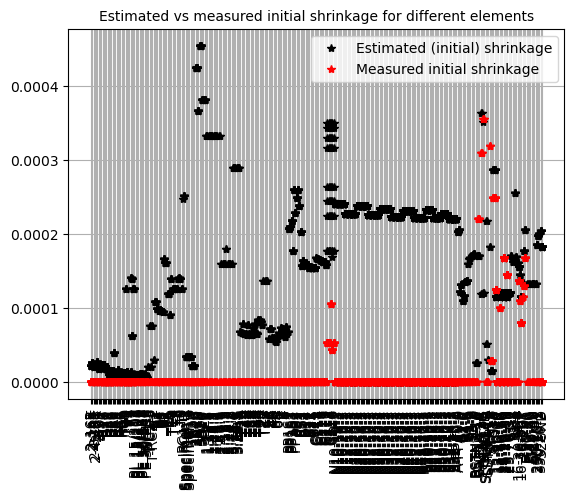

In [213]:
plt.title("Estimated vs measured initial shrinkage for different elements");
plt.plot(df["ELID"],-1*(xi_bs1*df["eps_cbs"] + xi_ds1*df["eps_cds"]),"*k",label="Estimated (initial) shrinkage");
plt.plot(df["ELID"],1*df["epsc"]*10**(-6),"*r",label="Measured initial shrinkage");
plt.legend();
plt.xticks(rotation=90);
plt.grid();

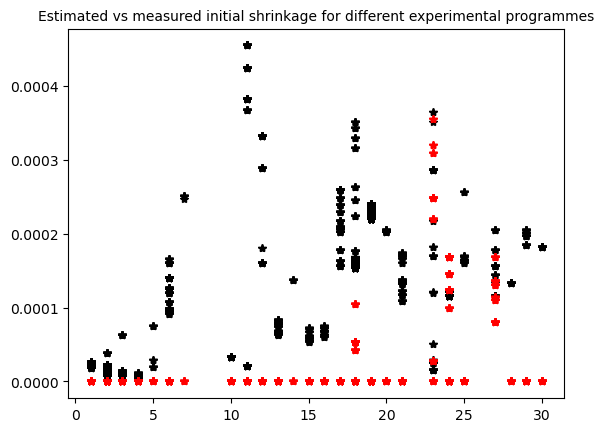

In [214]:
plt.title("Estimated vs measured initial shrinkage for different experimental programmes");
plt.plot(df["EPID"],-1*(xi_bs1*df["eps_cbs"] + xi_ds1*df["eps_cds"]),"*k",label="Estimated (initial) shrinkage");
plt.plot(df["EPID"],1*df["epsc"]*10**(-6),"*r",label="Measured initial shrinkage");

In [215]:
def func_compute_fctmred(data):

    fctmred = np.zeros(data.shape[0]);
    red = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):
        fctmred[i] = data["fctm"].iloc[i] - data["Ecm"].iloc[i]*abs((abs(data["initstrain"].iloc[i]) - abs(data["shrinkage_init"].iloc[i])));

    return fctmred

In [216]:
df["fctmorg"] = df["fctm"]; # Create a copy
df["fcmorg"] = df["fcm"]; # Create a copy

In [217]:
if includeinitshrinkage == "yes":
    df["fctm"] = func_compute_fctmred(df); # Warning: original fctm is rewritten
    df = df.astype({
        "fctm": "float"});

    for i in range(df.shape[0]):
        df["fct095"].iloc[i] = func_cal_fcteff_from_fctm(df["fctm"].iloc[i]);
        
        df["fctmfl"].iloc[i] = func_cal_fctmfl_from_fctm(df["fctm"].iloc[i],df["h"].iloc[i]);
        
        df["fct095fl"].iloc[i] = func_cal_fcteff_from_fctm(df["fctm"].iloc[i]);
        

#### Cracking stage

In [218]:
def func_cal_EI_uncr(data):

    W_Ib = np.zeros(data.shape[0]); W_It = np.zeros(data.shape[0]);

    EI_conc = np.zeros(data.shape[0]); EI_steel = np.zeros(data.shape[0]); EI_prestress = np.zeros(data.shape[0]); EI_uncr = np.zeros(data.shape[0]);

    for i in range(data.shape[0]):

        EI_conc[i] = data["Izz"].iloc[i];
        EI_steel[i] = (data["Astot"].iloc[i]*(data["cog"].iloc[i]-data["zstot"].iloc[i])**2)*(data["ae"].iloc[i]-1)
        EI_prestress[i] = (data["Aptot"].iloc[i]*(data["cog"].iloc[i]-data["zptot"].iloc[i])**2)*(data["ap"].iloc[i]-1)
    
        EI_uncr[i] = EI_conc[i] + EI_steel[i] + EI_prestress[i];
    
        W_Ib[i] = EI_uncr[i]/((data["h"].iloc[i]-data["cog"].iloc[i]));
        W_It[i] = EI_uncr[i]/((data["cog"].iloc[i]));
    
    return W_Ib, W_It

In [219]:
df["W_Ib"], df["W_It"] = func_cal_EI_uncr(df);
df = df.astype({
    "W_Ib": "float",
    "W_It": "float"
});

In [220]:
def func_cal_CS(data):

    Ncr = np.zeros(data.shape[0]);
    Mcr = np.zeros(data.shape[0]);
    
    Ncr095 = np.zeros(data.shape[0]);
    Mcr095 = np.zeros(data.shape[0]);

    Ncr005 = np.zeros(data.shape[0]);
    Mcr005 = np.zeros(data.shape[0]);

    CS = np.zeros(data.shape[0]);

    for i in range(data.shape[0]):
        if data["epsin"].iloc[i] == "1a" or data["epsin"].iloc[i] == "1b":

            if data["EPID"].iloc[i] != 31:
                rho = data["Astot"].iloc[i]/data["Ac"].iloc[i];
    
                Ncr[i] = data["Ac"].iloc[i]*data["fctm"].iloc[i]*(1+(data["ae"].iloc[i]-1)*rho); # N-1 zware doorsnede
                Ncr[i] = Ncr[i]/(1e3);
                
                Ncr095[i] = data["Ac"].iloc[i]*data["fct095"].iloc[i]*(1+(data["ae"].iloc[i]-1)*rho); # N-1 zware doorsnede
                Ncr095[i] = Ncr095[i]/(1e3);
    
                Ncr005[i] = data["Ac"].iloc[i]*data["fct005"].iloc[i]*(1+(data["ae"].iloc[i]-1)*rho); # N-1 zware doorsnede
                Ncr005[i] = Ncr005[i]/(1e3);

            elif data["EPID"].iloc[i] == 31:
                rho = data["Astot"].iloc[i]/(data["Ac"].iloc[i] - (4*90*30));

                Ncr[i] = (data["Ac"].iloc[i] - (4*90*30))*data["fctm"].iloc[i]*(1+(data["ae"].iloc[i]-1)*rho); # N-1 zware doorsnede
                Ncr[i] = Ncr[i]/(1e3);
                
                Ncr095[i] = (data["Ac"].iloc[i] - (4*90*30))*data["fct095"].iloc[i]*(1+(data["ae"].iloc[i]-1)*rho); # N-1 zware doorsnede
                Ncr095[i] = Ncr095[i]/(1e3);
    
                Ncr005[i] = (data["Ac"].iloc[i] - (4*90*30))*data["fct005"].iloc[i]*(1+(data["ae"].iloc[i]-1)*rho); # N-1 zware doorsnede
                Ncr005[i] = Ncr005[i]/(1e3);

            if data["N"].iloc[i] > Ncr095[i]:
                CS[i] = 2; # Stabilized cracking stage
            else:
                CS[i] = 1; # Crack formation stage
        
        elif data["epsin"].iloc[i] == str(2):

            # include the effect of the crack inducers
            if data["EPID"].iloc[i] != 17:
            
                Mcr[i] = data["W_Ib"].iloc[i]*data["fctmfl"].iloc[i];
                Mcr[i] = Mcr[i]/(1e6);
                
                Mcr095[i] = data["W_Ib"].iloc[i]*data["fct095fl"].iloc[i];
                Mcr095[i] = Mcr095[i]/(1e6);
    
                Mcr005[i] = data["W_Ib"].iloc[i]*data["fct005fl"].iloc[i];
                Mcr005[i] = Mcr005[i]/(1e6);

            elif data["EPID"].iloc[i] == 17:
                
                if data["Astot"].iloc[i] < tol: # Crack inducers with height of 6.35 mm used
                    red = ((data["h"].iloc[i] - 6.35)**2) / (data["h"].iloc[i]**2);
                elif data["Astot"].iloc[i] > tol: # Crack inducers up to reinforcing level used
                    red = ((data["h"].iloc[i] - data["cy"].iloc[i])**2) / (data["h"].iloc[i]**2);
                
                Mcr[i] = red*data["W_Ib"].iloc[i]*data["fctmfl"].iloc[i];
                Mcr[i] = Mcr[i]/(1e6);
                
                Mcr095[i] = red*data["W_Ib"].iloc[i]*data["fct095fl"].iloc[i];
                Mcr095[i] = Mcr095[i]/(1e6);
    
                Mcr005[i] = red*data["W_Ib"].iloc[i]*data["fct005fl"].iloc[i];
                Mcr005[i] = Mcr005[i]/(1e6);
                
            if data["M"].iloc[i] > Mcr095[i]:
                CS[i] = 2; # Stabilized cracking stage
            else:
                CS[i] = 1; # Crack formation stage
        
        elif data["epsin"].iloc[i] == str(3):

            # include the effect of the crack inducers
            if data["EPID"].iloc[i] != 17:
    
                Mcr[i] = data["W_Ib"].iloc[i]*(data["fctmfl"].iloc[i] + 1000*data["PL"].iloc[i]/data["Ac"].iloc[i]);
                Mcr[i] = Mcr[i]/(1e6);
                
                Mcr095[i] = data["W_Ib"].iloc[i]*(data["fct095fl"].iloc[i] + 1000*data["PL"].iloc[i]/data["Ac"].iloc[i]);
                Mcr095[i] = Mcr095[i]/(1e6);
    
                Mcr005[i] = data["W_Ib"].iloc[i]*(data["fct005fl"].iloc[i] + 1000*data["PL"].iloc[i]/data["Ac"].iloc[i]);
                Mcr005[i] = Mcr005[i]/(1e6);

            elif data["EPID"].iloc[i] == 17:
                
                if data["Astot"].iloc[i] < tol: # Crack inducers with height of 6.35 mm used
                    red = ((data["h"].iloc[i] - 6.35)**2) / (data["h"].iloc[i]**2);
                elif data["Astot"].iloc[i] > tol: # Crack inducers up to reinforcing level used
                    red = ((data["h"].iloc[i] - data["cy"].iloc[i])**2) / (data["h"].iloc[i]**2);

                Mcr[i] = red*data["W_Ib"].iloc[i]*(data["fctmfl"].iloc[i] + 1000*data["PL"].iloc[i]/data["Ac"].iloc[i]);
                Mcr[i] = Mcr[i]/(1e6);
                
                Mcr095[i] = red*data["W_Ib"].iloc[i]*(data["fct095fl"].iloc[i] + 1000*data["PL"].iloc[i]/data["Ac"].iloc[i]);
                Mcr095[i] = Mcr095[i]/(1e6);
    
                Mcr005[i] = red*data["W_Ib"].iloc[i]*(data["fct005fl"].iloc[i] + 1000*data["PL"].iloc[i]/data["Ac"].iloc[i]);
                Mcr005[i] = Mcr005[i]/(1e6);

            if data["M"].iloc[i] > Mcr095[i]:
                CS[i] = 2;  # Stabilized cracking stage
            else:
                CS[i] = 1; # Crack formation stage
                
    return Ncr095, Mcr095, Ncr005, Mcr005, CS, Ncr, Mcr

In [221]:
df["Ncr095"], df["Mcr095"], df["Ncr005"], df["Mcr005"], df["CS"], df["Ncr"], df["Mcr"] = func_cal_CS(df);
df = df.astype({
    "Ncr095": "float",
    "Mcr095": "float",
    "Ncr005": "float",
    "Mcr005": "float",
    "CS": "int",
    "Ncr": "float",
    "Mcr": "float",
});

#### Computation of the bond stress

In [227]:
def func_cal_bond(data,timecutoff,Nrepcutoff):

    # tau_bms CS = 1 (CFS), CS = 2 (SCS)
    # Good bond = 1, bad bond = 2

    tau_bms = np.zeros(data.shape[0]);
    tau_max = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):
        # tau_bms
        # =======

        if data["CS"].iloc[i] == 1: # Address CFS
            if data["Nrep"].iloc[i] <= Nrepcutoff and data["t"].iloc[i] <= timecutoff:
                tau_bms[i] = 1.8*data["fctmorg"].iloc[i];
            if data["Nrep"].iloc[i] <= Nrepcutoff and data["t"].iloc[i] > timecutoff:
                tau_bms[i] = 1.35*data["fctmorg"].iloc[i];
            if data["Nrep"].iloc[i] > Nrepcutoff and data["t"].iloc[i] <= timecutoff:
                tau_bms[i] = 1.35*data["fctmorg"].iloc[i];
            if data["Nrep"].iloc[i] > Nrepcutoff and data["t"].iloc[i] > timecutoff:
                tau_bms[i] = 1.35*data["fctmorg"].iloc[i];
        elif data["CS"].iloc[i] == 2: # Address SCS
            if data["Nrep"].iloc[i] <= Nrepcutoff and data["t"].iloc[i] <= timecutoff:
                tau_bms[i] = 1.8*data["fctmorg"].iloc[i];
            if data["Nrep"].iloc[i] <= Nrepcutoff and data["t"].iloc[i] > timecutoff:
                tau_bms[i] = 1.8*data["fctmorg"].iloc[i];
            if data["Nrep"].iloc[i] > Nrepcutoff and data["t"].iloc[i] <= timecutoff:
                tau_bms[i] = 1.8*data["fctmorg"].iloc[i];
            if data["Nrep"].iloc[i] > Nrepcutoff and data["t"].iloc[i] > timecutoff:
                tau_bms[i] = 1.8*data["fctmorg"].iloc[i];
        
        # tau_max en tau_b0
        # =======
        if data["bondLR"].iloc[i] in [0,1] or data["bondPR"].iloc[i] in [0,1]: # Address good or unknown bond
            tau_max[i] = 2.5*np.sqrt(data["fcmorg"].iloc[i]);
            
        elif data["bondLR"].iloc[i] == 2 or data["bondPR"].iloc[i] == 2: # All other bond conditions
            tau_max[i] = 1.25*np.sqrt(data["fcmorg"].iloc[i]);
    
    return tau_bms, tau_max

In [228]:
df["tau_bms"], df["tau_max"] = func_cal_bond(df,timecutoff,Nrepcutoff);
df = df.astype({
    "tau_bms": "float",
    "tau_max": "float"
});

In [229]:
df.shape

(4903, 170)

### 05.12 - Computation of the steel stress

#### Create an initial guess for the bending case

In [230]:
def func_cal_init(data):

    xcinit = np.zeros(data.shape[0]);
    epsinit = np.zeros(data.shape[0]);

    for i in range(data.shape[0]):
        if str(data["epsin"].iloc[i]) == str(2) or str(data["epsin"].iloc[i]) == str(3) and data["Astot"].iloc[i] > 0 and data["M"].iloc[i] > 0:
            
            ae = data["ae"].iloc[i]; rho = data["rhotensinit"].iloc[i];
            d = data["h"].iloc[i] - data["ry"].iloc[i];
            
            kx = -ae*rho + np.sqrt((ae*rho)**2 + 2*ae*rho);
            xcinit[i] = d*kx;

            b = data["Ac"].iloc[i]/data["h"].iloc[i]; # Pseudo-width of the cross-section
            epsinit[i] = 2*(1e6)*data["M"].iloc[i]/(data["Ecm"].iloc[i]*b*xcinit[i]*(d-xcinit[i]/3));
    
    return xcinit, epsinit

In [231]:
df["xcinit"], df["epsinit"] = func_cal_init(df);
df = df.astype({
    "xcinit": "float",
    "epsinit": "float"
});

#### Constitutive relations

##### Concrete

In [232]:
def func_interpolate_concrete_prop(fcm,E_ci):
    
    C_12 = [20,27100,11100,0.0019,0.0035,2.44];
    C_16 = [24,28800,12200,0.002,0.0035,2.36];
    C_20 = [28,30300,13300,0.0021,0.0035,2.28];
    C_25 = [33,32000,14900,0.0022,0.0035,2.15];
    C_30 = [38,33600,16500,0.0023,0.0035,2.04];
    C_35 = [43,35000,18200,0.0023,0.0035,1.92];
    C_40 = [48,36300,20000,0.0024,0.0035,1.82];
    C_45 = [53,37500,21600,0.0025,0.0035,1.74];
    C_50 = [58,38600,23200,0.0026,0.0034,1.66];
    C_55 = [63,39700,24700,0.0026,0.0034,1.61];
    C_60 = [68,40700,26200,0.0027,0.0033,1.55];
    C_70 = [78,42600,28900,0.0027,0.0032,1.47];
    C_80 = [88,44400,31400,0.0028,0.0031,1.41];
    C_90 = [98,46000,33800,0.0029,0.003,1.36];
    C_100 = [108,47500,36000,0.003,0.003,1.32];
    
    d = {"C12":C_12,"C16":C_16,"C20":C_20,"C25":C_25,"C30":C_30,"C35":C_35,"C40":C_40,"C45":C_45,"C50":C_50,\
         "C55":C_55,"C60":C_60,"C70":C_70,"C80":C_80,"C90":C_90,"C100":C_100};
    
    col = ["fcm","Eci","Ec1","epsc1","epsclim","k"];
        
    df = pd.DataFrame(data=d).T
    df.columns = col;
    
    E_c1_ipl = interp1d(df["fcm"],df["Ec1"],fill_value="extrapolate");
    eps_c1_ipl = interp1d(df["fcm"],df["epsc1"],fill_value="extrapolate");
    eps_clim_ipl = interp1d(df["fcm"],df["epsclim"],fill_value="extrapolate");

    Ec_1 = E_c1_ipl(fcm);
    eps_c1 = eps_c1_ipl(fcm);
    eps_clim = eps_clim_ipl(fcm);
    
    k = E_ci / Ec_1;
    
    return k, eps_c1, eps_clim

In [233]:
def func_cal_fcm_eps(fcm,eps_c,eps_c1,k,epslim,Ecm,phi_creep,chi):
    
    eta = (eps_c/(1+chi*phi_creep)) / eps_c1;

    sig_c = 0;

    if eps_c < 0:
        sig_c = 0;
    
    # elif 0 <= eps_c <= epslim:
    elif 0 <= eps_c <= epslim/(1+chi*phi_creep):
        sig_c = fcm*(k*eta - (eta**2))/(1 + (k-2)*eta);
    
    elif eps_c > epslim/(1+chi*phi_creep):
        sig_c = 0;
    
    return sig_c

##### Reinforcing steel

It is assumed that the steel behaves linear elastic. Afterwards, it is checked if the yield stress is exceeded.

##### Prestressing steel

In [234]:
def func_cal_prestress(Ep,fp01k,fpk,eps_pud,eps):

    stress = Ep*eps;
    
    return stress

#### Forces and point of application of forces

##### Concrete - compression

In [235]:
def func_int_compression(z,epsctop,xc,b,h,Nint,fcm,eps_c1,k,epslim,Ecm,phi_creep,chi):
           
    eps_c = func_create_strain_dist(epsctop,xc,z);

    sig_c = func_cal_fcm_eps(fcm,eps_c,eps_c1,k,epslim,Ecm,phi_creep,chi);

    bz = func_extract_width(z,b);
    dF = sig_c*bz;
    
    return dF

In [236]:
def func_int_compression_moment(z,epsctop,xc,b,h,Nint,fcm,eps_c1,k,epslim,Ecm,phi_creep,chi):
    
    dF = func_int_compression(z,epsctop,xc,b,h,Nint,fcm,eps_c1,k,epslim,Ecm,phi_creep,chi);
    zdF = dF*z;
    
    return zdF

##### Concrete - uncracked part, but in tension

In [237]:
def func_int_uncracked_tension(z,epsctop,xc,b,Ecm):

    eps_c = func_create_strain_dist(epsctop,xc,z);
    
    sigt = -1*Ecm*eps_c;
    
    bz = func_extract_width(z,b);
    dF = sigt*bz;

    return dF

##### Concrete - cracked part, contribution according to Hordijk

In [238]:
def func_cal_tension_softening(fcm,fctm,w):
    
    c1 = 3; c2 = 6.93;
    Gf = 85*(fcm**0.15)/1000;
    wult = 5.136*Gf/fctm;
    
    if w >= 0 and w < wult:
        sigct = fctm*\
            (( 1 + (c1*w/wult)**3 ) * np.exp(-c2*w/wult) - (w/wult)*(1+c1**3)*np.exp(-c2));

    else:
        sigct = 0;

    return sigct

In [239]:
def func_int_hordijk(z,zw,xc,xct1,fcm,b,h,fctm,w0,epsin):
    
    if epsin == str(2) or epsin == str(3): # Addressing case of bending, or prestressing
        w = w0*(z-xc-xct1)/(zw-xc-xct1);
        sig_t = func_cal_tension_softening(fcm,fctm,w);
    elif epsin == str("1a"): # Addressing case of pure tension
        w = w0;
        sig_t = func_cal_tension_softening(fcm,fctm,w);

    bz = func_extract_width(z,b);
    dF = sig_t*bz;

    return dF

In [240]:
def func_int_hordijk_moment(z,zw,xc,xct1,fcm,b,h,fctm,w0,epsin):

    dF = func_int_hordijk(z,zw,xc,xct1,fcm,b,h,fctm,w0,epsin);
    dFz = dF*z;

    return dFz    

##### Reinforcing steel

In [241]:
def func_compute_steel_stress(epsctop,Es,As,xc,zs,zt,fy,Nzero):
    
    Fstore = func_sum_steel_reinf(epsctop,Es,As,xc,zs,zt,fy,Nzero);

    sigs = np.zeros(len(As));
    
    for i in range(int(Nzero)+1): 
        if As[i] > 0:
            sigs[i] = Fstore[0][i]/As[i];

        else:
            sigs[i] = 0;
    
    return sigs

##### Prestressing steel

In [242]:
def func_sum_steel_dP(epsctop,Ep,Ap,xc,zp,zt,fp01k,fpk,eps_pud,Pinf,Nzero,npl,zeta1):
    
    dPstore = np.zeros(len(Ap));
    MdPstore = np.zeros(len(Ap));
    sigptotstore = np.zeros(len(Ap));

    # this is the individual area for a specific tendon within a layer, NOT the total prestressing area in that layer! 
    Aplayer = np.zeros(len(Ap));

    for i in range(int(Nzero)+1):
        Aplayer[i] = npl[i]*Ap[i];
    
    Aptot = sum(Aplayer);      
    
    sigpinf = Pinf/Aptot
    
    # Sum over the layers
    for i in range(int(Nzero)+1):
        
        strainp = sigpinf/Ep + zeta1*epsctop*(zp[i]-xc)/xc;
        dPstore[i] = Aplayer[i]*func_cal_prestress(Ep,fp01k,fpk,eps_pud,strainp) - Aplayer[i]*sigpinf;
        MdPstore[i] = dPstore[i]*(zp[i]-zt);
        sigptotstore = func_cal_prestress(Ep,fp01k,fpk,eps_pud,strainp);
    
    return dPstore, MdPstore, sigptotstore

In [243]:
def func_compute_dsigp(epsctop,Ep,Ap,xc,zp,zt,fp01k,fpk,eps_pud,Pinf,Nzero,npl,zeta1):
    
    dPstore, MdPstore, sigptotstore = func_sum_steel_dP(epsctop,Ep,Ap,xc,zp,zt,fp01k,fpk,eps_pud,Pinf,Nzero,npl,zeta1);
    
    dsigp = np.zeros(len(Ap));
    Aplayer = np.zeros(len(Ap));

    for i in range(int(Nzero)+1):
        Aplayer[i] = npl[i]*Ap[i];
    
    for i in range(int(Nzero)+1):
        if Aplayer[i] > 0:
            dsigp[i] = dPstore[i]/Aplayer[i]
    
    return dsigp, sigptotstore

#### Equilibrium relations

Equilibrium relations for elements loaded in pure bending.

In [244]:
def func_cal_steel_stress_eqset_reinf_V2(p,fcm,eps_c1,k,Es,b,h,Nint,zs,As,fy,Mext,\
                                zt,Nzero,epslim,Next,Ecm,phi_creep,chi):
    
    epsctop,xc = p; # set of unknowns, called xc and epstop
    
    # Compression part of concrete
    # =================================================================
    Fcp = quad(func_int_compression,0,xc,args=(epsctop,xc,b,h,Nint,fcm,eps_c1,k,epslim,Ecm,phi_creep,chi))[0];
    
    # Lever arm of compression force (wrt top!)
    # =================================================================  
    zx = quad(func_int_compression_moment,0,xc,args=(epsctop,xc,b,h,Nint,fcm,eps_c1,k,epslim,Ecm,phi_creep,chi))[0]/Fcp;
    
    # Force and bending moment in reinforcing steel
    # =================================================================   
    Fs, Mf = func_sum_steel_reinf(epsctop,Es,As,xc,zs,zt,fy,Nzero);

    Fstot = sum(Fs);
    Mftot = sum(Mf);
    
    # Return the equilibrium equations
    # =================================================================
        
    horeq = Fcp - Fstot + (10**3)*Next;
    Meq = (10**6)*Mext - Fcp*(zt-zx) - Mftot;
    
    return horeq, Meq

Equilibrium relations for elements subjected to prestressing.

In [245]:
def func_cal_steel_stress_eqset_prestress_V2(p,fcm,eps_c1,k,Es,b,h,Nint,zs,As,fy,Mext,\
                                zt,Pinf,Ep,Ap,zp,fp01k,fpk,eps_pud,\
                                    NzeroAs,NzeroAp,Next,epslim,npl,zeta1,Ecm,phi_creep,chi):
    
    epsctop,xc = p; # set of unknowns, called xc and epstop

    # Compression part of concrete
    # =================================================================
    Fcp = quad(func_int_compression,0,xc,args=(epsctop,xc,b,h,Nint,fcm,eps_c1,k,epslim,Ecm,phi_creep,chi))[0];
    
    # Lever arm of compression force (wrt top!)
    # =================================================================
    zx = quad(func_int_compression_moment,0,xc,args=(epsctop,xc,b,h,Nint,fcm,eps_c1,k,epslim,Ecm,phi_creep,chi))[0]/Fcp;
    
    # Force and bending moment in reinforcing steel
    # =================================================================
    Fs, Mf = func_sum_steel_reinf(epsctop,Es,As,xc,zs,zt,fy,NzeroAs);
    
    Fstot = sum(Fs);
    Mftot = sum(Mf);

    # Berekening invloed van de voorspanning
    # =================================================================   
    dPstore, MdPstore, sigptotstore = func_sum_steel_dP(epsctop,Ep,Ap,xc,zp,zt,fp01k,fpk,eps_pud,Pinf,NzeroAp,npl,zeta1);
    
    dFp = sum(dPstore);
    Mptot = sum(MdPstore);
    
    # Return the equilibrium equations
    # =================================================================
    horeq = Fcp + (10**3)*Next - Fstot - dFp - Pinf;
    Meq = (10**6)*Mext - Fcp*(zt-zx) - Mftot - Mptot;
    
    return horeq, Meq

Equilibrium relations for elements subjected to pure tension.

In [246]:
def func_cal_steel_stress_eqset_reinf_Hordijk_tensioning(Next,zw,xc,xct1,fcm,b,h,fctm,w0,epsin):

    Nct2 = quad(func_int_hordijk,0,h,args=(zw,xc,xct1,fcm,b,h,fctm,w0,epsin))[0];
    Ns = Next - Nct2; # Linear elastic part, uncracked, in tension, does not exist (constant strain distribution over the height of the cross-section)

    return Ns   
    

In [247]:
def func_cal_steel_stress_eqset_reinf_Hordijk_bending(p,fcm,eps_c1,k,Es,b,h,Nint,zs,As,fy,Mext,\
                                zt,Nzero,epslim,Next,Ecm,phi_creep,chi,zw,w0,epsin,fctm):
    
    epsctop,xc = p; # set of unknowns, called xc and epstop
    
    # Compression part of concrete
    # =================================================================
    Fcp = quad(func_int_compression,0,xc,args=(epsctop,xc,b,h,Nint,fcm,eps_c1,k,epslim,Ecm,phi_creep,chi))[0];
    
    # Lever arm of compression force (wrt top!)
    # =================================================================  
    zx = quad(func_int_compression_moment,0,xc,args=(epsctop,xc,b,h,Nint,fcm,eps_c1,k,epslim,Ecm,phi_creep,chi))[0]/Fcp;

    # Part of the concrete that is uncracked, but in tension
    # =================================================================  
    xct1 = (fctm/Ecm)*(xc/epsctop);
    Nct1 = quad(func_int_uncracked_tension,xc,xc+xct1,args=(epsctop,xc,b,Ecm))[0];

    # Location of force application of NCT1
    # =================================================================  
    zct1 = xc + (2/3)*xct1;

    # Hordijk contribution
    # =================================================================  
    Nct2 = quad(func_int_hordijk,xc+xct1,h,args=(zw,xc,xct1,fcm,b,h,fctm,w0,epsin))[0];

    # Location of force application of NCT2
    # ================================================================= 
    zct2 = xc + xct1 + quad(func_int_hordijk_moment,xc+xct1,h,args=(zw,xc,xct1,fcm,b,h,fctm,w0,epsin))[0]/Nct2;
    
    # Force and bending moment in reinforcing steel
    # =================================================================   
    Fs, Mf = func_sum_steel_reinf(epsctop,Es,As,xc,zs,zt,fy,Nzero);

    Fstot = sum(Fs);
    Mftot = sum(Mf);
    
    # Return the equilibrium equations
    # =================================================================
        
    horeq = Fcp - Nct1 - Nct2 - Fstot + (10**3)*Next;
    Meq = (10**6)*Mext - Fcp*(zt-zx) - Mftot + Nct1*(zt-xc-(2/3)*xct1) - Nct2*(zct2-zt) ;
    
    return horeq, Meq

In [248]:
def func_cal_steel_stress_eqset_prestress_Hordijk(p,fcm,eps_c1,k,Es,b,h,Nint,zs,As,fy,Mext,\
                                zt,Pinf,Ep,Ap,zp,fp01k,fpk,eps_pud,\
                                    NzeroAs,NzeroAp,Next,epslim,npl,zeta1,Ecm,phi_creep,chi,zw,w0,epsin,fctm):
    
    epsctop,xc = p; # set of unknowns, called xc and epstop

    # Compression part of concrete
    # =================================================================
    Fcp = quad(func_int_compression,0,xc,args=(epsctop,xc,b,h,Nint,fcm,eps_c1,k,epslim,Ecm,phi_creep,chi))[0];
    
    # Lever arm of compression force (wrt top!)
    # =================================================================
    zx = quad(func_int_compression_moment,0,xc,args=(epsctop,xc,b,h,Nint,fcm,eps_c1,k,epslim,Ecm,phi_creep,chi))[0]/Fcp;

    # Part of the concrete that is uncracked, but in tension
    # =================================================================  
    xct1 = (fctm/Ecm)*(xc/epsctop);
    Nct1 = quad(func_int_uncracked_tension,xc,xc+xct1,args=(epsctop,xc,b,Ecm))[0];

    # Location of force application of NCT1
    # =================================================================  
    zct1 = xc + (2/3)*xct1;

    # Hordijk contribution
    # =================================================================  
    Nct2 = quad(func_int_hordijk,xc+xct1,h,args=(zw,xc,xct1,fcm,b,h,fctm,w0,epsin))[0];

    # Location of force application of NCT2
    # ================================================================= 
    zct2 = xc + xct1 + quad(func_int_hordijk_moment,xc+xct1,h,args=(zw,xc,xct1,fcm,b,h,fctm,w0,epsin))[0]/Nct2;
    
    # Force and bending moment in reinforcing steel
    # =================================================================
    Fs, Mf = func_sum_steel_reinf(epsctop,Es,As,xc,zs,zt,fy,NzeroAs);
    
    Fstot = sum(Fs);
    Mftot = sum(Mf);

    # Berekening invloed van de voorspanning
    # =================================================================   
    dPstore, MdPstore, sigptotstore = func_sum_steel_dP(epsctop,Ep,Ap,xc,zp,zt,fp01k,fpk,eps_pud,Pinf,NzeroAp,npl,zeta1);
    
    dFp = sum(dPstore);
    Mptot = sum(MdPstore);
    
    # Return the equilibrium equations
    # =================================================================
    horeq = Fcp + (10**3)*Next - Nct1 - Nct2 - Fstot - dFp - Pinf;
    Meq = (10**6)*Mext - Fcp*(zt-zx) - Mftot - Mptot + Nct1*(zt-xc-(2/3)*xct1) - Nct2*(zct2-zt);
    
    return horeq, Meq

#### Calculation of steel stress including Hordijk Tension Softening

In [249]:
def func_cal_steel_stress_hordijk(data):

    sigstoresimplified = np.zeros(data.shape[0]);
    sigstore = np.zeros((data.shape[0],Ncond)); # Store stresses of all reinforcement layers!
    dpsigstore = np.zeros((data.shape[0],Ncond)); # Store stresses dpsig
    sigptotstore = np.zeros((data.shape[0],Ncond)); # Store prestressing stresses acting in each tendon
    
    xc = np.zeros(data.shape[0]);
    eps = np.zeros(data.shape[0]);# Calculated strain at the top of the considered concrete section
    eps_bot = np.zeros(data.shape[0]);# Calculated strain at the bottom of the considered concrete section

    data["sigs"] = np.zeros(data.shape[0]); # Overwrite --> prevents that "old stress remain"
    data["dpsigs"] = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):

        # Determine param zw
        if data["locw"].iloc[i] == 1:
            zw = zs[i,data["indLR"].iloc[i]];
        elif data["locw"].iloc[i] == 2:
            zw = data["h"].iloc[i];
        else:
            zw = 0;

        # Determine param w0
        if data["wm"].iloc[i] > tol and data["wmax"].iloc[i] < tol:
            w0 = data["wm"].iloc[i];
        elif data["wmax"].iloc[i] > tol and data["wm"].iloc[i] < tol:
            w0 = data["wmax"].iloc[i];
        elif data["wm"].iloc[i] > tol and data["wmax"].iloc[i] > tol:
            w0 = data["wmax"].iloc[i];
        else:
            w0 = 0;

        with suppress(ZeroDivisionError): # Continue calculation

            # Pure axial force
            # ==================================================================================
            if str(data["epsin"].iloc[i]) == str("1a"):

                if data["Astot"].iloc[i] > tol:

                    k, eps_c1, eps_clim = func_interpolate_concrete_prop(data["fcm"].iloc[i],data["Ecm0"].iloc[i]);
                    Ns = func_cal_steel_stress_eqset_reinf_Hordijk_tensioning(data["N"].iloc[i]*(10**3),
                                                                              zw,
                                                                              0, # xc is not needed (pure tension)
                                                                              0, # xct1 is not needed (is 0, assumption: complete section is cracked))
                                                                              data["fcm"].iloc[i],
                                                                              data["b"].iloc[i],
                                                                              data["h"].iloc[i],
                                                                              data["fctm"].iloc[i],
                                                                              w0,
                                                                              data["epsin"].iloc[i]);

                    sigstore[i,:] = Ns/data["Astot"].iloc[i];
                    sigstoresimplified[i] = (10**3)*data["N"].iloc[i] / data["Astot"].iloc[i]; # Useful for shadow-calculation!

                    if sigstore[i,data["indLR"].iloc[i]] > data["fy"].iloc[i]:
                        #print("Warning: computed steel stress",sigstore[i,data["indLR"].iloc[i]],
                        #      "larger than yield strength",data["fy"].iloc[i],"reject result");
                        sigstore[i,data["indLR"].iloc[i]] == np.nan; # Since this steel stress is not valid!
                        data["sigs"].iloc[i] = np.nan;
                    else:
                        #print("Success: a valid steel stress (<fy) was computed",sigstore[i,data["indLR"].iloc[i]],"<",data["fy"].iloc[i]);
                        data["sigs"].iloc[i] = sigstore[i,data["indLR"].iloc[i]];
            
            # Pure bending and / or bending in combination with axial forces 
            # ==================================================================================
            if str(data["epsin"].iloc[i]) == str(2):
                
                # Below, address the case of reinforcing steel only
                # ====================================
                if data["Aptot"].iloc[i] < tol:

                    k, eps_c1, eps_clim = func_interpolate_concrete_prop(data["fcm"].iloc[i],data["Ecm0"].iloc[i]);
                    
                    sol = fsolve(func_cal_steel_stress_eqset_reinf_Hordijk_bending,[data["epsinit"].iloc[i],data["xcinit"].iloc[i]],
                                                        args=(data["fcm"].iloc[i],
                                                                eps_c1,
                                                                k,
                                                                data["Es"].iloc[i],
                                                                data["b"].iloc[i],
                                                                data["h"].iloc[i],
                                                                500,
                                                                zs[i,:],
                                                                Aslayer[i,:],
                                                                data["fy"].iloc[i],
                                                                data["M"].iloc[i],
                                                                data["cog"].iloc[i],
                                                                data["indLR"].iloc[i],
                                                                eps_clim,
                                                                data["N"].iloc[i],
                                                                data["Ecm"].iloc[i],
                                                                data["phi_creep"].iloc[i],
                                                                chi,
                                                                zw,
                                                                w0,
                                                                data["epsin"].iloc[i],
                                                                data["fctm"].iloc[i]
                                                            ));
                    
                    eps[i], xc[i] = sol[0], sol[1];
                    eps_bot[i] = eps[i]*(data["h"].iloc[i]-xc[i])/xc[i];
        
                    sigstore[i,:] = func_compute_steel_stress(eps[i],
                                                                     data["Es"].iloc[i],
                                                                     Aslayer[i,:],
                                                                     xc[i],
                                                                     zs[i,:],
                                                                     data["cog"].iloc[i],
                                                                     data["fy"].iloc[i],
                                                                     data["indLR"].iloc[i]);

                    sigstoresimplified[i] = ((10**6)*data["M"].iloc[i] / data["Astot"].iloc[i])*(1/(data["zstot"].iloc[i]-data["xcinit"].iloc[i]/3))

                    # Check if conditions are met (w.r.t. lowest reinforcing layer; stress should be smaller than yield strength)
                    if sigstore[i,data["indLR"].iloc[i]] > data["fy"].iloc[i]:
                        #print("Warning: computed steel stress",sigstore[i,data["indLR"].iloc[i]],
                        #      "larger than yield strength",data["fy"].iloc[i],"reject result");
                        sigstore[i,data["indLR"].iloc[i]] == np.nan; # Since this steel stress is not valid!
                        data["sigs"].iloc[i] = np.nan;
                    else:
                        #print("Success: a valid steel stress (<fy) was computed",sigstore[i,data["indLR"].iloc[i]],"<",data["fy"].iloc[i]);
                        data["sigs"].iloc[i] = sigstore[i,data["indLR"].iloc[i]];

            # Prestressing
            # ==================================================================================
            if str(data["epsin"].iloc[i]) == str(3):
                
                # Below, address the case of prestressing steel, maybe in combination with reinforcing steel
                # ====================================
                if data["Aptot"].iloc[i] > tol:

                    k, eps_c1, eps_clim = func_interpolate_concrete_prop(data["fcm"].iloc[i],data["Ecm0"].iloc[i]);
                    
                    sol = fsolve(func_cal_steel_stress_eqset_prestress_Hordijk,[0.001,data["h"].iloc[i]/3],
                                                                args=(data["fcm"].iloc[i],
                                                                eps_c1,
                                                                k,
                                                                data["Es"].iloc[i],
                                                                data["b"].iloc[i],
                                                                data["h"].iloc[i],
                                                                500,
                                                                zs[i,:],
                                                                Aslayer[i,:],
                                                                data["fy"].iloc[i],
                                                                data["M"].iloc[i],
                                                                data["cog"].iloc[i],
                                                                1000*data["PL"].iloc[i],
                                                                data["Ep"].iloc[i],
                                                                Ap[i,:], # Area per tendon in a layer
                                                                zp[i,:],
                                                                data["fp01k"].iloc[i],
                                                                data["fpk"].iloc[i],
                                                                0.005, # epsuk
                                                                data["indLR"].iloc[i],
                                                                data["indNP"].iloc[i],
                                                                data["N"].iloc[i],
                                                                eps_clim,
                                                                npl[i,:],
                                                                data["zeta1"].iloc[i],
                                                                data["Ecm"].iloc[i],
                                                                data["phi_creep"].iloc[i],
                                                                chi,
                                                                zw,
                                                                w0,
                                                                data["epsin"].iloc[i],
                                                                data["fctm"].iloc[i]
                                                                    ));    
                        
                    eps[i], xc[i] = sol[0], sol[1];
                    eps_bot[i] = eps[i]*(data["h"].iloc[i]-xc[i])/xc[i];
                                    
                    sigstore[i,:] = func_compute_steel_stress(eps[i],
                                                             data["Es"].iloc[i],
                                                             Aslayer[i,:],
                                                             xc[i],
                                                             zs[i,:],
                                                             data["cog"].iloc[i],
                                                             data["fy"].iloc[i],
                                                             data["indLR"].iloc[i]);
                    
                    dpsigstore[i,:], sigptotstore[i,:] = func_compute_dsigp(eps[i],
                                                                     data["Ep"].iloc[i],
                                                                     Ap[i,:],
                                                                     xc[i],
                                                                     zp[i,:],
                                                                     data["cog"].iloc[i],
                                                                     data["fp01k"].iloc[i],
                                                                     data["fpk"].iloc[i],
                                                                     0.005, # epsuk
                                                                     1000*data["PL"].iloc[i],
                                                                     data["indNP"].iloc[i],
                                                                     npl[i,:],
                                                                     data["zeta1"].iloc[i]);

                    # Check if conditions are met (w.r.t. lowest reinforcing layer; stress should be smaller than yield strength)
                    # Check if conditions are met (w.r.t. lowest reinforcing layer and prestressing layer)
                    if sigstore[i,data["indLR"].iloc[i]] > data["fy"].iloc[i] or sigptotstore[i,data["indNP"].iloc[i]] > data["fp01k"].iloc[i]:
                        #print("Warning: computed steel stress",sigstore[i,data["indLR"].iloc[i]],
                        #      "larger than yield strength",data["fy"].iloc[i],"OR computed prestressing stress",
                        #     sigptotstore[i,data["indNP"].iloc[i]],"exceeds fp01k",data["fp01k"].iloc[i],"REJECT");
                        sigstore[i,data["indLR"].iloc[i]] == np.nan; # Since this steel stress is not valid!
                        dpsigstore[i,data["indNP"].iloc[i]] == np.nan; # Since this prestressing steel stress is not valid
                        data["sigs"].iloc[i] = np.nan;
                        data["dpsigs"].iloc[i] = np.nan;
                    else:
                        #print("Success: a valid steel stress was computed (<fy)",sigstore[i,data["indLR"].iloc[i]],"<",data["fy"].iloc[i],
                        #     "or valid prestressing steel stress was computed (<fp01k)",sigptotstore[i,data["indNP"].iloc[i]],"<",data["fp01k"].iloc[i]);
                        data["sigs"].iloc[i] = sigstore[i,data["indLR"].iloc[i]];
                        data["dpsigs"].iloc[i] = dpsigstore[i,data["indNP"].iloc[i]];

    # Write results
    # =====================================================================
    
    data["xc"] = xc;
    data["eps"] = eps;
    data["epsbot"] = eps_bot;
    data["sigssimpl"] = sigstoresimplified;
    
    return data

In [250]:
def func_cal_steel_stress(data):

    sigstore = np.zeros((data.shape[0],Ncond)); # Store stresses of all reinforcement layers!
    dpsigstore = np.zeros((data.shape[0],Ncond)); # Store stresses dpsig
    sigptotstore = np.zeros((data.shape[0],Ncond)); # Store prestressing stresses acting in each tendon

    sigstoresimplified = np.zeros(data.shape[0]);
    
    xc = np.zeros(data.shape[0]);
    eps = np.zeros(data.shape[0]);# Calculated strain at the top of the considered concrete section
    eps_bot = np.zeros(data.shape[0]);# Calculated strain at the bottom of the considered concrete section

    data["sigs"] = np.zeros(data.shape[0]);
    data["dpsigs"] = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):

        with suppress(ZeroDivisionError): # Continue calculation
        
            # Pure tension
            # ==================================================================================
            if str(data["epsin"].iloc[i]) == str("1a"):
                if data["N"].iloc[i] > tol:
                    data["sigs"].iloc[i] = (1e3)*data["N"].iloc[i]/data["Astot"].iloc[i];
                            
            # Pure bending and/or bending in combination with axial forces
            # ==================================================================================
            if str(data["epsin"].iloc[i]) == str(2) or str(data["epsin"].iloc[i]) == str(3):
                
                # Below, address the case of reinforcing steel
                # ====================================
                if data["Aptot"].iloc[i] < tol:
                    
                    k, eps_c1, eps_clim = func_interpolate_concrete_prop(data["fcm"].iloc[i],data["Ecm"].iloc[i]);
                    #print("k",k)
                    #print("eps_c1",eps_c1)
                    #print("eps_clim",eps_clim)

                    sol = fsolve(func_cal_steel_stress_eqset_reinf_V2,[data["epsinit"].iloc[i],data["xcinit"].iloc[i]],
                                                        args=(data["fcm"].iloc[i],
                                                                eps_c1,
                                                                k,
                                                                data["Es"].iloc[i],
                                                                data["b"].iloc[i],
                                                                data["h"].iloc[i],
                                                                500,
                                                                zs[i,:],
                                                                Aslayer[i,:],
                                                                data["fy"].iloc[i],
                                                                data["M"].iloc[i],
                                                                data["cog"].iloc[i],
                                                                data["indLR"].iloc[i],
                                                                eps_clim,
                                                                data["N"].iloc[i],
                                                                data["Ecm"].iloc[i],
                                                                data["phi_creep"].iloc[i],
                                                                chi
                                                            ));
                    
                    eps[i], xc[i] = sol[0], sol[1];
                    eps_bot[i] = eps[i]*(data["h"].iloc[i]-xc[i])/xc[i];
        
                    sigstore[i,:] = func_compute_steel_stress(eps[i],
                                                                     data["Es"].iloc[i],
                                                                     Aslayer[i,:],
                                                                     xc[i],
                                                                     zs[i,:],
                                                                     data["cog"].iloc[i],
                                                                     data["fy"].iloc[i],
                                                                     data["indLR"].iloc[i]);
        
                    #print(sigstore[i,:]);
                    
                    # Check if conditions are met (w.r.t. lowest reinforcing layer; stress should be smaller than yield strength)
                    if sigstore[i,data["indLR"].iloc[i]] > data["fy"].iloc[i]:
                        #print("Warning: computed steel stress",sigstore[i,data["indLR"].iloc[i]],
                        #      "larger than yield strength",data["fy"].iloc[i],"reject result");
                        sigstore[i,data["indLR"].iloc[i]] == np.nan; # Since this steel stress is not valid!
                        data["sigs"].iloc[i] = np.nan;
                    else:
                        #print("Success: a valid steel stress (<fy) was computed",sigstore[i,data["indLR"].iloc[i]],"<",data["fy"].iloc[i]);
                        data["sigs"].iloc[i] = sigstore[i,data["indLR"].iloc[i]];
    
                # Below, address the case of prestressing steel (or in combination with reinforcing steel)
                # ====================================
                elif data["Aptot"].iloc[i] > tol:
    
                    k, eps_c1, eps_clim = func_interpolate_concrete_prop(data["fcm"].iloc[i],data["Ecm"].iloc[i]);
                    
                    sol = fsolve(func_cal_steel_stress_eqset_prestress_V2,[0.001,data["h"].iloc[i]/3],
                                                args=(data["fcm"].iloc[i],
                                                eps_c1,
                                                k,
                                                data["Es"].iloc[i],
                                                data["b"].iloc[i],
                                                data["h"].iloc[i],
                                                500,
                                                zs[i,:],
                                                Aslayer[i,:],
                                                data["fy"].iloc[i],
                                                data["M"].iloc[i],
                                                data["cog"].iloc[i],
                                                1000*data["PL"].iloc[i],
                                                data["Ep"].iloc[i],
                                                Ap[i,:], # Area per tendon in a layer
                                                zp[i,:],
                                                data["fp01k"].iloc[i],
                                                data["fpk"].iloc[i],
                                                0.005, # epsuk
                                                data["indLR"].iloc[i],
                                                data["indNP"].iloc[i],
                                                data["N"].iloc[i],
                                                eps_clim,
                                                npl[i,:],
                                                data["zeta1"].iloc[i],
                                                data["Ecm"].iloc[i],
                                                data["phi_creep"].iloc[i],
                                                chi
                                                    ));    
        
                    eps[i], xc[i] = sol[0], sol[1];
                    eps_bot[i] = eps[i]*(data["h"].iloc[i]-xc[i])/xc[i];
                    
                    sigstore[i,:] = func_compute_steel_stress(eps[i],
                                                                     data["Es"].iloc[i],
                                                                     Aslayer[i,:],
                                                                     xc[i],
                                                                     zs[i,:],
                                                                     data["cog"].iloc[i],
                                                                     data["fy"].iloc[i],
                                                                     data["indLR"].iloc[i]);
                    
                    dpsigstore[i,:], sigptotstore[i,:] = func_compute_dsigp(eps[i],
                                                                     data["Ep"].iloc[i],
                                                                     Ap[i,:],
                                                                     xc[i],
                                                                     zp[i,:],
                                                                     data["cog"].iloc[i],
                                                                     data["fp01k"].iloc[i],
                                                                     data["fpk"].iloc[i],
                                                                     0.005, # epsuk
                                                                     1000*data["PL"].iloc[i],
                                                                     data["indNP"].iloc[i],
                                                                     npl[i,:],
                                                                     data["zeta1"].iloc[i]);
    
                    # Check if conditions are met (w.r.t. lowest reinforcing layer; stress should be smaller than yield strength)
                    # Check if conditions are met (w.r.t. lowest reinforcing layer and prestressing layer)
                    if sigstore[i,data["indLR"].iloc[i]] > data["fy"].iloc[i] or sigptotstore[i,data["indNP"].iloc[i]] > data["fp01k"].iloc[i]:
                        #print("Warning: computed steel stress",sigstore[i,data["indLR"].iloc[i]],
                        #      "larger than yield strength",data["fy"].iloc[i],"OR computed prestressing stress",
                        #      sigptotstore[i,data["indNP"].iloc[i]],"exceeds fp01k",data["fp01k"].iloc[i],"REJECT");
                        sigstore[i,data["indLR"].iloc[i]] == np.nan; # Since this steel stress is not valid!
                        dpsigstore[i,data["indNP"].iloc[i]] == np.nan; # Since this prestressing steel stress is not valid
                        data["sigs"].iloc[i] = np.nan;
                        data["dpsigs"].iloc[i] = np.nan;
                    else:
                        #print("Success: a valid steel stress was computed (<fy)",sigstore[i,data["indLR"].iloc[i]],"<",data["fy"].iloc[i],
                        #     "or valid prestressing steel stress was computed (<fp01k)",sigptotstore[i,data["indNP"].iloc[i]],"<",data["fp01k"].iloc[i]);
                        data["sigs"].iloc[i] = sigstore[i,data["indLR"].iloc[i]];
                        data["dpsigs"].iloc[i] = dpsigstore[i,data["indNP"].iloc[i]];

    data["xc"] = xc;
    data["eps"] = eps;
    data["epsbot"] = eps_bot;
    data["sigssimpl"] = sigstoresimplified;
    
    return data

In [251]:
if importsigs == "no" and hordijksigs == "yes":
    df = func_cal_steel_stress_hordijk(df);
    df[["sigs","sigssimpl","dpsigs","xc","eps","epsbot"]].to_csv("steel_stress_hordijk.csv",index = False);
elif importsigs == "yes" and hordijksigs == "yes":
    df[["sigs","sigssimpl","dpsigs","xc","eps","epsbot"]] = \
        pd.read_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Working_database\steel_stress_hordijk.csv"));

if importsigs == "no" and hordijksigs == "no":
    df = func_cal_steel_stress(df);
    df[["sigs","dpsigs"]].to_csv("steel_stress.csv",index = False);
elif importsigs == "yes" and hordijksigs == "no":
    df[["sigs","dpsigs"]] = \
        pd.read_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Working_database\steel_stress.csv"));

In [252]:
df = df.astype({
    "sigs": "float",
    "dpsigs": "float",
    "xc": "float",
    "eps": "float"
});

In [253]:
df.shape

(4903, 177)

### Function to compute the steel stress directly after cracking

In [255]:
# Again, this is the steel stress at the most tensioned layer
# Effects of creep are negelected since it is directly after first crack occured

In [256]:
def func_cal_steel_stress_directly_after_cracking(data):

    sigsrstore = np.zeros((data.shape[0],Ncond)); # Store stresses of all reinforcement layers!
    dpsigsrstore = np.zeros((data.shape[0],Ncond)); # Store stresses dpsig
    sigpsrtotstore = np.zeros((data.shape[0],Ncond)); # Store prestressing stresses acting in each tendon

    sigssrtoresimplified = np.zeros(data.shape[0]);
    
    xc = np.zeros(data.shape[0]);
    eps = np.zeros(data.shape[0]);# Calculated strain at the top of the considered concrete section
    eps_bot = np.zeros(data.shape[0]);# Calculated strain at the bottom of the considered concrete section

    data["sigsr"] = np.zeros(data.shape[0]);
    data["dpsigsr"] = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):

        with suppress(ZeroDivisionError): # Continue calculation
        
            # Pure tension
            # ==================================================================================
            if str(data["epsin"].iloc[i]) == str("1a"):
                if data["N"].iloc[i] > tol:
                    data["sigsr"].iloc[i] = (1e3)*data["Ncr"].iloc[i]/data["Astot"].iloc[i];
                            
            # Pure bending and / or bending in combination with axial forces 
            # ==================================================================================
            if str(data["epsin"].iloc[i]) == str(2) or str(data["epsin"].iloc[i]) == str(3):
                
                # Below, address the case of reinforcing steel
                # ====================================
                if data["Aptot"].iloc[i] < tol:
                    
                    k, eps_c1, eps_clim = func_interpolate_concrete_prop(data["fcm"].iloc[i],data["Ecm"].iloc[i]);

                    sol = fsolve(func_cal_steel_stress_eqset_reinf_V2,[data["epsinit"].iloc[i]*(data["Mcr"].iloc[i]/data["M"].iloc[i]),data["xcinit"].iloc[i]],
                                                        args=(data["fcm"].iloc[i],
                                                                eps_c1,
                                                                k,
                                                                data["Es"].iloc[i],
                                                                data["b"].iloc[i],
                                                                data["h"].iloc[i],
                                                                500,
                                                                zs[i,:],
                                                                Aslayer[i,:],
                                                                data["fy"].iloc[i],
                                                                data["Mcr"].iloc[i],
                                                                data["cog"].iloc[i],
                                                                data["indLR"].iloc[i],
                                                                eps_clim,
                                                                data["N"].iloc[i],
                                                                data["Ecm0"].iloc[i],
                                                                0, # For creep 0
                                                                chi
                                                            ));
                    
                    eps[i], xc[i] = sol[0], sol[1];
                    eps_bot[i] = eps[i]*(data["h"].iloc[i]-xc[i])/xc[i];
        
                    sigsrstore[i,:] = func_compute_steel_stress(eps[i],
                                                                     data["Es"].iloc[i],
                                                                     Aslayer[i,:],
                                                                     xc[i],
                                                                     zs[i,:],
                                                                     data["cog"].iloc[i],
                                                                     data["fy"].iloc[i],
                                                                     data["indLR"].iloc[i]);
        
                    #print(sigstore[i,:]);
                    
                    # Check if conditions are met (w.r.t. lowest reinforcing layer; stress should be smaller than yield strength)
                    if sigsrstore[i,data["indLR"].iloc[i]] > data["fy"].iloc[i]:
                        #print("Warning: computed steel stress",sigstore[i,data["indLR"].iloc[i]],
                        #      "larger than yield strength",data["fy"].iloc[i],"reject result");
                        sigsrstore[i,data["indLR"].iloc[i]] == np.nan; # Since this steel stress is not valid!
                        data["sigsr"].iloc[i] = np.nan;
                    else:
                        #print("Success: a valid steel stress (<fy) was computed",sigstore[i,data["indLR"].iloc[i]],"<",data["fy"].iloc[i]);
                        data["sigsr"].iloc[i] = sigsrstore[i,data["indLR"].iloc[i]];
    
                # Below, address the case of prestressing steel (or in combination with reinforcing steel)
                # ====================================
                elif data["Aptot"].iloc[i] > tol:
    
                    k, eps_c1, eps_clim = func_interpolate_concrete_prop(data["fcm"].iloc[i],data["Ecm"].iloc[i]);

                    sol = fsolve(func_cal_steel_stress_eqset_prestress_V2,[0.001,data["h"].iloc[i]/3],
                                                args=(data["fcm"].iloc[i],
                                                eps_c1,
                                                k,
                                                data["Es"].iloc[i],
                                                data["b"].iloc[i],
                                                data["h"].iloc[i],
                                                500,
                                                zs[i,:],
                                                Aslayer[i,:],
                                                data["fy"].iloc[i],
                                                data["Mcr"].iloc[i],
                                                data["cog"].iloc[i],
                                                1000*data["PL"].iloc[i],
                                                data["Ep"].iloc[i],
                                                Ap[i,:], # Area per tendon in a layer
                                                zp[i,:],
                                                data["fp01k"].iloc[i],
                                                data["fpk"].iloc[i],
                                                0.005, # epsuk
                                                data["indLR"].iloc[i],
                                                data["indNP"].iloc[i],
                                                data["N"].iloc[i],
                                                eps_clim,
                                                npl[i,:],
                                                data["zeta1"].iloc[i],
                                                data["Ecm0"].iloc[i],
                                                0,
                                                chi
                                                    ));    
        
                    eps[i], xc[i] = sol[0], sol[1];
                    eps_bot[i] = eps[i]*(data["h"].iloc[i]-xc[i])/xc[i];
                    
                    sigsrstore[i,:] = func_compute_steel_stress(eps[i],
                                                                     data["Es"].iloc[i],
                                                                     Aslayer[i,:],
                                                                     xc[i],
                                                                     zs[i,:],
                                                                     data["cog"].iloc[i],
                                                                     data["fy"].iloc[i],
                                                                     data["indLR"].iloc[i]);
                    
                    dpsigsrstore[i,:], sigpsrtotstore[i,:] = func_compute_dsigp(eps[i],
                                                                     data["Ep"].iloc[i],
                                                                     Ap[i,:],
                                                                     xc[i],
                                                                     zp[i,:],
                                                                     data["cog"].iloc[i],
                                                                     data["fp01k"].iloc[i],
                                                                     data["fpk"].iloc[i],
                                                                     0.005, # epsuk
                                                                     1000*data["PL"].iloc[i],
                                                                     data["indNP"].iloc[i],
                                                                     npl[i,:],
                                                                     data["zeta1"].iloc[i]);
    
                    # Check if conditions are met (w.r.t. lowest reinforcing layer; stress should be smaller than yield strength)
                    # Check if conditions are met (w.r.t. lowest reinforcing layer and prestressing layer)
                    if sigsrstore[i,data["indLR"].iloc[i]] > data["fy"].iloc[i] or sigpsrtotstore[i,data["indNP"].iloc[i]] > data["fp01k"].iloc[i]:
                        #print("Warning: computed steel stress",sigstore[i,data["indLR"].iloc[i]],
                        #      "larger than yield strength",data["fy"].iloc[i],"OR computed prestressing stress",
                        #      sigptotstore[i,data["indNP"].iloc[i]],"exceeds fp01k",data["fp01k"].iloc[i],"REJECT");
                        sigsrstore[i,data["indLR"].iloc[i]] == np.nan; # Since this steel stress is not valid!
                        dpsigsrstore[i,data["indNP"].iloc[i]] == np.nan; # Since this prestressing steel stress is not valid
                        data["sigsr"].iloc[i] = np.nan;
                        data["dpsigsr"].iloc[i] = np.nan;
                    else:
                        #print("Success: a valid steel stress was computed (<fy)",sigstore[i,data["indLR"].iloc[i]],"<",data["fy"].iloc[i],
                        #     "or valid prestressing steel stress was computed (<fp01k)",sigptotstore[i,data["indNP"].iloc[i]],"<",data["fp01k"].iloc[i]);
                        data["sigsr"].iloc[i] = sigsrstore[i,data["indLR"].iloc[i]];
                        data["dpsigsr"].iloc[i] = dpsigsrstore[i,data["indNP"].iloc[i]];

    data["xc_sr"] = xc;
    data["eps_sr"] = eps;
    
    return data

In [257]:
if hordijksigs == "no":
    df = func_cal_steel_stress_directly_after_cracking(df);

In [258]:
df = df.astype({
    "sigsr": "float",
    "dpsigsr": "float",
    "xc_sr": "float",
    "eps_sr": "float"
});

### Function to compute the centre of gravity of the steel in tension

In [264]:
def func_compute_zstottens(data):

    zstemp = np.zeros((data.shape[0],Ncond));
    zstottens = np.zeros(data.shape[0]);
    zstottenstemp = np.zeros((data.shape[0],Ncond));
    zptottens = np.zeros(data.shape[0]);
    zptottenstemp = np.zeros((data.shape[0],Ncond));
    nbltens = np.zeros((data.shape[0],Ncond));
    phitens = np.zeros((data.shape[0],Ncond));
    Astenstemp = np.zeros((data.shape[0],Ncond));
    Astens = np.zeros(data.shape[0]);
    Actens = np.zeros(data.shape[0]);

    Aptens = np.zeros(data.shape[0]);
    npltens = np.zeros((data.shape[0],Ncond));
    zptemp = np.zeros((data.shape[0],Ncond));
    Aptenstemp = np.zeros((data.shape[0],Ncond));
    Aptenstemptemp = np.zeros((data.shape[0],Ncond));
    
    for i in range(data.shape[0]):
        if data["Astot"].iloc[i] > tol:
            for j in range(Ncond):
                if zs[i,j] > data["xc"].iloc[i]:
                    zstemp[i,j] = zs[i,j];
                    nbltens[i,j] = nbl[i,j];
                    phitens[i,j] = phi[i,j];
    
                else:
                    zstemp[i,j] = 0;
                    nbltens[i,j] = 0;
                    phitens[i,j] = 0;
    
                zstottenstemp[i,j] = zstemp[i,j]*(nbltens[i,j]*(1/4)*np.pi*phitens[i,j]**2);
                Astenstemp[i,j] = (nbltens[i,j]*(1/4)*np.pi*phitens[i,j]**2);

        if data["Aptot"].iloc[i] > tol:
            for k in range(Ncond):
                if zp[i,k] > data["xc"].iloc[i]:
                    zptemp[i,k] = zp[i,k];
                    npltens[i,k] = npl[i,k];
                    Aptenstemptemp[i,k] = Ap[i,k];
    
                else:
                    zptemp[i,k] = 0;
                    npltens[i,k] = 0;
                    Aptenstemptemp[i,k] = 0;
    
                zptottenstemp[i,k] = zptemp[i,k]*(npltens[i,k]*Aptenstemptemp[i,k]);
                Aptenstemp[i,k] = npltens[i,k]*Aptenstemptemp[i,k];

        if np.sum(Astenstemp[i,:]) > tol:
            Astens[i] = sum(Astenstemp[i,:]);
            zstottens[i] = np.sum(zstottenstemp[i,:])/np.sum(Astenstemp[i,:]);
        else:
            zstottens[i] = 0;

        if np.sum(Aptenstemp[i,:]) > tol:
            Aptens[i] = sum(Aptenstemp[i,:]);
            zptottens[i] = np.sum(zptottenstemp[i,:])/np.sum(Aptenstemp[i,:]);
        else:
            zptottens[i] = 0;

        Actens[i] = quad(func_extract_width,data["h"].iloc[i]-data["xc"].iloc[i],data["h"].iloc[i]-tol,args=(data["b"].iloc[i]))[0];
    
    return zstottens, zptottens, Astens, Actens, Aptens

In [265]:
df["zstottens"], df["zptottens"], df["Astens"], df["Actens"], df["Aptens"] = func_compute_zstottens(df);

In [266]:
df.shape

(4903, 186)

### Function to compute the effective concrete area

In [267]:
def find_positive(lst):
    for index, x in enumerate(lst):
        if x > 0:
            return index

In [268]:
def cal_eff_area_MC2020(data):

    Aceff = np.zeros(data.shape[0]);
    Aseff = np.zeros(data.shape[0]);
    Apeff = np.zeros(data.shape[0]);
    phi_eq = np.zeros(data.shape[0]);
    rhoeff = np.zeros(data.shape[0]);
    hceff = np.zeros(data.shape[0]);
    bceff = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):
    
        # Case: pure bending and / or prestressing
        # ========================================
        if data["Astot"].iloc[i] > tol and data["epsin"].iloc[i] == str(2) or data["epsin"].iloc[i] == str(3) and data["Aptot"].iloc[i] > tol:
            
            if data["xc"].iloc[i] > tol:

                if data["Astot"].iloc[i] < tol:
                    idx = find_positive(zp[i,:]-data["xc"].iloc[i]);
                    zptoptens = zp[i,idx];
                    
                    hceff1 = data["ryp"].iloc[i] + 5*data["phi_peq"].iloc[i];
                    hceff2 = 10*data["phi_peq"].iloc[i];
                    hceff3 = 3.5*data["ryp"].iloc[i];

                else:
                    # Determine top layer in tensile zone
                    idx = find_positive(zs[i,:]-data["xc"].iloc[i]);
                    zstoptens = zs[i,idx];
                    
                    hceff1 = data["ry"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]];
                    hceff2 = 10*phi[i,data["indLR"].iloc[i]];
                    hceff3 = 3.5*data["ry"].iloc[i];
    
                if data["Astot"].iloc[i] < tol:
                    hceffint = np.min([hceff1,hceff2,hceff3]) + (zp[i,data["indNP"].iloc[i]] - zptoptens);
                else:
                    hceffint = np.min([hceff1,hceff2,hceff3]) + (zs[i,data["indLR"].iloc[i]] - zstoptens);
                
                hceff4 = data["h"].iloc[i] - data["xc"].iloc[i];
                
                hceff[i] = np.min([hceffint,hceff4]);
               
                if data["Astot"].iloc[i] > tol:
                    nlayertenseff = data["indLR"].iloc[i] - idx + 1;
                
                Acefftemp = np.zeros(Ncond);
                Asefftemp = np.zeros(Ncond);
                Apefftemp = np.zeros(Ncond);
    
                phi_eqtemp = np.zeros(Ncond);
                phi_eqtemp_sqrt = np.zeros(Ncond);

                press_phi_eqtemp = np.zeros(Ncond);
                press_phi_eqtemp_sqrt = np.zeros(Ncond);
                
                # Case 1: isolated bars --> indien spacing > 10*phi
                if df["sxLR"].iloc[i] > 10*phi[i,data["indLR"].iloc[i]]:
                    
                    # Subcase: MC 2020 fig. 30.5-4 left: lowest reinfocing layer is <= 5*phi (phi of lowest layer)
                    if data["ry"].iloc[i] <= 5*phi[i,data["indLR"].iloc[i]]:
        
                        for j in range(Ncond):
                            if zs[i,j] > data["h"].iloc[i] - hceff[i] and data["rx"].iloc[i] < 5*phi[i,data["indLR"].iloc[i]]:
                                Acefftemp[j] = 2*( data["rx"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]] )*hceff[i] / nlayertenseff + \
                                    (nbl[i,j]-2)*( 10*phi[i,data["indLR"].iloc[i]] ) * hceff[i] / nlayertenseff;
                            
                        # zs[i,j] > data["h"].iloc[i] - hceff and data["rx"].iloc[i] >= 5*phi[i,data["indLR"].iloc[i]]:
                            elif zs[i,j] > data["h"].iloc[i] - hceff[i] and data["rx"].iloc[i] >= 5*phi[i,data["indLR"].iloc[i]]:
                                Acefftemp[j] = nbl[i,j]*10*phi[i,data["indLR"].iloc[i]]*hceff[i] / nlayertenseff;
                        
                        Aceff[i] = sum(Acefftemp);
        
                        for j in range(Ncond):
                            if zs[i,j] > data["h"].iloc[i] - hceff[i]:
                                Asefftemp[j] = nbl[i,j]*(1/4)*np.pi*phi[i,j]**2;
    
                                phi_eqtemp[j] = nbl[i,j]*phi[i,j];
                                phi_eqtemp_sqrt[j] = nbl[i,j]*phi[i,j]**2
        
                        Aseff[i] = sum(Asefftemp);
        
                        if data["Aptot"].iloc[i] > tol:
                            for j in range(Ncond):
                                if zp[i,j] > data["h"].iloc[i] - hceff[i]:
                                    Apefftemp[j] = Ap[i,j]*npl[i,j];

                                    #press_phi_eqtemp[j] = npl[i,j]*data["phi_peq"].iloc[i];
                                    #press_phi_eqtemp_sqrt[j] = npl[i,j]*data["phi_peq"].iloc[i]**2;
        
                        Apeff[i] = sum(Apefftemp);

                        # For below: see Design for SLS accordign to fib Model Code 2010
                        if data["epsin"].iloc[i] == str("3"):
                            if data["Astot"].iloc[i] > tol: # Combination ordinary and prestressed reinforcing steel
                                phi_eq[i] = sum(phi_eqtemp_sqrt)/sum(phi_eqtemp);
                            else: # Prestressed reinforcement only
                                phi_eq[i] = data["phi_peq"].iloc[i];
                        else:
                            phi_eq[i] = sum(phi_eqtemp_sqrt)/sum(phi_eqtemp);

                    
                    # Subcase: MC 2020 fig. 30.5-4 right: lowest reinfocing layer is > 5*phi (phi of lowest layer)
                    elif data["ry"].iloc[i] > 5*phi[i,data["indLR"].iloc[i]]:
        
                        for j in range(Ncond):
    
                            if zs[i,j] > data["h"].iloc[i] - hceff and data["rx"].iloc[i] < 5*phi[i,data["indLR"].iloc[i]] and nbl[i,j] > 2:
                                Acefftemp[j] = 2*( data["rx"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]] )*hceff[i] / nlayertenseff + \
                                    (nbl[i,j]-2)*( 10*phi[i,data["indLR"].iloc[i]] ) * hceff[i] / nlayertenseff;
                            
                            elif zs[i,j] > data["h"].iloc[i] - hceff[i] and data["rx"].iloc[i] >= 5*phi[i,data["indLR"].iloc[i]]:
                                Acefftemp[j] = nbl[i,j]*10*phi[i,data["indLR"].iloc[i]]*hceff[i] / nlayertenseff;
                       
                        Aceff[i] = sum(Acefftemp);
        
                        for j in range(Ncond):
                            if zs[i,j] > data["h"].iloc[i] - hceff[i]:
                                Asefftemp[j] = nbl[i,j]*(1/4)*np.pi*phi[i,j]**2;
    
                                phi_eqtemp[j] = nbl[i,j]*phi[i,j];
                                phi_eqtemp_sqrt[j] = nbl[i,j]*phi[i,j]**2
        
                        Aseff[i] = sum(Asefftemp);
                        phi_eq[i] = sum(phi_eqtemp_sqrt)/sum(phi_eqtemp);
        
                        if data["Aptot"].iloc[i] > tol:
                            for j in range(Ncond):
                                if zp[i,j] > data["h"].iloc[i] - hceff[i]:
                                    Apefftemp[j] = Ap[i,j]*npl[i,j];

                                    #press_phi_eqtemp[j] = npl[i,j]*data["phi_peq"].iloc[i];
                                    #press_phi_eqtemp_sqrt[j] = npl[i,j]*data["phi_peq"].iloc[i]**2;
        
                        Apeff[i] = sum(Apefftemp);

                        if data["epsin"].iloc[i] == str("3"):
                            if data["Astot"].iloc[i] > tol: # Combination ordinary and prestressed reinforcing steel
                                phi_eq[i] = sum(phi_eqtemp_sqrt)/sum(phi_eqtemp);
                            else: # Prestressed reinforcement only
                                phi_eq[i] = data["phi_peq"].iloc[i];
                        else:
                            phi_eq[i] = sum(phi_eqtemp_sqrt)/sum(phi_eqtemp);
                
                # Case 2: grouped bars --> indien spacing <= 10*phi
                elif spacall[i,data["indLR"].iloc[i]] <= 10*phi[i,data["indLR"].iloc[i]]:

                    if data["rx"].iloc[i] <= 5*phi[i,data["indLR"].iloc[i]]:
                        Aceff[i] = quad(func_extract_width,data["h"].iloc[i]-hceff[i],data["h"].iloc[i],args=(data["b"].iloc[i]))[0];
                    
                    elif data["rx"].iloc[i] > 5*phi[i,data["indLR"].iloc[i]]:
                        Aceff[i] = quad(func_extract_width,data["h"].iloc[i]-hceff[i],data["h"].iloc[i],args=(data["b"].iloc[i]))[0] - \
                            2*(data["rx"].iloc[i] - 5*phi[i,data["indLR"].iloc[i]])*hceff[i];
                    
                    for j in range(Ncond):
                        if zs[i,j] > data["h"].iloc[i] - hceff[i]:
                            Asefftemp[j] = nbl[i,j]*(1/4)*np.pi*phi[i,j]**2;
                            
                            phi_eqtemp[j] = nbl[i,j]*phi[i,j];
                            phi_eqtemp_sqrt[j] = nbl[i,j]*phi[i,j]**2
        
                    Aseff[i] = sum(Asefftemp);
        
                    for j in range(Ncond):
                        if zs[i,j] > data["h"].iloc[i] - hceff[i]:
                            Asefftemp[j] = nbl[i,j]*(1/4)*np.pi*phi[i,j]**2;
    
                            phi_eqtemp[j] = nbl[i,j]*phi[i,j];
                            phi_eqtemp_sqrt[j] = nbl[i,j]*phi[i,j]**2
    
                    Aseff[i] = sum(Asefftemp);
        
                    if data["Aptot"].iloc[i] > tol:
                        for j in range(Ncond):
                            if zp[i,j] > data["h"].iloc[i] - hceff[i]:
                                Apefftemp[j] = Ap[i,j]*npl[i,j];

                                #press_phi_eqtemp[j] = npl[i,j]*data["phi_peq"].iloc[i];
                                #press_phi_eqtemp_sqrt[j] = npl[i,j]*data["phi_peq"].iloc[i]**2;
        
                    Apeff[i] = sum(Apefftemp);

                    if data["epsin"].iloc[i] == str("3"):
                        if data["Astot"].iloc[i] > tol: # Combination ordinary and prestressed reinforcing steel
                            phi_eq[i] = sum(phi_eqtemp_sqrt)/sum(phi_eqtemp);
                        else: # Prestressed reinforcement only
                            phi_eq[i] = data["phi_peq"].iloc[i];
                    else:
                        phi_eq[i] = sum(phi_eqtemp_sqrt)/sum(phi_eqtemp);

        # Case: pure tension
        # ========================================

        hceff_single = np.zeros(data.shape[0]);
        bceff_single = np.zeros(data.shape[0]);
        
        if data["epsin"].iloc[i] == str("1a"):

            hceff1 = data["ry"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]];
            hceff2 = 10*phi[i,data["indLR"].iloc[i]];
            hceff3 = 3.5*data["ry"].iloc[i];
            hceff4 = data["h"].iloc[i]/2;
        
            hceff[i] = min(min(hceff1,hceff2,hceff3),hceff4);
            
            bceff1 = data["rx"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]];
            bceff2 = 10*phi[i,data["indLR"].iloc[i]];
            bceff3 = 3.5*data["rx"].iloc[i];
            bceff4 = func_extract_width(data["indLR"].iloc[i],data["b"].iloc[i])/2;

            bceff[i] = min(min(bceff1,bceff2,bceff3),bceff4);
            
            Acefftemp = np.zeros(Ncond);
            Asefftemp = np.zeros(Ncond);
            phi_eqtemp = np.zeros(Ncond);
            phi_eqtemp_sqrt = np.zeros(Ncond);

            # For single elements, the effective widths and heights should be interpreted differently!
            hceff2_single = hceff2/2; # Wel gedeeld door 2
            hceff4_single = hceff4; # NIET gedeeld door 2!
        
            hceff_single[i] = min(hceff2_single,hceff4_single);
        
            bceff2_single = bceff2/2;
            bceff4_single = bceff4;

            bceff_single[i] = min(bceff2_single,bceff4_single);
            
            # Element with a single bar in the middle of the cross-section (round cross-sections!)
            if data["EPID"].iloc[i] in [5,10]:
                if data["ELID"].iloc[i] in ["T-C1-3","T-C1-5","T-C2-3","T-C2-5","T-C3-1","T-C3-2","T-C3-4",
                                            "Specimen 1","Specimen 2","Specimen 3","Specimen 4","Specimen 5"]:
                    Aceff[i] = 2*quad(func_extract_width,0,hceff_single[i],args=(data["b"].iloc[i]))[0];
                    Aseff[i] = (1/4)*np.pi*phi[i,0]**2;
                    phi_eq[i] = phi[i,0];
                # Address rectangular cross-sections
                    
                else:
                    Aceff[i] = 2*hceff_single[i]*2*bceff_single[i];
                    Aseff[i] = (1/4)*np.pi*phi[i,0]**2;
                    phi_eq[i] = phi[i,0];

            if data["EPID"].iloc[i] in [11,12,19,23]:
                Aceff[i] = 2*hceff_single[i]*2*bceff_single[i];
                Aseff[i] = (1/4)*np.pi*phi[i,0]**2;
                phi_eq[i] = phi[i,0];
                
            # Case 1: isolated bars --> indien spacing > 10*phi
            if df["sxLR"].iloc[i] > 10*phi[i,data["indLR"].iloc[i]]:
                
                # Subcase: MC 2020 fig. 30.5-4 left: lowest reinfocing layer is <= 5*phi (phi of lowest layer)
                if data["ry"].iloc[i] <= 5*phi[i,data["indLR"].iloc[i]]:

                    # Elements with three layers (top and bottom layer are symmetrically reinforced)
                    if data["EPID"].iloc[i] in [27,28,31]:

                        #if data["rx"].iloc[i] < 5*phi[i,data["indLR"].iloc[i]]:
                        Acefftemp = 4*( data["rx"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]] )*hceff[i] + \
                                (nbl[i,data["indLR"].iloc[i]]-2)*( 10*phi[i,data["indLR"].iloc[i]] ) * hceff[i] + \
                            2*( clat[i,1] + 5.5*phi[i,1] )*min(max(data["h"].iloc[i] - 2*hceff[i],0),10*phi[i,1]);

                        Aceff[i] = Acefftemp;
        
                        Asefftemp = 2*nbl[i,0]*(1/4)*np.pi*phi[i,0]**2 + nbl[i,1]*(1/4)*np.pi*phi[i,1]**2;
    
                        phi_eqtemp = 2*nbl[i,0]*phi[i,0] + nbl[i,1]*phi[i,1];
                        phi_eqtemp_sqrt = 2*nbl[i,0]*phi[i,0]**2 + nbl[i,1]*phi[i,1]**2
        
                        Aseff[i] = Asefftemp;
        
                        phi_eq[i] = phi_eqtemp_sqrt/phi_eqtemp;
                    
                    # Elements with two layers; symmetrisch gewapend
                    if data["EPID"].iloc[i] in [13,15,16,18]:
                           
                        #if zs[i,j] > data["h"].iloc[i] - hceff[i] and data["rx"].iloc[i] < 5*phi[i,data["indLR"].iloc[i]]:
                        if data["rx"].iloc[i] < 5*phi[i,data["indLR"].iloc[i]]:
                            #Acefftemp[j] = 2*( data["rx"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]] )*hceff[i] / nlayertenseff + \
                            #    (nbl[i,j]-2)*( 10*phi[i,data["indLR"].iloc[i]] ) * hceff[i] / nlayertenseff;
                            Acefftemp = 4*( data["rx"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]] )*hceff[i] + \
                                2*(nbl[i,data["indLR"].iloc[i]]-2)*( 10*phi[i,data["indLR"].iloc[i]] ) * hceff[i];
                   
                        #elif zs[i,j] > data["h"].iloc[i] - hceff[i] and data["rx"].iloc[i] >= 5*phi[i,data["indLR"].iloc[i]]:
                        elif data["rx"].iloc[i] >= 5*phi[i,data["indLR"].iloc[i]]:
                            #Acefftemp[j] = nbl[i,j]*10*phi[i,data["indLR"].iloc[i]]*hceff[i] / nlayertenseff;
                            Acefftemp = 2*nbl[i,data["indLR"].iloc[i]]*10*phi[i,data["indLR"].iloc[i]]*hceff[i];
                        
                        Aceff[i] = Acefftemp;
        
                        Asefftemp = 2*nbl[i,0]*(1/4)*np.pi*phi[i,0]**2;

                        phi_eqtemp = 2*nbl[i,0]*phi[i,0];
                        phi_eqtemp_sqrt = 2*nbl[i,0]*phi[i,0]**2
        
                        Aseff[i] = Asefftemp;
        
                        phi_eq[i] = phi_eqtemp_sqrt/phi_eqtemp;
                
                # Subcase: MC 2020 fig. 30.5-4 right: lowest reinfocing layer is > 5*phi (phi of lowest layer)
                elif data["ry"].iloc[i] > 5*phi[i,data["indLR"].iloc[i]]:

                    # Elements with three layers (top and bottom layer are symmetrically reinforced)
                    if data["EPID"].iloc[i] in [27,28,31]:

                        #if data["rx"].iloc[i] < 5*phi[i,data["indLR"].iloc[i]]:
                        Acefftemp = 4*( data["rx"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]] )*hceff[i] + \
                            (nbl[i,0]-2)*( 10*phi[i,data["indLR"].iloc[i]] ) * hceff[i] + \
                        2*( clat[i,1] + 5.5*phi[i,1] )*min(max(data["h"].iloc[i] - 2*hceff[i],0),10*phi[i,1]);
                        
                        Aceff[i] = Acefftemp;
        
                        Asefftemp = 2*nbl[i,0]*(1/4)*np.pi*phi[i,0]**2 + nbl[i,1]*(1/4)*np.pi*phi[i,1]**2;

                        phi_eqtemp = 2*nbl[i,0]*phi[i,0] + nbl[i,1]*phi[i,1];
                        phi_eqtemp_sqrt = 2*nbl[i,0]*phi[i,0]**2 + nbl[i,1]*phi[i,1]**2
        
                        Aseff[i] = Asefftemp;
        
                        phi_eq[i] = phi_eqtemp_sqrt/phi_eqtemp;

                    # Elements with two layers; symmetrisch gewapend
                    if data["EPID"].iloc[i] in [13,15,16,18]:
    
                        #if zs[i,j] > data["h"].iloc[i] - hceff and data["rx"].iloc[i] < 5*phi[i,data["indLR"].iloc[i]] and nbl[i,j] > 2:
                        if data["rx"].iloc[i] < 5*phi[i,data["indLR"].iloc[i]]:
                            Acefftemp = 4*( data["rx"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]] )*hceff[i] + \
                                2*(nbl[i,data["indLR"].iloc[i]]-2)*( 10*phi[i,data["indLR"].iloc[i]] ) * hceff[i];
                            #Acefftemp[j] = 2*( data["rx"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]] )*hceff[i] / nlayertenseff + \
                            #    (nbl[i,j]-2)*( 10*phi[i,data["indLR"].iloc[i]] ) * hceff[i] / nlayertenseff;

                        #elif zs[i,j] > data["h"].iloc[i] - hceff[i] and data["rx"].iloc[i] >= 5*phi[i,data["indLR"].iloc[i]]:
                        elif data["rx"].iloc[i] >= 5*phi[i,data["indLR"].iloc[i]]:
                            #Acefftemp[j] = nbl[i,j]*10*phi[i,data["indLR"].iloc[i]]*hceff[i] / nlayertenseff;
                            Acefftemp = 2*nbl[i,data["indLR"].iloc[i]]*10*phi[i,data["indLR"].iloc[i]]*hceff[i];
                    
                        Aceff[i] = Acefftemp;

                        Asefftemp = 2*nbl[i,0]*(1/4)*np.pi*phi[i,0]**2;
    
                        phi_eqtemp = nbl[i,0]*phi[i,0];
                        phi_eqtemp_sqrt = nbl[i,0]*phi[i,0]**2
        
                        Aseff[i] = Asefftemp;
    
                        phi_eq[i] = phi_eqtemp_sqrt/phi_eqtemp;
            
            # Case 2: grouped bars --> indien spacing <= 10*phi
            elif spacall[i,data["indLR"].iloc[i]] <= 10*phi[i,data["indLR"].iloc[i]]:

                # Elements with three layers (top and bottom layer are symmetrically reinforced)
                if data["EPID"].iloc[i] in [27,28,31]:

                    #if data["rx"].iloc[i] < 5*phi[i,data["indLR"].iloc[i]]:
                    Acefftemp = 2*quad(func_extract_width,0,hceff[i],args=(data["b"].iloc[i]))[0] + \
                        2*( clat[i,1] + 5.5*phi[i,1] )*min(max(data["h"].iloc[i] - 2*hceff[i],0),10*phi[i,1]);
                    
                    Aceff[i] = min(Acefftemp,data["Ac"].iloc[i]);
                    
                    Asefftemp = 2*nbl[i,0]*(1/4)*np.pi*phi[i,0]**2 + nbl[i,1]*(1/4)*np.pi*phi[i,1]**2;

                    phi_eqtemp = 2*nbl[i,0]*phi[i,0] + nbl[i,1]*phi[i,1];
                    phi_eqtemp_sqrt= 2*nbl[i,0]*phi[i,0]**2 + nbl[i,1]*phi[i,1]**2
    
                    Aseff[i] = Asefftemp;
    
                    phi_eq[i] = phi_eqtemp_sqrt/phi_eqtemp;
                
                # Elements with two layers; symmetrisch gewapend
                if data["EPID"].iloc[i] in [13,15,16,18]:
                    
                    Aceff[i] = 2*quad(func_extract_width,0,hceff[i],args=(data["b"].iloc[i]))[0];
                    
                    for j in range(Ncond):
                        if zs[i,j] < hceff[i]:
                            Asefftemp[j] = 2*nbl[i,j]*(1/4)*np.pi*phi[i,j]**2;
                            
                            phi_eqtemp[j] = nbl[i,j]*phi[i,j];
                            phi_eqtemp_sqrt[j] = nbl[i,j]*phi[i,j]**2
        
                    Aseff[i] = sum(Asefftemp);

                    phi_eq[i] = sum(phi_eqtemp_sqrt)/sum(phi_eqtemp);
            
        # Calculation of rhoeff - MC 2020
        rhoeff[i] = (Aseff[i] + (data["zeta1"].iloc[i]**2)*Apeff[i])/Aceff[i];
                        
    return Aceff, Aseff, Apeff, phi_eq, rhoeff, hceff

In [269]:
df["Aceff_MC2020"], df["Aseff_MC2020"], df["Apeff_MC2020"], df["phi_eq_MC2020"], df["rhoeff_MC2020"], df["hceff_MC2020"] = cal_eff_area_MC2020(df)

df = df.astype({
    "Aceff_MC2020": "float",
    "Aseff_MC2020": "float",
    "Apeff_MC2020": "float",
    "phi_eq_MC2020": "float",
    "rhoeff_MC2020": "float",
    "hceff_MC2020": "float"
});

In [278]:
def cal_eff_area_FPR(data):

    Aceff = np.zeros(data.shape[0]);
    Aseff = np.zeros(data.shape[0]);
    Apeff = np.zeros(data.shape[0]);
    phi_eq = np.zeros(data.shape[0]);
    rhoeff = np.zeros(data.shape[0]);
    hceff = np.zeros(data.shape[0]);
    bceff = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):

        # Case: pure bending and / or prestressing
        # ========================================
        if data["Astot"].iloc[i] > tol and data["epsin"].iloc[i] == str(2) or data["epsin"].iloc[i] == str(3) and data["Aptot"].iloc[i] > tol:

            if data["xc"].iloc[i] > tol:

                if data["Astot"].iloc[i] < tol:
                    # Determine top layer in tensile zone
                    idx = find_positive(zp[i,:]-data["phi_peq"].iloc[i]);
                    zptoptens = zp[i,idx];
                    
                    hceff1 = data["ryp"].iloc[i] + 5*data["phi_peq"].iloc[i];
                    hceff2 = 10*data["phi_peq"].iloc[i];
                    hceff3 = 3.5*data["ryp"].iloc[i];
                else:
                    # Determine top layer in tensile zone
                    idx = find_positive(zs[i,:]-data["xc"].iloc[i]);
                    zstoptens = zs[i,idx];
                    
                    hceff1 = data["ry"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]];
                    hceff2 = 10*phi[i,data["indLR"].iloc[i]];
                    hceff3 = 3.5*data["ry"].iloc[i];

                if data["Astot"].iloc[i] < tol:
                    hceffint = np.min([hceff1,hceff2,hceff3]) + (zp[i,data["indNP"].iloc[i]] - zptoptens);
                else:
                    hceffint = np.min([hceff1,hceff2,hceff3]) + (zs[i,data["indLR"].iloc[i]] - zstoptens);

                hceff4 = data["h"].iloc[i] - data["xc"].iloc[i];
                hceff5 = data["h"].iloc[i]/2;
                
                hceff[i] = np.min([hceffint,hceff4,hceff5]);

                if data["Astot"].iloc[i] > tol:
                    nlayertenseff = data["indLR"].iloc[i] - idx + 1;
                    
                Acefftemp = np.zeros(Ncond);
                Asefftemp = np.zeros(Ncond);
                Apefftemp = np.zeros(Ncond);
    
                phi_eqtemp = np.zeros(Ncond);
                phi_eqtemp_sqrt = np.zeros(Ncond);

                press_phi_eqtemp = np.zeros(Ncond);
                press_phi_eqtemp_sqrt = np.zeros(Ncond);
                
                # Case 1: isolated bars --> indien spacing > 10*phi
                if spacall[i,data["indLR"].iloc[i]] > 10*phi[i,data["indLR"].iloc[i]]:
                    
                    # Subcase: MC 2020 fig. 30.5-4 left: lowest reinfocing layer is <= 5*phi (phi of lowest layer)
                    if data["ry"].iloc[i] <= 5*phi[i,data["indLR"].iloc[i]]:
                        
                        for j in range(Ncond):
                            
                            if zs[i,j] > data["h"].iloc[i] - hceff[i] and data["rx"].iloc[i] < 5*phi[i,data["indLR"].iloc[i]]:
                                Acefftemp[j] = 2*( data["rx"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]] )*hceff[i] / nlayertenseff + \
                                    (nbl[i,j]-2)*( 10*phi[i,data["indLR"].iloc[i]] ) * hceff[i] / nlayertenseff;
                            
                            elif zs[i,j] > data["h"].iloc[i] - hceff[i] and data["rx"].iloc[i] >= 5*phi[i,data["indLR"].iloc[i]]:
                                Acefftemp[j] = nbl[i,j]*10*phi[i,data["indLR"].iloc[i]]*hceff[i] / nlayertenseff;
                        
                        Aceff[i] = sum(Acefftemp);
        
                        for j in range(Ncond):
                            if zs[i,j] > data["h"].iloc[i] - hceff[i]:
                                Asefftemp[j] = nbl[i,j]*(1/4)*np.pi*phi[i,j]**2;
    
                                phi_eqtemp[j] = nbl[i,j]*phi[i,j];
                                phi_eqtemp_sqrt[j] = nbl[i,j]*phi[i,j]**2
                                        
                        Aseff[i] = sum(Asefftemp);
                        
                        if data["Aptot"].iloc[i] > tol:
                            for j in range(Ncond):
                                if zp[i,j] > data["h"].iloc[i] - hceff[i]:
                                    Apefftemp[j] = Ap[i,j]*npl[i,j];

                                    #press_phi_eqtemp[j] = npl[i,j]*data["phi_peq"].iloc[i];
                                    #press_phi_eqtemp_sqrt[j] = npl[i,j]*data["phi_peq"].iloc[i]**2;
        
                        Apeff[i] = sum(Apefftemp);

                        if data["epsin"].iloc[i] == str("3"):
                            if data["Astot"].iloc[i] > tol: # Combination ordinary and prestressed reinforcing steel
                                phi_eq[i] = sum(phi_eqtemp_sqrt)/sum(phi_eqtemp);
                            else: # Prestressed reinforcement only
                                phi_eq[i] = data["phi_peq"].iloc[i];
                        else:
                            phi_eq[i] = sum(phi_eqtemp_sqrt)/sum(phi_eqtemp);
                    
                    # Subcase: MC 2020 fig. 30.5-4 right: lowest reinfocing layer is > 5*phi (phi of lowest layer)
                    elif data["ry"].iloc[i] > 5*phi[i,data["indLR"].iloc[i]]:
                        
                        for j in range(Ncond):
    
                            if zs[i,j] > data["h"].iloc[i] - hceff and data["rx"].iloc[i] < 5*phi[i,data["indLR"].iloc[i]] and nbl[i,j] > 2:
                                Acefftemp[j] = 2*( data["rx"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]] )*hceff[i] / nlayertenseff + \
                                    (nbl[i,j]-2)*( 10*phi[i,data["indLR"].iloc[i]] ) * hceff[i] / nlayertenseff;
    
                            elif zs[i,j] > data["h"].iloc[i] - hceff[i] and data["rx"].iloc[i] >= 5*phi[i,data["indLR"].iloc[i]]:
                                Acefftemp[j] = nbl[i,j]*10*phi[i,data["indLR"].iloc[i]]*hceff[i] / nlayertenseff;
        
                        Aceff[i] = sum(Acefftemp);
        
                        for j in range(Ncond):
                            if zs[i,j] > data["h"].iloc[i] - hceff[i]:
                                Asefftemp[j] = nbl[i,j]*(1/4)*np.pi*phi[i,j]**2;
    
                                phi_eqtemp[j] = nbl[i,j]*phi[i,j];
                                phi_eqtemp_sqrt[j] = nbl[i,j]*phi[i,j]**2
        
                        Aseff[i] = sum(Asefftemp);
        
                        if data["Aptot"].iloc[i] > tol:
                            for j in range(Ncond):
                                if zp[i,j] > data["h"].iloc[i] - hceff[i]:
                                    Apefftemp[j] = Ap[i,j]*npl[i,j];

                                    #press_phi_eqtemp[j] = npl[i,j]*data["phi_peq"].iloc[i];
                                    #press_phi_eqtemp_sqrt[j] = npl[i,j]*data["phi_peq"].iloc[i]**2;
        
                        Apeff[i] = sum(Apefftemp);

                        if data["epsin"].iloc[i] == str("3"):
                            if data["Astot"].iloc[i] > tol: # Combination ordinary and prestressed reinforcing steel
                                phi_eq[i] = sum(phi_eqtemp_sqrt)/sum(phi_eqtemp);
                            else: # Prestressed reinforcement only
                                phi_eq[i] = data["phi_peq"].iloc[i];
                        else:
                            phi_eq[i] = sum(phi_eqtemp_sqrt)/sum(phi_eqtemp);
                
                # Case 2: grouped bars --> indien spacing <= 10*phi
                elif spacall[i,data["indLR"].iloc[i]] <= 10*phi[i,data["indLR"].iloc[i]]:
    
                    #Aceff[i] = quad(func_extract_width,data["h"].iloc[i]-hceff[i],data["h"].iloc[i],args=(data["b"].iloc[i]))[0];
                    if data["rx"].iloc[i] <= 5*phi[i,data["indLR"].iloc[i]]:
                        Aceff[i] = quad(func_extract_width,data["h"].iloc[i]-hceff[i],data["h"].iloc[i],args=(data["b"].iloc[i]))[0];
                    
                    elif data["rx"].iloc[i] > 5*phi[i,data["indLR"].iloc[i]]:
                        Aceff[i] = quad(func_extract_width,data["h"].iloc[i]-hceff[i],data["h"].iloc[i],args=(data["b"].iloc[i]))[0] - \
                            2*(data["rx"].iloc[i] - 5*phi[i,data["indLR"].iloc[i]])*hceff[i];
    
                    for j in range(Ncond):
                        if zs[i,j] > data["h"].iloc[i] - hceff[i]:
                            Asefftemp[j] = nbl[i,j]*(1/4)*np.pi*phi[i,j]**2;
                            
                            phi_eqtemp[j] = nbl[i,j]*phi[i,j];
                            phi_eqtemp_sqrt[j] = nbl[i,j]*phi[i,j]**2
        
                    Aseff[i] = sum(Asefftemp);
        
                    for j in range(Ncond):
                        if zs[i,j] > data["h"].iloc[i] - hceff[i]:
                            Asefftemp[j] = nbl[i,j]*(1/4)*np.pi*phi[i,j]**2;
    
                            phi_eqtemp[j] = nbl[i,j]*phi[i,j];
                            phi_eqtemp_sqrt[j] = nbl[i,j]*phi[i,j]**2
    
                    Aseff[i] = sum(Asefftemp);
        
                    if data["Aptot"].iloc[i] > tol:
                        for j in range(Ncond):
                            if zp[i,j] > data["h"].iloc[i] - hceff[i]:
                                Apefftemp[j] = Ap[i,j]*npl[i,j];
                                
                                #press_phi_eqtemp[j] = npl[i,j]*data["phi_peq"].iloc[i];
                                #press_phi_eqtemp_sqrt[j] = npl[i,j]*data["phi_peq"].iloc[i]**2;

                    Apeff[i] = sum(Apefftemp);

                    if data["epsin"].iloc[i] == str("3"):
                        if data["Astot"].iloc[i] > tol: # Combination ordinary and prestressed reinforcing steel
                            phi_eq[i] = sum(phi_eqtemp_sqrt)/sum(phi_eqtemp);
                        else: # Prestressed reinforcement only
                            phi_eq[i] = data["phi_peq"].iloc[i];
                    else:
                        phi_eq[i] = sum(phi_eqtemp_sqrt)/sum(phi_eqtemp);
        
        # Case: pure tension
        # ========================================

        hceff_single = np.zeros(data.shape[0]);
        bceff_single = np.zeros(data.shape[0]);
        
        if data["epsin"].iloc[i] == str("1a"):

            hceff1 = data["ry"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]];
            hceff2 = 10*phi[i,data["indLR"].iloc[i]];
            hceff3 = 3.5*data["ry"].iloc[i];
            hceff4 = data["h"].iloc[i]/2;
        
            hceff[i] = min(min(hceff1,hceff2,hceff3),hceff4);
            
            bceff1 = data["rx"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]];
            bceff2 = 10*phi[i,data["indLR"].iloc[i]];
            bceff3 = 3.5*data["rx"].iloc[i];
            bceff4 = func_extract_width(data["indLR"].iloc[i],data["b"].iloc[i])/2;

            bceff[i] = min(min(bceff1,bceff2,bceff3),bceff4);
            
            Acefftemp = np.zeros(Ncond);
            Asefftemp = np.zeros(Ncond);
            phi_eqtemp = np.zeros(Ncond);
            phi_eqtemp_sqrt = np.zeros(Ncond);

            # For single elements, the effective widths and heights should be interpreted differently!
            hceff2_single = hceff2/2; # Wel gedeeld door 2
            hceff4_single = hceff4; # NIET gedeeld door 2!
        
            hceff_single[i] = min(hceff2_single,hceff4_single);
        
            bceff2_single = bceff2/2;
            bceff4_single = bceff4;

            bceff_single[i] = min(bceff2_single,bceff4_single);
            
            # Element with a single bar in the middle of the cross-section (round cross-sections!)
            if data["EPID"].iloc[i] in [5,10]:
                if data["ELID"].iloc[i] in ["T-C1-3","T-C1-5","T-C2-3","T-C2-5","T-C3-1","T-C3-2","T-C3-4",
                                            "Specimen 1","Specimen 2","Specimen 3","Specimen 4","Specimen 5"]:
                    Aceff[i] = 2*quad(func_extract_width,0,hceff_single[i],args=(data["b"].iloc[i]))[0];
                    Aseff[i] = (1/4)*np.pi*phi[i,0]**2;
                    phi_eq[i] = phi[i,0];
                # Address rectangular cross-sections
                    
                else:
                    Aceff[i] = 2*hceff_single[i]*2*bceff_single[i];
                    Aseff[i] = (1/4)*np.pi*phi[i,0]**2;
                    phi_eq[i] = phi[i,0];

            if data["EPID"].iloc[i] in [11,12,19,23]:
                Aceff[i] = 2*hceff_single[i]*2*bceff_single[i];
                Aseff[i] = (1/4)*np.pi*phi[i,0]**2;
                phi_eq[i] = phi[i,0];
                
            # Case 1: isolated bars --> indien spacing > 10*phi
            if df["sxLR"].iloc[i] > 10*phi[i,data["indLR"].iloc[i]]:
                
                # Subcase: MC 2020 fig. 30.5-4 left: lowest reinfocing layer is <= 5*phi (phi of lowest layer)
                if data["ry"].iloc[i] <= 5*phi[i,data["indLR"].iloc[i]]:

                    # Elements with three layers (top and bottom layer are symmetrically reinforced)
                    if data["EPID"].iloc[i] in [27,28,31]:

                        #if data["rx"].iloc[i] < 5*phi[i,data["indLR"].iloc[i]]:
                        Acefftemp = 4*( data["rx"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]] )*hceff[i] + \
                                (nbl[i,data["indLR"].iloc[i]]-2)*( 10*phi[i,data["indLR"].iloc[i]] ) * hceff[i] + \
                            2*( clat[i,1] + 5.5*phi[i,1] )*min(max(data["h"].iloc[i] - 2*hceff[i],0),10*phi[i,1]);
                        
                        Aceff[i] = Acefftemp;
        
                        Asefftemp = 2*nbl[i,0]*(1/4)*np.pi*phi[i,0]**2 + nbl[i,1]*(1/4)*np.pi*phi[i,1]**2;
    
                        phi_eqtemp = 2*nbl[i,0]*phi[i,0] + nbl[i,1]*phi[i,1];
                        phi_eqtemp_sqrt = 2*nbl[i,0]*phi[i,0]**2 + nbl[i,1]*phi[i,1]**2
        
                        Aseff[i] = Asefftemp;
        
                        phi_eq[i] = phi_eqtemp_sqrt/phi_eqtemp;
                    
                    # Elements with two layers; symmetrisch gewapend
                    if data["EPID"].iloc[i] in [13,15,16,18]:
                           
                        #if zs[i,j] > data["h"].iloc[i] - hceff[i] and data["rx"].iloc[i] < 5*phi[i,data["indLR"].iloc[i]]:
                        if data["rx"].iloc[i] < 5*phi[i,data["indLR"].iloc[i]]:
                            #Acefftemp[j] = 2*( data["rx"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]] )*hceff[i] / nlayertenseff + \
                            #    (nbl[i,j]-2)*( 10*phi[i,data["indLR"].iloc[i]] ) * hceff[i] / nlayertenseff;
                            Acefftemp = 4*( data["rx"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]] )*hceff[i] + \
                                2*(nbl[i,data["indLR"].iloc[i]]-2)*( 10*phi[i,data["indLR"].iloc[i]] ) * hceff[i];
                   
                        #elif zs[i,j] > data["h"].iloc[i] - hceff[i] and data["rx"].iloc[i] >= 5*phi[i,data["indLR"].iloc[i]]:
                        elif data["rx"].iloc[i] >= 5*phi[i,data["indLR"].iloc[i]]:
                            #Acefftemp[j] = nbl[i,j]*10*phi[i,data["indLR"].iloc[i]]*hceff[i] / nlayertenseff;
                            Acefftemp = 2*nbl[i,data["indLR"].iloc[i]]*10*phi[i,data["indLR"].iloc[i]]*hceff[i];
                        
                        Aceff[i] = Acefftemp;
        
                        Asefftemp = 2*nbl[i,0]*(1/4)*np.pi*phi[i,0]**2;

                        phi_eqtemp = 2*nbl[i,0]*phi[i,0];
                        phi_eqtemp_sqrt = 2*nbl[i,0]*phi[i,0]**2
        
                        Aseff[i] = Asefftemp;
        
                        phi_eq[i] = phi_eqtemp_sqrt/phi_eqtemp;
                
                # Subcase: MC 2020 fig. 30.5-4 right: lowest reinfocing layer is > 5*phi (phi of lowest layer)
                elif data["ry"].iloc[i] > 5*phi[i,data["indLR"].iloc[i]]:

                    # Elements with three layers (top and bottom layer are symmetrically reinforced)
                    if data["EPID"].iloc[i] in [27,28,31]:

                        
                        #if data["rx"].iloc[i] < 5*phi[i,data["indLR"].iloc[i]]:
                        Acefftemp = 4*( data["rx"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]] )*hceff[i] + \
                            (nbl[i,0]-2)*( 10*phi[i,data["indLR"].iloc[i]] ) * hceff[i] + \
                        2*( clat[i,1] + 5.5*phi[i,1] )*min(max(data["h"].iloc[i] - 2*hceff[i],0),10*phi[i,1]);
                        
                        Aceff[i] = Acefftemp;
        
                        Asefftemp = 2*nbl[i,0]*(1/4)*np.pi*phi[i,0]**2 + nbl[i,1]*(1/4)*np.pi*phi[i,1]**2;

                        phi_eqtemp = 2*nbl[i,0]*phi[i,0] + nbl[i,1]*phi[i,1];
                        phi_eqtemp_sqrt = 2*nbl[i,0]*phi[i,0]**2 + nbl[i,1]*phi[i,1]**2
        
                        Aseff[i] = Asefftemp;
        
                        phi_eq[i] = phi_eqtemp_sqrt/phi_eqtemp;

                    # Elements with two layers; symmetrisch gewapend
                    if data["EPID"].iloc[i] in [13,15,16,18]:
    
                        #if zs[i,j] > data["h"].iloc[i] - hceff and data["rx"].iloc[i] < 5*phi[i,data["indLR"].iloc[i]] and nbl[i,j] > 2:
                        if data["rx"].iloc[i] < 5*phi[i,data["indLR"].iloc[i]]:
                            Acefftemp = 4*( data["rx"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]] )*hceff[i] + \
                                2*(nbl[i,data["indLR"].iloc[i]]-2)*( 10*phi[i,data["indLR"].iloc[i]] ) * hceff[i];
                            #Acefftemp[j] = 2*( data["rx"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]] )*hceff[i] / nlayertenseff + \
                            #    (nbl[i,j]-2)*( 10*phi[i,data["indLR"].iloc[i]] ) * hceff[i] / nlayertenseff;

                            
                        #elif zs[i,j] > data["h"].iloc[i] - hceff[i] and data["rx"].iloc[i] >= 5*phi[i,data["indLR"].iloc[i]]:
                        elif data["rx"].iloc[i] >= 5*phi[i,data["indLR"].iloc[i]]:
                            #Acefftemp[j] = nbl[i,j]*10*phi[i,data["indLR"].iloc[i]]*hceff[i] / nlayertenseff;
                            Acefftemp = 2*nbl[i,data["indLR"].iloc[i]]*10*phi[i,data["indLR"].iloc[i]]*hceff[i];
                    
                        Aceff[i] = Acefftemp;
        

                        Asefftemp = 2*nbl[i,0]*(1/4)*np.pi*phi[i,0]**2;
    
                        phi_eqtemp = nbl[i,0]*phi[i,0];
                        phi_eqtemp_sqrt = nbl[i,0]*phi[i,0]**2
        
                        Aseff[i] = Asefftemp;
    
                        phi_eq[i] = phi_eqtemp_sqrt/phi_eqtemp;
            
            # Case 2: grouped bars --> indien spacing <= 10*phi
            elif spacall[i,data["indLR"].iloc[i]] <= 10*phi[i,data["indLR"].iloc[i]]:

                # Elements with three layers (top and bottom layer are symmetrically reinforced)
                if data["EPID"].iloc[i] in [27,28,31]:

                    #if data["rx"].iloc[i] < 5*phi[i,data["indLR"].iloc[i]]:
                    Acefftemp = 2*quad(func_extract_width,0,hceff[i],args=(data["b"].iloc[i]))[0] + \
                        2*( clat[i,1] + 5.5*phi[i,1] )*min(max(data["h"].iloc[i] - 2*hceff[i],0),10*phi[i,1]);
                    
                    Aceff[i] = min(Acefftemp,data["Ac"].iloc[i]);
                    
                    Asefftemp = 2*nbl[i,0]*(1/4)*np.pi*phi[i,0]**2 + nbl[i,1]*(1/4)*np.pi*phi[i,1]**2;

                    phi_eqtemp = 2*nbl[i,0]*phi[i,0] + nbl[i,1]*phi[i,1];
                    phi_eqtemp_sqrt= 2*nbl[i,0]*phi[i,0]**2 + nbl[i,1]*phi[i,1]**2
    
                    Aseff[i] = Asefftemp;
    
                    phi_eq[i] = phi_eqtemp_sqrt/phi_eqtemp;
                
                # Elements with two layers; symmetrisch gewapend
                if data["EPID"].iloc[i] in [13,15,16,18]:
                    
                    Aceff[i] = 2*quad(func_extract_width,0,hceff[i],args=(data["b"].iloc[i]))[0];
                    
                    for j in range(Ncond):
                        if zs[i,j] < hceff[i]:
                            Asefftemp[j] = 2*nbl[i,j]*(1/4)*np.pi*phi[i,j]**2;
                            
                            phi_eqtemp[j] = nbl[i,j]*phi[i,j];
                            phi_eqtemp_sqrt[j] = nbl[i,j]*phi[i,j]**2
        
                    Aseff[i] = sum(Asefftemp);

                    phi_eq[i] = sum(phi_eqtemp_sqrt)/sum(phi_eqtemp);
            
        # Calculation of rhoeff
        # Keep in mind that zeta1 in case of only prestressing reinforcement was defined as zeta1 = np.sqrt(zeta);
        # However, for cases with only prestressing reinforcement, the bond strength should be equal to tau_bmp = zeta*tau_bms
        if data["Astot"].iloc[i] > tol:
            rhoeff[i] = (Aseff[i] + (data["zeta1"].iloc[i])*Apeff[i])/Aceff[i];
        elif data["Astot"].iloc[i] < tol: # Hence, zeta1 was substituted with zeta
            rhoeff[i] = (Aseff[i] + (data["zeta"].iloc[i])*Apeff[i])/Aceff[i];
                        
    return Aceff, Aseff, Apeff, phi_eq, rhoeff, hceff

In [279]:
df["Aceff_FPR"], df["Aseff_FPR"], df["Apeff_FPR"], df["phi_eq_FPR"], df["rhoeff_FPR"], df["hceff_FPR"] = cal_eff_area_FPR(df);

df = df.astype({
    "Aceff_FPR": "float",
    "Aseff_FPR": "float",
    "Apeff_FPR": "float",
    "phi_eq_FPR": "float",
    "rhoeff_FPR": "float",
    "hceff_FPR": "float",
});

In [283]:
df.shape

(4903, 198)

In [284]:
def cal_eff_area_SMTCM(data):

    Aceff = np.zeros(data.shape[0]);
    Aseff = np.zeros(data.shape[0]);
    Apeff = np.zeros(data.shape[0]);
    phi_eq = np.zeros(data.shape[0]);
    rhoeff = np.zeros(data.shape[0]);
    hceff = np.zeros(data.shape[0]);
    bceff = np.zeros(data.shape[0]);
    sumcirc = np.zeros(data.shape[0]);
    sumcirc_p = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):

        # Case: pure bending and / or prestressing
        # ========================================
        if data["Astot"].iloc[i] > tol and data["epsin"].iloc[i] == str(2) or data["epsin"].iloc[i] == str(3) and data["Aptot"].iloc[i] > tol:

            if data["xc"].iloc[i] > tol:

                if data["Astot"].iloc[i] < tol:
                    # Determine top layer in tensile zone
                    idx = find_positive(zp[i,:]-data["phi_peq"].iloc[i]);
                    zptoptens = zp[i,idx];
                
                else:
                    # Determine top layer in tensile zone
                    idx = find_positive(zs[i,:]-data["xc"].iloc[i]);
                    zstoptens = zs[i,idx];


                if data["Astot"].iloc[i] < tol:
                    hceff4 = 2.5*(data["h"].iloc[i] - data["zptottens"].iloc[i]);
                else:
                    hceff4 = 2.5*(data["h"].iloc[i] - data["zstottens"].iloc[i]);
                
                hceff5 = data["h"].iloc[i]/2;
                
                hceff[i] = np.min([hceff4,hceff5]);

                if data["Astot"].iloc[i] > tol:
                    nlayertenseff = data["indLR"].iloc[i] - idx + 1;
                    
                Acefftemp = np.zeros(Ncond);
                Asefftemp = np.zeros(Ncond);
                Apefftemp = np.zeros(Ncond);
    
                phi_eqtemp = np.zeros(Ncond);
                phi_eqtemp_sqrt = np.zeros(Ncond);

                press_phi_eqtemp = np.zeros(Ncond);
                press_phi_eqtemp_sqrt = np.zeros(Ncond);

                sumcirctemp = np.zeros(Ncond);
                sumcirctemp_p = np.zeros(Ncond);
                
                # Case 1: isolated bars --> indien spacing > 10*phi
                if spacall[i,data["indLR"].iloc[i]] > 10*phi[i,data["indLR"].iloc[i]]:
                    
                    # Subcase: MC 2020 fig. 30.5-4 left: lowest reinfocing layer is <= 5*phi (phi of lowest layer)
                    if data["ry"].iloc[i] <= 5*phi[i,data["indLR"].iloc[i]]:
                        
                        for j in range(Ncond):
                            
                            if zs[i,j] > data["h"].iloc[i] - hceff[i] and data["rx"].iloc[i] < 5*phi[i,data["indLR"].iloc[i]]:
                                Acefftemp[j] = 2*( data["rx"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]] )*hceff[i] / nlayertenseff + \
                                    (nbl[i,j]-2)*( 10*phi[i,data["indLR"].iloc[i]] ) * hceff[i] / nlayertenseff;
                            
                            elif zs[i,j] > data["h"].iloc[i] - hceff[i] and data["rx"].iloc[i] >= 5*phi[i,data["indLR"].iloc[i]]:
                                Acefftemp[j] = nbl[i,j]*10*phi[i,data["indLR"].iloc[i]]*hceff[i] / nlayertenseff;
                        
                        Aceff[i] = sum(Acefftemp);
        
                        for j in range(Ncond):
                            if zs[i,j] > data["h"].iloc[i] - hceff[i]:
                                Asefftemp[j] = nbl[i,j]*(1/4)*np.pi*phi[i,j]**2;
    
                                phi_eqtemp[j] = nbl[i,j]*phi[i,j];
                                phi_eqtemp_sqrt[j] = nbl[i,j]*phi[i,j]**2;

                                sumcirctemp[j] = np.pi*nbl[i,j]*phi[i,j];
                                        
                        Aseff[i] = sum(Asefftemp);
                        sumcirc[i] = sum(sumcirctemp);
                        
                        if data["Aptot"].iloc[i] > tol:
                            for j in range(Ncond):
                                if zp[i,j] > data["h"].iloc[i] - hceff[i]:
                                    Apefftemp[j] = Ap[i,j]*npl[i,j];

                                    #press_phi_eqtemp[j] = npl[i,j]*data["phi_peq"].iloc[i];
                                    #press_phi_eqtemp_sqrt[j] = npl[i,j]*data["phi_peq"].iloc[i]**2;
                                    
                                    sumcirctemp_p[j] = np.pi*npl[i,j]*data["phi_peq"].iloc[i];
                        
                            sumcirc_p[i] = sum(sumcirctemp_p);
                            Apeff[i] = sum(Apefftemp);

                        if data["epsin"].iloc[i] == str("3"):
                            if data["Astot"].iloc[i] > tol: # Combination ordinary and prestressed reinforcing steel
                                phi_eq[i] = sum(phi_eqtemp_sqrt)/sum(phi_eqtemp);
                            else: # Prestressed reinforcement only
                                phi_eq[i] = data["phi_peq"].iloc[i];
                        else:
                            phi_eq[i] = sum(phi_eqtemp_sqrt)/sum(phi_eqtemp);
                    
                    # Subcase: MC 2020 fig. 30.5-4 right: lowest reinfocing layer is > 5*phi (phi of lowest layer)
                    elif data["ry"].iloc[i] > 5*phi[i,data["indLR"].iloc[i]]:
                        
                        for j in range(Ncond):
    
                            if zs[i,j] > data["h"].iloc[i] - hceff and data["rx"].iloc[i] < 5*phi[i,data["indLR"].iloc[i]] and nbl[i,j] > 2:
                                Acefftemp[j] = 2*( data["rx"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]] )*hceff[i] / nlayertenseff + \
                                    (nbl[i,j]-2)*( 10*phi[i,data["indLR"].iloc[i]] ) * hceff[i] / nlayertenseff;
    
                            elif zs[i,j] > data["h"].iloc[i] - hceff[i] and data["rx"].iloc[i] >= 5*phi[i,data["indLR"].iloc[i]]:
                                Acefftemp[j] = nbl[i,j]*10*phi[i,data["indLR"].iloc[i]]*hceff[i] / nlayertenseff;
        
                        Aceff[i] = sum(Acefftemp);
        
                        for j in range(Ncond):
                            if zs[i,j] > data["h"].iloc[i] - hceff[i]:
                                Asefftemp[j] = nbl[i,j]*(1/4)*np.pi*phi[i,j]**2;
    
                                phi_eqtemp[j] = nbl[i,j]*phi[i,j];
                                phi_eqtemp_sqrt[j] = nbl[i,j]*phi[i,j]**2;

                                sumcirctemp[j] = np.pi*nbl[i,j]*phi[i,j];
        
                        Aseff[i] = sum(Asefftemp);
                        sumcirc[i] = sum(sumcirctemp);
        
                        if data["Aptot"].iloc[i] > tol:
                            for j in range(Ncond):
                                if zp[i,j] > data["h"].iloc[i] - hceff[i]:
                                    Apefftemp[j] = Ap[i,j]*npl[i,j];

                                    #press_phi_eqtemp[j] = npl[i,j]*data["phi_peq"].iloc[i];
                                    #press_phi_eqtemp_sqrt[j] = npl[i,j]*data["phi_peq"].iloc[i]**2;

                                    sumcirctemp_p[j] = np.pi*npl[i,j]*data["phi_peq"].iloc[i];

                            sumcirc_p[i] = sum(sumcirctemp_p);
                            Apeff[i] = sum(Apefftemp);

                        if data["epsin"].iloc[i] == str("3"):
                            if data["Astot"].iloc[i] > tol: # Combination ordinary and prestressed reinforcing steel
                                phi_eq[i] = sum(phi_eqtemp_sqrt)/sum(phi_eqtemp);
                            else: # Prestressed reinforcement only
                                phi_eq[i] = data["phi_peq"].iloc[i];
                        else:
                            phi_eq[i] = sum(phi_eqtemp_sqrt)/sum(phi_eqtemp);
                
                # Case 2: grouped bars --> indien spacing <= 10*phi
                elif spacall[i,data["indLR"].iloc[i]] <= 10*phi[i,data["indLR"].iloc[i]]:
    
                    #Aceff[i] = quad(func_extract_width,data["h"].iloc[i]-hceff[i],data["h"].iloc[i],args=(data["b"].iloc[i]))[0];
                    if data["rx"].iloc[i] <= 5*phi[i,data["indLR"].iloc[i]]:
                        Aceff[i] = quad(func_extract_width,data["h"].iloc[i]-hceff[i],data["h"].iloc[i],args=(data["b"].iloc[i]))[0];
                    
                    elif data["rx"].iloc[i] > 5*phi[i,data["indLR"].iloc[i]]:
                        Aceff[i] = quad(func_extract_width,data["h"].iloc[i]-hceff[i],data["h"].iloc[i],args=(data["b"].iloc[i]))[0] - \
                            2*(data["rx"].iloc[i] - 5*phi[i,data["indLR"].iloc[i]])*hceff[i];
    
                    for j in range(Ncond):
                        if zs[i,j] > data["h"].iloc[i] - hceff[i]:
                            Asefftemp[j] = nbl[i,j]*(1/4)*np.pi*phi[i,j]**2;
                            
                            phi_eqtemp[j] = nbl[i,j]*phi[i,j];
                            phi_eqtemp_sqrt[j] = nbl[i,j]*phi[i,j]**2;

                            sumcirctemp[j] = np.pi*nbl[i,j]*phi[i,j];
        
                    Aseff[i] = sum(Asefftemp);
                    sumcirc[i] = sum(sumcirctemp);
        
                    for j in range(Ncond):
                        if zs[i,j] > data["h"].iloc[i] - hceff[i]:
                            Asefftemp[j] = nbl[i,j]*(1/4)*np.pi*phi[i,j]**2;
    
                            phi_eqtemp[j] = nbl[i,j]*phi[i,j];
                            phi_eqtemp_sqrt[j] = nbl[i,j]*phi[i,j]**2;

                            sumcirctemp[j] = np.pi*nbl[i,j]*phi[i,j];
    
                    Aseff[i] = sum(Asefftemp);
                    sumcirc[i] = sum(sumcirctemp);
        
                    if data["Aptot"].iloc[i] > tol:
                        for j in range(Ncond):
                            if zp[i,j] > data["h"].iloc[i] - hceff[i]:
                                Apefftemp[j] = Ap[i,j]*npl[i,j];
                                
                                #press_phi_eqtemp[j] = npl[i,j]*data["phi_peq"].iloc[i];
                                #press_phi_eqtemp_sqrt[j] = npl[i,j]*data["phi_peq"].iloc[i]**2;

                                sumcirctemp_p[j] = np.pi*npl[i,j]*data["phi_peq"].iloc[i];

                        sumcirc_p[i] = sum(sumcirctemp_p);
                        Apeff[i] = sum(Apefftemp);

                    if data["epsin"].iloc[i] == str("3"):
                        if data["Astot"].iloc[i] > tol: # Combination ordinary and prestressed reinforcing steel
                            phi_eq[i] = sum(phi_eqtemp_sqrt)/sum(phi_eqtemp);
                        else: # Prestressed reinforcement only
                            phi_eq[i] = data["phi_peq"].iloc[i];
                    else:
                        phi_eq[i] = sum(phi_eqtemp_sqrt)/sum(phi_eqtemp);
        
        # Case: pure tension
        # ========================================

        hceff_single = np.zeros(data.shape[0]);
        bceff_single = np.zeros(data.shape[0]);
        
        if data["epsin"].iloc[i] == str("1a"):

            hceff1 = 2.5*data["ry"].iloc[i];
            hceff2 = data["h"].iloc[i]/2;
        
            hceff[i] = min(hceff1,hceff2);
            
            bceff1 = data["rx"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]];
            bceff2 = 10*phi[i,data["indLR"].iloc[i]];
            bceff3 = 3.5*data["rx"].iloc[i];
            bceff4 = func_extract_width(data["indLR"].iloc[i],data["b"].iloc[i])/2;

            bceff[i] = min(min(bceff1,bceff2,bceff3),bceff4);
            
            Acefftemp = np.zeros(Ncond);
            Asefftemp = np.zeros(Ncond);
            phi_eqtemp = np.zeros(Ncond);
            phi_eqtemp_sqrt = np.zeros(Ncond);

            sumcirctemp = np.zeros(Ncond);
            sumcirctemp_p = np.zeros(Ncond);
        
            hceff_single[i] = hceff[i];
        
            bceff2_single = bceff2/2;
            bceff4_single = bceff4;

            bceff_single[i] = min(bceff2_single,bceff4_single);
            
            # Element with a single bar in the middle of the cross-section (round cross-sections!)
            if data["EPID"].iloc[i] in [5,10]:
                if data["ELID"].iloc[i] in ["T-C1-3","T-C1-5","T-C2-3","T-C2-5","T-C3-1","T-C3-2","T-C3-4",
                                            "Specimen 1","Specimen 2","Specimen 3","Specimen 4","Specimen 5"]:
                    Aceff[i] = 2*quad(func_extract_width,0,hceff_single[i],args=(data["b"].iloc[i]))[0];
                    Aseff[i] = (1/4)*np.pi*phi[i,0]**2;
                    phi_eq[i] = phi[i,0];
                # Address rectangular cross-sections
                    
                    sumcirc[i] = np.pi*phi[i,0];
                    
                else:
                    Aceff[i] = 2*hceff_single[i]*2*bceff_single[i];
                    Aseff[i] = (1/4)*np.pi*phi[i,0]**2;
                    phi_eq[i] = phi[i,0];

                    sumcirc[i] = np.pi*phi[i,0];

            if data["EPID"].iloc[i] in [11,12,19,23]:
                Aceff[i] = 2*hceff_single[i]*2*bceff_single[i];
                Aseff[i] = (1/4)*np.pi*phi[i,0]**2;
                phi_eq[i] = phi[i,0];

                sumcirc[i] = np.pi*phi[i,0];
                
            # Case 1: isolated bars --> indien spacing > 10*phi
            if df["sxLR"].iloc[i] > 10*phi[i,data["indLR"].iloc[i]]:
                
                # Subcase: MC 2020 fig. 30.5-4 left: lowest reinfocing layer is <= 5*phi (phi of lowest layer)
                if data["ry"].iloc[i] <= 5*phi[i,data["indLR"].iloc[i]]:

                    # Elements with three layers (top and bottom layer are symmetrically reinforced)
                    if data["EPID"].iloc[i] in [27,28,31]:

                        #if data["rx"].iloc[i] < 5*phi[i,data["indLR"].iloc[i]]:
                        Acefftemp = 4*( data["rx"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]] )*hceff[i] + \
                                (nbl[i,data["indLR"].iloc[i]]-2)*( 10*phi[i,data["indLR"].iloc[i]] ) * hceff[i];

                        Aceff[i] = Acefftemp;
        
                        Asefftemp = 2*nbl[i,0]*(1/4)*np.pi*phi[i,0]**2 + nbl[i,1]*(1/4)*np.pi*phi[i,1]**2;
    
                        phi_eqtemp = 2*nbl[i,0]*phi[i,0] + nbl[i,1]*phi[i,1];
                        phi_eqtemp_sqrt = 2*nbl[i,0]*phi[i,0]**2 + nbl[i,1]*phi[i,1]**2
        
                        Aseff[i] = Asefftemp;
        
                        phi_eq[i] = phi_eqtemp_sqrt/phi_eqtemp;

                        sumcirc[i] = (2*nbl[i,0]*phi[i,0] + nbl[i,1]*phi[i,1])*np.pi;
                    
                    # Elements with two layers; symmetrisch gewapend
                    if data["EPID"].iloc[i] in [13,15,16,18]:
                           
                        #if zs[i,j] > data["h"].iloc[i] - hceff[i] and data["rx"].iloc[i] < 5*phi[i,data["indLR"].iloc[i]]:
                        if data["rx"].iloc[i] < 5*phi[i,data["indLR"].iloc[i]]:
                            #Acefftemp[j] = 2*( data["rx"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]] )*hceff[i] / nlayertenseff + \
                            #    (nbl[i,j]-2)*( 10*phi[i,data["indLR"].iloc[i]] ) * hceff[i] / nlayertenseff;
                            Acefftemp = 4*( data["rx"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]] )*hceff[i] + \
                                2*(nbl[i,data["indLR"].iloc[i]]-2)*( 10*phi[i,data["indLR"].iloc[i]] ) * hceff[i];
                   
                        #elif zs[i,j] > data["h"].iloc[i] - hceff[i] and data["rx"].iloc[i] >= 5*phi[i,data["indLR"].iloc[i]]:
                        elif data["rx"].iloc[i] >= 5*phi[i,data["indLR"].iloc[i]]:
                            #Acefftemp[j] = nbl[i,j]*10*phi[i,data["indLR"].iloc[i]]*hceff[i] / nlayertenseff;
                            Acefftemp = 2*nbl[i,data["indLR"].iloc[i]]*10*phi[i,data["indLR"].iloc[i]]*hceff[i];
                        
                        Aceff[i] = Acefftemp;
        
                        Asefftemp = 2*nbl[i,0]*(1/4)*np.pi*phi[i,0]**2;

                        phi_eqtemp = 2*nbl[i,0]*phi[i,0];
                        phi_eqtemp_sqrt = 2*nbl[i,0]*phi[i,0]**2
        
                        Aseff[i] = Asefftemp;
        
                        phi_eq[i] = phi_eqtemp_sqrt/phi_eqtemp;

                        sumcirc[i] = (2*nbl[i,0]*phi[i,0])*np.pi;
                
                # Subcase: MC 2020 fig. 30.5-4 right: lowest reinfocing layer is > 5*phi (phi of lowest layer)
                elif data["ry"].iloc[i] > 5*phi[i,data["indLR"].iloc[i]]:

                    # Elements with three layers (top and bottom layer are symmetrically reinforced)
                    if data["EPID"].iloc[i] in [27,28,31]:

                        
                        #if data["rx"].iloc[i] < 5*phi[i,data["indLR"].iloc[i]]:
                        Acefftemp = 4*( data["rx"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]] )*hceff[i] + \
                            (nbl[i,0]-2)*( 10*phi[i,data["indLR"].iloc[i]] ) * hceff[i];
                    
                        Aceff[i] = Acefftemp;
        
                        Asefftemp = 2*nbl[i,0]*(1/4)*np.pi*phi[i,0]**2 + nbl[i,1]*(1/4)*np.pi*phi[i,1]**2;

                        phi_eqtemp = 2*nbl[i,0]*phi[i,0] + nbl[i,1]*phi[i,1];
                        phi_eqtemp_sqrt = 2*nbl[i,0]*phi[i,0]**2 + nbl[i,1]*phi[i,1]**2
        
                        Aseff[i] = Asefftemp;
        
                        phi_eq[i] = phi_eqtemp_sqrt/phi_eqtemp;

                        sumcirc[i] = (2*nbl[i,0]*phi[i,0] + nbl[i,1]*phi[i,1])*np.pi;

                    # Elements with two layers; symmetrisch gewapend
                    if data["EPID"].iloc[i] in [13,15,16,18]:
    
                        #if zs[i,j] > data["h"].iloc[i] - hceff and data["rx"].iloc[i] < 5*phi[i,data["indLR"].iloc[i]] and nbl[i,j] > 2:
                        if data["rx"].iloc[i] < 5*phi[i,data["indLR"].iloc[i]]:
                            Acefftemp = 4*( data["rx"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]] )*hceff[i] + \
                                2*(nbl[i,data["indLR"].iloc[i]]-2)*( 10*phi[i,data["indLR"].iloc[i]] ) * hceff[i];
                            #Acefftemp[j] = 2*( data["rx"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]] )*hceff[i] / nlayertenseff + \
                            #    (nbl[i,j]-2)*( 10*phi[i,data["indLR"].iloc[i]] ) * hceff[i] / nlayertenseff;

                        #elif zs[i,j] > data["h"].iloc[i] - hceff[i] and data["rx"].iloc[i] >= 5*phi[i,data["indLR"].iloc[i]]:
                        elif data["rx"].iloc[i] >= 5*phi[i,data["indLR"].iloc[i]]:
                            #Acefftemp[j] = nbl[i,j]*10*phi[i,data["indLR"].iloc[i]]*hceff[i] / nlayertenseff;
                            Acefftemp = 2*nbl[i,data["indLR"].iloc[i]]*10*phi[i,data["indLR"].iloc[i]]*hceff[i];
                    
                        Aceff[i] = Acefftemp;

                        Asefftemp = 2*nbl[i,0]*(1/4)*np.pi*phi[i,0]**2;
    
                        phi_eqtemp = nbl[i,0]*phi[i,0];
                        phi_eqtemp_sqrt = nbl[i,0]*phi[i,0]**2
        
                        Aseff[i] = Asefftemp;
    
                        phi_eq[i] = phi_eqtemp_sqrt/phi_eqtemp;
                        
                        sumcirc[i] = (2*nbl[i,0]*phi[i,0])*np.pi;
            
            # Case 2: grouped bars --> indien spacing <= 10*phi
            elif spacall[i,data["indLR"].iloc[i]] <= 10*phi[i,data["indLR"].iloc[i]]:

                # Elements with three layers (top and bottom layer are symmetrically reinforced)
                if data["EPID"].iloc[i] in [27,28,31]:

                    #if data["rx"].iloc[i] < 5*phi[i,data["indLR"].iloc[i]]:
                    Acefftemp = 2*quad(func_extract_width,0,hceff[i],args=(data["b"].iloc[i]))[0];
                    
                    Aceff[i] = min(Acefftemp,data["Ac"].iloc[i]);
                    
                    Asefftemp = 2*nbl[i,0]*(1/4)*np.pi*phi[i,0]**2 + nbl[i,1]*(1/4)*np.pi*phi[i,1]**2;

                    phi_eqtemp = 2*nbl[i,0]*phi[i,0] + nbl[i,1]*phi[i,1];
                    phi_eqtemp_sqrt= 2*nbl[i,0]*phi[i,0]**2 + nbl[i,1]*phi[i,1]**2
    
                    Aseff[i] = Asefftemp;
    
                    phi_eq[i] = phi_eqtemp_sqrt/phi_eqtemp;

                    sumcirc[i] = (2*nbl[i,0]*phi[i,0] + nbl[i,1]*phi[i,1])*np.pi;
                
                # Elements with two layers; symmetrisch gewapend
                if data["EPID"].iloc[i] in [13,15,16,18]:
                    
                    Aceff[i] = 2*quad(func_extract_width,0,hceff[i],args=(data["b"].iloc[i]))[0];
                    
                    for j in range(Ncond):
                        if zs[i,j] < hceff[i]:
                            Asefftemp[j] = 2*nbl[i,j]*(1/4)*np.pi*phi[i,j]**2;
                            
                            phi_eqtemp[j] = nbl[i,j]*phi[i,j];
                            phi_eqtemp_sqrt[j] = nbl[i,j]*phi[i,j]**2
        
                    Aseff[i] = sum(Asefftemp);

                    phi_eq[i] = sum(phi_eqtemp_sqrt)/sum(phi_eqtemp);

                    sumcirc[i] = (2*nbl[i,0]*phi[i,0])*np.pi;
              
        # Calculation of rhoeff
        # Keep in mind that zeta1 in case of only prestressing reinforcement was defined as zeta1 = np.sqrt(zeta);
        # However, for cases with only prestressing reinforcement, the bond strength should be equal to tau_bmp = zeta*tau_bms
        if data["Astot"].iloc[i] > tol:
            rhoeff[i] = (Aseff[i] + (data["zeta1"].iloc[i])*Apeff[i])/Aceff[i];
        elif data["Astot"].iloc[i] < tol: # Hence, zeta1 was substituted with zeta
            rhoeff[i] = (Aseff[i] + (data["zeta"].iloc[i])*Apeff[i])/Aceff[i];

    
    return Aceff, Aseff, Apeff, phi_eq, rhoeff, hceff, sumcirc, sumcirc_p

In [285]:
df["Aceff_SMTCM"], df["Aseff_SMTCM"], df["Apeff_SMTCM"], df["phi_eq_SMTCM"], df["rhoeff_SMTCM"], df["hceff_SMTCM"], \
    df["sumcirc_SMTCM"], df["sumcirc_p_SMTCM"] = cal_eff_area_SMTCM(df);

df = df.astype({
    "Aceff_SMTCM": "float",
    "Aseff_SMTCM": "float",
    "Apeff_SMTCM": "float",
    "phi_eq_SMTCM": "float",
    "rhoeff_SMTCM": "float",
    "hceff_SMTCM": "float",
    "sumcirc_SMTCM": "float",
    "sumcirc_p_SMTCM": "float"
});

### Preparation for conversion targets

In [293]:
def func_compute_Actens_Astens_state_1(data):

    Actens_state_1 = np.zeros(data.shape[0]);
    
    Astenstemp = np.zeros((data.shape[0],Ncond));
    Aptenstemp = np.zeros((data.shape[0],Ncond));
    
    Astens_state_1 = np.zeros(data.shape[0]);
    Aptens_state_1 = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):
        if data["epsin"].iloc[i] == str("1a"):
            Actens_state_1[i] = data["Ac"].iloc[i];
            Astens_state_1[i] = data["Astens"].iloc[i];
        elif data["epsin"].iloc[i] == str(2):
            Actens_state_1[i] = quad(func_extract_width,data["cog"].iloc[i],data["h"].iloc[i],args=(data["b"].iloc[i]))[0];

            for j in range(Ncond):
                if zs[i,j] - tol > data["cog"].iloc[i]:
                    Astenstemp[i,j] = nbl[i,j]*(1/4)*np.pi*(phi[i,j]**2);

            Astens_state_1[i] = sum(Astenstemp[i,:]);
        
        elif data["epsin"].iloc[i] == str(3):
            
            sig_top = - data["PL"].iloc[i]*1000/data["Ac"].iloc[i] - (1e6)*data["Mcr"].iloc[i]/data["W_It"].iloc[i];
            #print("sig_top",sig_top)
            sig_bot = - data["PL"].iloc[i]*1000/data["Ac"].iloc[i] + (1e6)*data["Mcr"].iloc[i]/data["W_Ib"].iloc[i];
            #print("sig_bot",sig_bot)
            
            sl = (sig_bot-sig_top)/data["h"].iloc[i]; # Slope
            hctens_state_1 = sig_bot/sl;
    
            Actens_state_1[i] = quad(func_extract_width,data["h"].iloc[i] - hctens_state_1,data["h"].iloc[i],args=(data["b"].iloc[i]))[0];
            
            for j in range(Ncond):
                    if zs[i,j] - tol > data["h"].iloc[i] - hctens_state_1:
                        Astenstemp[i,j] = nbl[i,j]*(1/4)*np.pi*(phi[i,j]**2);
            Astens_state_1[i] = sum(Astenstemp[i,:]);

            for j in range(Ncond):
                if zp[i,j] - tol > data["h"].iloc[i] - hctens_state_1:
                    Aptenstemp[i,j] = npl[i,j]*Ap[i,j];
            Aptens_state_1[i] = sum(Aptenstemp[i,:]);
   
    return Actens_state_1, Astens_state_1, Aptens_state_1

In [294]:
df["Actensstate1"],df["Astensstate1"],df["Aptensstate1"] = func_compute_Actens_Astens_state_1(df);

### Drop stuff

In [296]:
df = df[df['sigs'].notna()];

In [297]:
df.shape

(4723, 209)

### 05.14 - Imputation of targets

In [301]:
if targetimputation == "yes":
    for i in range(df.shape[0]):
        if df["sm"].iloc[i] < tol and df["ncr"].iloc[i] > Ncracksub and df["Lcons"].iloc[i] > 1 and df["CS"].iloc[i] == 2:
            df["sm"].iloc[i] = df["Lcons"].iloc[i]/df["ncr"].iloc[i];

### Global data filtering

In [302]:
df.drop(df[(df["Astot"] > tol) & (df["sigs"] < tol)].index, inplace=True); # Remove failure computations
df.drop(df[(df["sigs"] > 0.7*df["fy"])].index, inplace=True); # Remove failure computations
df.drop(df[(df["Aptot"] > tol) & (df["dpsigs"] < tol)].index, inplace=True); # Remove failure computations

if filtercrackingplateau == "yes":
    df.drop(df[(df["N"] < df["Ncr005"])].index, inplace=True);
    df.drop(df[(df["M"] < df["Mcr005"])].index, inplace=True);
    
if globalfilterstress == "yes":
    df.drop(df[(df["sigs"] > sigsupper) & (df["Astot"] > tol)].index, inplace=True); # "Region of interest: 150-350 MPa";
    df.drop(df[(df["sigs"] < sigslower) & (df["Astot"] > tol)].index, inplace=True); # "Region of interest: 150-350 MPa";

In [303]:
df.shape

(1726, 209)

### Compute ratios for the case of uniformly defined targets

#### Check before imputation - conversions

umber of unknown max. crack widths (301, 209)
Unknown maximum crack widths in CFS (230, 209)
Unknown maximum crack widths in CFS - EPID18 (19, 209)
Unknown maximum crack widths in SCS (71, 209)
Unknown maximum crack widths in CFS - EPID18 (0, 209)


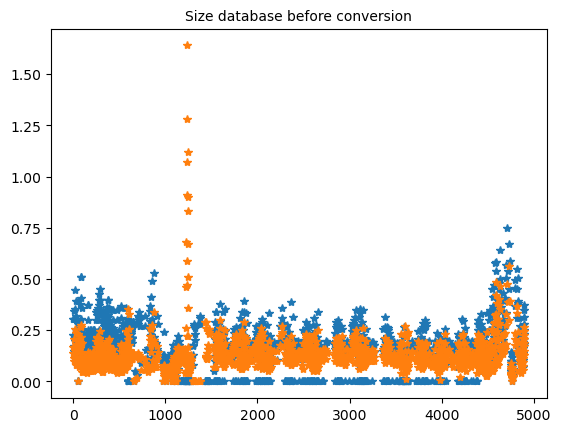

In [310]:
plt.title("Size database before conversion");
plt.plot(df["wmax"],"*",label="wmax");
plt.plot(df["wm"],"*",label="wm");

# Count number of zero wmwax (unknown)
print("umber of unknown max. crack widths",df[(df["wmax"] < tol) & (df["wm"] > tol) & (df["Lcons"] > filter_length)].shape)

# Counter number of zero wmax related to crack formation stage
print("Unknown maximum crack widths in CFS",df[(df["wmax"] < tol) & (df["wm"] > tol) & (df["CS"] == 1) & (df["Lcons"] > filter_length)].shape)

print("Unknown maximum crack widths in CFS - EPID18",df[(df["wmax"] < tol) & (df["wm"] > tol) & (df["CS"] == 1) & (df["Lcons"] > filter_length) &
      (df["EPID"] == 18)].shape)

# Counter number of zero wmax related to crack formation stage
print("Unknown maximum crack widths in SCS",df[(df["wmax"] < tol) & (df["wm"] > tol) & (df["CS"] == 2) & (df["Lcons"] > filter_length)].shape)

print("Unknown maximum crack widths in CFS - EPID18",df[(df["wmax"] < tol) & (df["wm"] > tol) & (df["CS"] == 2) & (df["Lcons"] > filter_length) &
      (df["EPID"] == 18)].shape)

In [311]:
df[(df["wmax"] < tol) & (df["wm"] > tol) & (df["CS"] == 1) & (df["Lcons"] > filter_length)];

,ID,EPID,ELID,LOADID,DOI,title,year,journal,country,institution,...,Aseff_SMTCM,Apeff_SMTCM,phi_eq_SMTCM,rhoeff_SMTCM,hceff_SMTCM,sumcirc_SMTCM,sumcirc_p_SMTCM,Actensstate1,Astensstate1,Aptensstate1
1219,1698,17,PS1,1,10.1061/(ASCE)0733-9445(1985)111:7(1602),Static and Fatigue Tests on Partially Prestres...,1985,Journal of Structural Engineering,United States,University of Michigan,...,0.000000,54.84,12.63324,0.002519,114.3,0.000000,39.688495,7636.825825,0.000000,0.0
1220,1699,17,PS1,2,10.1061/(ASCE)0733-9445(1985)111:7(1602),Static and Fatigue Tests on Partially Prestres...,1985,Journal of Structural Engineering,United States,University of Michigan,...,0.000000,54.84,12.63324,0.002519,114.3,0.000000,39.688495,7636.825825,0.000000,0.0
1431,1910,18,C115,8,https://doi.org/10.5075/epfl-thesis-666,Armature Minimale Pour Le Contrôle de la Fissu...,1987,0,Switzerland,École Polytechnique Fédérale de Lausanne,...,785.398163,0.00,10.00000,0.010134,77.5,314.159265,0.000000,127800.000000,785.398163,0.0
1438,1917,18,C116,7,https://doi.org/10.5075/epfl-thesis-666,Armature Minimale Pour Le Contrôle de la Fissu...,1987,0,Switzerland,École Polytechnique Fédérale de Lausanne,...,904.778684,0.00,12.00000,0.012032,80.0,301.592895,0.000000,127800.000000,904.778684,0.0
1440,1919,18,C116,9,https://doi.org/10.5075/epfl-thesis-666,Armature Minimale Pour Le Contrôle de la Fissu...,1987,0,Switzerland,École Polytechnique Fédérale de Lausanne,...,904.778684,0.00,12.00000,0.012032,80.0,301.592895,0.000000,127800.000000,904.778684,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4258,5542,19,S32-14-3,17,0,Rapport des essais: de tirants sous déformatio...,1993,0,Switzerland,École Polytechnique Fédérale de Lausanne,...,153.938040,0.00,14.00000,0.015394,50.0,43.982297,0.000000,10000.000000,153.938040,0.0
4261,5545,19,S32-14-3,8,0,Rapport des essais: de tirants sous déformatio...,1993,0,Switzerland,École Polytechnique Fédérale de Lausanne,...,153.938040,0.00,14.00000,0.015394,50.0,43.982297,0.000000,10000.000000,153.938040,0.0
4267,5551,19,S32-14-3,29,0,Rapport des essais: de tirants sous déformatio...,1993,0,Switzerland,École Polytechnique Fédérale de Lausanne,...,153.938040,0.00,14.00000,0.015394,50.0,43.982297,0.000000,10000.000000,153.938040,0.0
4311,5595,19,S32-20-2,28,0,Rapport des essais: de tirants sous déformatio...,1993,0,Switzerland,École Polytechnique Fédérale de Lausanne,...,314.159265,0.00,20.00000,0.031416,50.0,62.831853,0.000000,10000.000000,314.159265,0.0


1.2895276722107052


(0.0, 3.0)

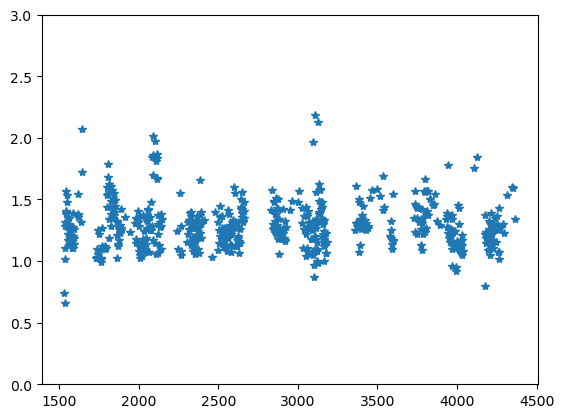

In [312]:
plt.plot(df[(df["EPID"] == 19) & (df["CS"] == 1) & (df["wmax"] > wmaxL) & (df["wm"] > wmaxL)]["wmax"] / df[(df["EPID"] == 19) & df["CS"] == 1 & (df["wmax"] > wmaxL) & (df["wm"] > wmaxL)]["wm"],"*")

print(np.mean(df[(df["EPID"] == 19) & (df["CS"] == 1) & (df["wmax"] > wmaxL) & (df["wm"] > wmaxL)]["wmax"] / df[(df["EPID"] == 19) & df["CS"] == 1 & (df["wmax"] > wmaxL) & (df["wm"] > wmaxL)]["wm"]))

plt.ylim(0,3)

In [314]:
def func_compute_rat_targ(data):

    r = np.zeros(data.shape[0]);
    p = np.zeros(data.shape[0]);
    k1 = np.zeros(data.shape[0]);
    

    for i in range(data.shape[0]):
        if data["epsin"].iloc[i] == str("1a"):
            k1[i] = data["N"].iloc[i]/data["Ncr"].iloc[i];
        else:
            k1[i] = data["M"].iloc[i]/data["Mcr"].iloc[i];

        #rho_tens = data["Astens"].iloc[i]/data["Ac"].iloc[i] + ((data["zeta1"].iloc[i]**2)*data["Aptens"].iloc[i]/data["Ac"].iloc[i]);
        rho_tens = data["Astensstate1"].iloc[i]/data["Actensstate1"].iloc[i] + \
            ((data["zeta1"].iloc[i]**2)*data["Aptensstate1"].iloc[i]/data["Actensstate1"].iloc[i]);
        
        #print(rho_tens);

        if data["CS"].iloc[i] == 2:
            r[i] = 1 - 0.5*np.sqrt(1-(1/k1[i])**(1 + 2.5/((rho_tens)*100)));
    
            p[i] = r[i]*(k1[i]-0.33*(3*r[i]-r[i]**2))/(k1[i]-0.67);
            
        elif data["CS"].iloc[i] == 1:
            r[i] = 1;
            p[i] = 1;
    
    return r,p,k1

### Impute common targets

In [315]:
def func_fill_empty_targets(data):

    w_max_imputed = np.zeros(data.shape[0]);
    w_m_imputed = np.zeros(data.shape[0]);
    s_max_imputed = np.zeros(data.shape[0]);
    s_m_imputed = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):

        # if the latter case is applicable: estimate the maximum crack width from the mean crack width: wmax = wm/p
        if data["wm"].iloc[i] > tol and data["wmax"].iloc[i] < tol:
            #w_max_imputed[i] = data["wm"].iloc[i]/data["p"].iloc[i];
            data["wmax"].iloc[i] = data["wm"].iloc[i]/data["p"].iloc[i];

        # wm = wmax*p
        elif data["wm"].iloc[i] < tol and data["wmax"].iloc[i] > tol:
            #w_m_imputed[i] = data["wmax"].iloc[i]*data["p"].iloc[i];
            data["wm"].iloc[i] = data["wmax"].iloc[i]*data["p"].iloc[i];
        
        # smax = sm/r
        if data["sm"].iloc[i] > tol and data["smax"].iloc[i] < tol:
            #s_max_imputed[i] = data["sm"].iloc[i]/data["r"].iloc[i];
            data["smax"].iloc[i] = data["sm"].iloc[i]/data["r"].iloc[i];

        # sm = smax*r
        elif data["sm"].iloc[i] < tol and data["smax"].iloc[i] > tol:
            #s_m_imputed[i] = data["smax"].iloc[i]*data["r"].iloc[i];
            data["sm"].iloc[i] = data["smax"].iloc[i]*data["r"].iloc[i];
    
    return data

In [316]:
if uniformtargets == "yes":
    
    df["r"],df["p"],df["k1"] = func_compute_rat_targ(df);
    df = df.astype({
        "r": "float",
        "p": "float",
        "k1": "float"
    });

else:
    df["r"] = np.zeros(df.shape[0]);
    df["p"] = np.zeros(df.shape[0]);
    df["k1"] = np.zeros(df.shape[0]);

### 0.5.15 - Filtering of secondary crack widths

In [318]:
def filter_secondary_crack_widths(data):

    start = time.time()
    sr_lower = np.zeros(data.shape[0]);
    srtemp = np.zeros(data.shape[0]);

    # EPIDs for which it is not clear if there are primary/secondary cracks
    genlist = [1,6,7,8,9,16,24,26,27,28,31];

    # EPIDs for which it is clear if there are primary/secondary cracks
    # In welke EPIDs kon visueel (of herleid via tekst) worden beoordeeld of er sprake is van primaire / secundaire scheuren?
    # 2,3,4,11,12,19,21,22,23,25,29,30

    # And after analysis
    # 10, 13, 15, 18, 20, 

    ele = data["ELID"].unique();
    
    for i in range(data.shape[0]):

        if data["EPID"].iloc[i] in genlist:
            sr_lower[i] = data["fctm"].iloc[i]*data["phi_eq_MC2020"].iloc[i] / (4*data["tau_bms"].iloc[i]*data["rhoeff_MC2020"].iloc[i]);
            sr_mintemp = np.zeros(ele.shape[0]);
    
            for j in range(ele.shape[0]):
                srtemplist = [];
                for i in range(data.shape[0]):
                    if ele[j] == data["ELID"].iloc[i]:
                        if data["sm"].iloc[i] > tol: # Computation in case of known mean crack widths
                            srtemplist.append(data["sm"].iloc[i])
                        elif data["smax"].iloc[i]*data["r"].iloc[i] > tol: # Computation in case of known maximum crack widths (to get mean ones)
                            srtemplist.append(data["smax"].iloc[i]*data["r"].iloc[i])
                if len(srtemplist) > 0:
                    sr_mintemp[j] = np.min(srtemplist);
                else: # Address empty arrays; thus without known spacings --> then not cancelled out, temporarily place a high value
                    sr_mintemp[j] = 1500; # High upper bound, so these will not be filtered out

    for i in range(data.shape[0]):
        if data["EPID"].iloc[i] in genlist:
            for j in range(ele.shape[0]):
                if ele[j] == data["ELID"].iloc[i]:
                    srtemp[i] = sr_mintemp[j];
        else:
            srtemp[i] = 1500; # High upper bound, so these will not be filtered out
            sr_lower[i] = data["fctm"].iloc[i]*data["phi_eq_MC2020"].iloc[i] / (4*data["tau_bms"].iloc[i]*data["rhoeff_MC2020"].iloc[i]);

    data["srtemp"] = srtemp;
    data["srlower"] = sr_lower;
    
    end = time.time()
    print("Elapsed time",end-start,"seconds");
    
    return data

In [319]:
# Finally, we can remove the rows with "too low crack spacings"
if exclude_secondary_cracks == "yes":
    df = filter_secondary_crack_widths(df);
    df = df.astype({
    "srtemp": "float",
    "srlower": "float"});
    df.drop(df[(df["srtemp"] < df["srlower"])].index, inplace=True); # Remove secondary crack widths

#### Filter for elements with small element lengths

In [321]:
df.drop(df[(df["Lcons"] <= filter_length)].index,inplace=True);
print(df.shape)

(1713, 212)


#### Plot of the extrapolation - before filling the empty targets

In [322]:
if uniformtargets == "yes":
    df = func_fill_empty_targets(df);
print(df.shape[0]);

1713


#### Filter on the concrete compression strength

In [323]:
df.drop(df[(df["fcm"] < fcmlower)].index, inplace=True);
print(df.shape[0]);

1713


#### Filter for outliers

In [324]:
if fitleroutliers == "yes":
    df.drop(df[(df["wm"] > wmaxU)].index, inplace=True);
    df.drop(df[(df["wmax"] > wmaxU)].index, inplace=True);
    df.drop(df[(df["wm"] < wmaxL)].index, inplace=True);
    df.drop(df[(df["wmax"] < wmaxL)].index, inplace=True);

    #if df["CS"] == 2: # The filter below is valid only in the CFS
    df.drop(df[(df["sm"] > smaxU) & (df["CS"] == 2)].index, inplace=True);
    df.drop(df[(df["smax"] > smaxU) & (df["CS"] == 2)].index, inplace=True);
    #df.drop(df[(df["sm"] > smaxU)].index, inplace=True);
    #df.drop(df[(df["smax"] > smaxU)].index, inplace=True);

print(df.shape[0]);

1293


#### Plot of the extrapolation - after filling the empty targets

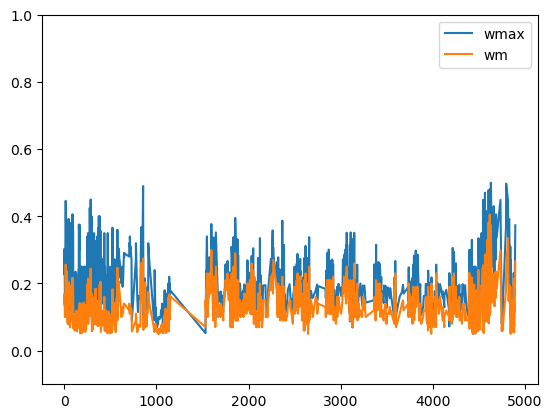

In [325]:
plt.plot(df["wmax"],label="wmax");
plt.plot(df["wm"],label="wm");
plt.legend();
plt.ylim([-0.1,1]);

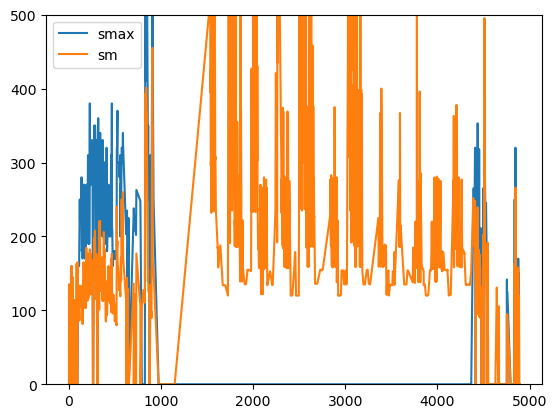

In [326]:
plt.plot(df["smax"],label="smax");
plt.plot(df["sm"],label="sm");
plt.legend();
plt.ylim([0,500]);

### Temporarily - generate pictures with effect of common targets

In [ ]:

def func_plot_common_targets_w_V3_CFS(data):
    fig,ax = plt.subplots(nrows = 1,ncols = 4,figsize=(10,4),gridspec_kw = {"width_ratios": [3,1,3,1]});

    fig.suptitle("Conversion factors for uniform crack widths and spacings")
    
    ax1 = ax[0];
    ax2 = ax[1];
    ax3 = ax[2];
    ax4 = ax[3];
    
    # Plot figure - w
    datatemp_w = data[(data["wm"] > tol) & (data["wmax"] > tol) & (data["sm"] > tol) & (data["smax"] > tol) & (data["Aptot"] < tol) & (data["CS"] == 1)];
    r,p,k1 = func_compute_rat_targ(datatemp_w);

    #ax1.figure();
    ax1.plot(k1,1/p,"ob",mfc="none",zorder=10,label=r"$\beta_{\rm w}$ - Theoretical");
    ax1.plot(k1,datatemp_w["wmax"]/datatemp_w["wm"],"ro",mfc="none",label=r"$\beta_{\rm w}$ - Based on data");
    
    ax1.set_xlabel(r"$k_1$ = $\sigma_{\rm s}$/$\sigma_{\rm s,r}$");
    ax1.set_ylabel(r"$\beta_{\rm w} = w_{\rm max} / w_{\rm m}$");
    ax1.set_xlim([0,14]);
    ax1.set_ylim([0.75,3.5]);
    ax1.grid(axis="y");
    ax1.set_title("$\\bf{(a)}$ Crack widths")

    diff = 1/p - datatemp_w["wmax"]/datatemp_w["wm"]
    bx2 = ax2.boxplot(diff,patch_artist=True);
    for err,patch_box,patch_flier,patch_med,col in zip(diff,bx2["boxes"], bx2["fliers"],bx2["medians"],"silver"):
        patch_box.set_facecolor("silver");
        patch_med.set_color("k")
        patch_flier.set_markerfacecolor("silver")

    #ax2.violinplot(diff);
    
    ax2.set_ylabel(r"$\beta_{\rm w,cal}$ - $\beta_{\rm w,exp}$")
    ax2.set_xlim([0,2]);
    ax2.set_ylim([-2,2]);
    ax2.grid(axis="y");
    ax2.set_xticks([])

    ax2.plot([2.4, 2.4], [-2.5, 2.2], color='k', lw=2,
          clip_on=False)
    
    print("Median - wmax",np.median(diff));
    print("Q3 - wmax",np.percentile(diff,75));
    print("Q1 - wmax",np.percentile(diff,25));
    print("IQR - wmax",np.percentile(diff,75) - np.percentile(diff,25));
    
    # Plot figure - s
    datatemp_s = data[(data["wm"] > tol) & (data["wmax"] > tol) & (data["sm"] > tol) & (data["smax"] > tol) & (data["Aptot"] < tol) & (data["CS"] == 1)];
    r,p,k1 = func_compute_rat_targ(datatemp_w);

    ax3.plot(k1,1/r,"ob",mfc="none",zorder=10,label=r"$\beta_{\rm s,r}$ - Theoretical");
    ax3.plot(k1,datatemp_s["smax"]/datatemp_s["sm"],"ro",mfc="none",label=r"$\beta_{\rm s,r}$ - Based on data");
    
    ax3.set_xlabel(r"$k_1$ = $\sigma_{\rm s}$/$\sigma_{\rm s,r}$");
    ax3.set_ylabel(r"$\beta_{\rm s,r} = s_{\rm r,max}$ / $s_{\rm r,m}$");
    ax3.set_xlim([0,14]);
    ax3.set_ylim([0.75,3.5]);
    ax3.grid(axis="y");
    ax3.set_title("$\\bf{(b)}$ Crack spacings")

    #ax2.figure();
    diff = 1/r - datatemp_s["smax"]/datatemp_s["sm"]
    bx4 = ax4.boxplot(diff,patch_artist=True)
    for err,patch_box,patch_flier,patch_med,col in zip(diff,bx4["boxes"], bx4["fliers"],bx4["medians"],"silver"):
        patch_box.set_facecolor("silver");
        patch_med.set_color("k")
        patch_flier.set_markerfacecolor("silver")

    #ax4.violinplot(diff)
    
    ax4.set_ylabel(r"$\beta_{\rm s,r,cal}$ - $\beta_{\rm s,r,exp}$")
    ax4.set_xlim([0,2]);
    ax4.set_ylim([-2,2]);
    ax4.grid(axis="y");
    ax4.set_xticks([])

    #ax1.text(-3,0.3,"(a)");
    #ax3.text(-3,0.3,"(b)");
    
    print("Median - srmax",np.median(diff));
    print("Q3 - srmax",np.percentile(diff,75));
    print("Q1 - srmax",np.percentile(diff,25));
    print("IQR - srmax",np.percentile(diff,75) - np.percentile(diff,25));

    # LEGEND
    # ========================================================
    legend_elements = [Line2D([0], [0], color='blue', lw=6, label=r"$\beta$ - Calculated (cal)",marker="o",linestyle="none"),
                       Line2D([0], [0], color='red', lw=6, label=r"$\beta$ - Based on data (exp)",marker="o",linestyle="none")
                      ];
    fig.legend(handles=legend_elements, loc="lower center",ncol=2,bbox_to_anchor=(1/2,-0.08));
    fig.tight_layout();

    plt.savefig(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Figures\SVG\conv_ratios_CFS.svg",bbox_inches='tight');


In [ ]:

def func_plot_common_targets_w_V3_SCS(data):
    fig,ax = plt.subplots(nrows = 1,ncols = 4,figsize=(10,4),gridspec_kw = {"width_ratios": [3,1,3,1]});

    fig.suptitle("Conversion factors for uniform crack widths and spacings")
    
    ax1 = ax[0];
    ax2 = ax[1];
    ax3 = ax[2];
    ax4 = ax[3];
    
    # Plot figure - w
    datatemp_w = data[(data["wm"] > tol) & (data["wmax"] > tol) & (data["sm"] > tol) & (data["smax"] > tol) & (data["Aptot"] < tol) & (data["CS"] == 2)];
    r,p,k1 = func_compute_rat_targ(datatemp_w);

    #ax1.figure();
    ax1.plot(k1,1/p,"ob",mfc="none",zorder=10,label=r"$\beta_{\rm w}$ - Theoretical");
    ax1.plot(k1,datatemp_w["wmax"]/datatemp_w["wm"],"ro",mfc="none",label=r"$\beta_{\rm w}$ - Based on data");
    
    ax1.set_xlabel(r"$k_1$ = $\sigma_{\rm s}$/$\sigma_{\rm s,r}$");
    ax1.set_ylabel(r"$\beta_{\rm w} = w_{\rm max} / w_{\rm m}$");
    ax1.set_xlim([0,14]);
    ax1.set_ylim([0.75,3.5]);
    ax1.grid(axis="y");
    ax1.set_title("$\\bf{(a)}$ Crack widths")

    diff = 1/p - datatemp_w["wmax"]/datatemp_w["wm"]
    bx2 = ax2.boxplot(diff,patch_artist=True);
    for err,patch_box,patch_flier,patch_med,col in zip(diff,bx2["boxes"], bx2["fliers"],bx2["medians"],"silver"):
        patch_box.set_facecolor("silver");
        patch_med.set_color("k")
        patch_flier.set_markerfacecolor("silver")

    #ax2.violinplot(diff);
    
    ax2.set_ylabel(r"$\beta_{\rm w,cal}$ - $\beta_{\rm w,exp}$")
    ax2.set_xlim([0,2]);
    ax2.set_ylim([-2,2]);
    ax2.grid(axis="y");
    ax2.set_xticks([])

    ax2.plot([2.4, 2.4], [-2.5, 2.2], color='k', lw=2,
          clip_on=False)
    
    print("Median - wmax",np.median(diff));
    print("Q3 - wmax",np.percentile(diff,75));
    print("Q1 - wmax",np.percentile(diff,25));
    print("IQR - wmax",np.percentile(diff,75) - np.percentile(diff,25));
    
    # Plot figure - s
    datatemp_s = data[(data["wm"] > tol) & (data["wmax"] > tol) & (data["sm"] > tol) & (data["smax"] > tol) & (data["Aptot"] < tol) & (data["CS"] == 2)];
    r,p,k1 = func_compute_rat_targ(datatemp_w);

    ax3.plot(k1,1/r,"ob",mfc="none",zorder=10,label=r"$\beta_{\rm s,r}$ - Theoretical");
    ax3.plot(k1,datatemp_s["smax"]/datatemp_s["sm"],"ro",mfc="none",label=r"$\beta_{\rm s,r}$ - Based on data");
    
    ax3.set_xlabel(r"$k_1$ = $\sigma_{\rm s}$/$\sigma_{\rm s,r}$");
    ax3.set_ylabel(r"$\beta_{\rm s,r} = s_{\rm r,max}$ / $s_{\rm r,m}$");
    ax3.set_xlim([0,14]);
    ax3.set_ylim([0.75,3.5]);
    ax3.grid(axis="y");
    ax3.set_title("$\\bf{(b)}$ Crack spacings")

    #ax2.figure();
    diff = 1/r - datatemp_s["smax"]/datatemp_s["sm"]
    bx4 = ax4.boxplot(diff,patch_artist=True)
    for err,patch_box,patch_flier,patch_med,col in zip(diff,bx4["boxes"], bx4["fliers"],bx4["medians"],"silver"):
        patch_box.set_facecolor("silver");
        patch_med.set_color("k")
        patch_flier.set_markerfacecolor("silver")

    #ax4.violinplot(diff)
    
    ax4.set_ylabel(r"$\beta_{\rm s,r,cal}$ - $\beta_{\rm s,r,exp}$")
    ax4.set_xlim([0,2]);
    ax4.set_ylim([-2,2]);
    ax4.grid(axis="y");
    ax4.set_xticks([])

    #ax1.text(-3,0.3,"(a)");
    #ax3.text(-3,0.3,"(b)");
    
    print("Median - srmax",np.median(diff));
    print("Q3 - srmax",np.percentile(diff,75));
    print("Q1 - srmax",np.percentile(diff,25));
    print("IQR - srmax",np.percentile(diff,75) - np.percentile(diff,25));

    # LEGEND
    # ========================================================
    legend_elements = [Line2D([0], [0], color='blue', lw=6, label=r"$\beta$ - Calculated (cal)",marker="o",linestyle="none"),
                       Line2D([0], [0], color='red', lw=6, label=r"$\beta$ - Based on data (exp)",marker="o",linestyle="none")
                      ];
    fig.legend(handles=legend_elements, loc="lower center",ncol=2,bbox_to_anchor=(1/2,-0.08));
    fig.tight_layout();

    plt.savefig(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Figures\SVG\conv_ratios_SCS.svg",bbox_inches='tight');


In [ ]:
# Plot for SCS!
#func_plot_common_targets_w_V3_CFS(df);

In [ ]:
# Plot for SCS!
#func_plot_common_targets_w_V3_SCS(df);

### Temporarily - generate pictures with effect extrapolation

In [ ]:

def func_plot_locs_both_represented_V2(data):

    fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize=(8,4),gridspec_kw = {"width_ratios": [3,1]});
    ax1 = ax[0];
    ax2 = ax[1];
    
    uniqueEPID = list(dict.fromkeys(data["ELID"]));
    
    orgEPIDlist = ["R49","R23","R24","R28","R20","R33","R29","R34","R35","R37","R25","R26","R50","R18","R19","R54",
            "R61","R70","R66","R67","R65","R21","R17",
            "T13","T20","T39","T29","T27","T21","T12","T16",
            "25-20-00","25-20-10","25-20-30","12-20-00","12-20-10","12-20-30","25-70-00","25-70-10",
            "25-70-30","12-70-00","12-70-10","12-70-30"];

    uniqueEPID.remove("T20"); uniqueEPID.remove("25-70-30");
    orgEPIDlist.remove("T20"); orgEPIDlist.remove("25-70-30");
    
    EPIDlist = [i for i in orgEPIDlist if i in uniqueEPID];
    
    meanrat_w = np.zeros(len(EPIDlist));
    extrapolrat = np.zeros(len(EPIDlist));
    
    for i in range(len(EPIDlist)):
        dfloc_1 = data.loc[(df["ELID"] == EPIDlist[i]) & (data["locw"] == 1) ];
        dfloc_2 = data.loc[(df["ELID"] == EPIDlist[i]) & (data["locw"] == 2) ];
        
        meanrat_w[i] = np.nanmean(dfloc_2["wm"])/np.nanmean(dfloc_1["wm"]);
        
        extrapolrat[i] = np.nanmean((dfloc_1["h"]-dfloc_1["xc"]))/np.nanmean((dfloc_1["h"]-dfloc_1["ry"]-dfloc_1["xc"]));

    extrapolrat[~np.isfinite(extrapolrat)] = np.nan;

    ax1.plot(EPIDlist,extrapolrat,"bo",mfc="none",label=r"$\kappa_{\rm 1/r}$ - Calculated (cal)");
    ax1.axhline(y=np.nanmean(extrapolrat),linestyle="--",color="b");
    
    ax1.plot(EPIDlist,meanrat_w,"ro",mfc="none",label=r"$\kappa_{1/ \rm r}$ - Based on data (exp)");
    ax1.axhline(y=np.nanmean(meanrat_w),linestyle="--",color="r");

    
    ax1.set_ylim([0.75,1.5]);
    
    ax1.set_ylabel(r"$k_{\rm 1/r}$");
    ax1.grid(axis="y");
    ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=60, ha='right')
    
    print(np.mean(extrapolrat))
    print(np.mean(meanrat_w))

    
    diff = extrapolrat-meanrat_w
    bx2 = ax2.boxplot(diff,patch_artist=True);
    for err,patch_box,patch_flier,patch_med,col in zip(diff,bx2["boxes"], bx2["fliers"],bx2["medians"],"silver"):
        patch_box.set_facecolor("silver");
        patch_med.set_color("k")
        patch_flier.set_markerfacecolor("silver")

    
    ax2.set_ylabel(r"$k_{\rm 1/r,th}$ - $\kappa_{\rm 1/r,exp}$")
    ax2.set_xlim([0,2]);
    ax2.set_ylim([-0.5,0.5]);
    ax2.grid(axis="y");
    ax2.set_xticks([])

    fig.tight_layout();
    plt.savefig(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Figures\SVG\curv_factor.svg",bbox_inches='tight');


## 6 - Export database

#### Shape

In [ ]:
print("Working Dataset contains",df.shape[0], "rows")
print("Working Dataset contains",df.shape[1], "columns")

#### Export - with filtering secondary cracks and with uniform targets

In [333]:
if exclude_secondary_cracks == "yes" and uniformtargets == "yes":

    if hordijksigs == "yes" and includeinitshrinkage == "no":
        # Case: hordijk, no initial shrinkage
        df.to_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\filt_2nd\uniform\Working_database_hordijk_no_initshrink.csv"));
        !!jupyter nbconvert Data_processing_V1.ipynb --to HTML
        os.rename("Data_processing_V1.html",Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\filt_2nd\uniform\Working_database_hordijk_no_initshrink.html"));
    
    elif hordijksigs == "no" and includeinitshrinkage == "no":
        # Case: no hordijk, no initial shrinkage
        df.to_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\filt_2nd\uniform\Working_database_no_hordijk_no_initshrink.csv"));
        !!jupyter nbconvert Data_processing_V1.ipynb --to HTML
        os.rename("Data_processing_V1.html",Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\filt_2nd\uniform\Working_database_no_hordijk_no_initshrink.html"));
    
    elif hordijksigs == "yes" and includeinitshrinkage == "yes":
        # Case: hordijk, initial shrinkage
        df.to_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\filt_2nd\uniform\Working_database_hordijk_initshrink.csv"));
        !!jupyter nbconvert Data_processing_V1.ipynb --to HTML
        os.rename("Data_processing_V1.html",Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\filt_2nd\uniform\Working_database_hordijk_initshrink.html"));
    
    elif hordijksigs == "no" and includeinitshrinkage == "yes":
        # Case: no hordijk, initial shrinkage
        df.to_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\filt_2nd\uniform\Working_database_no_hordijk_initshrink.csv"));
        !!jupyter nbconvert Data_processing_V1.ipynb --to HTML
        os.rename("Data_processing_V1.html",Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\filt_2nd\uniform\Working_database_no_hordijk_initshrink.html"));

#### Export - with filtering secondary cracks and no uniform targets

In [334]:
if exclude_secondary_cracks == "yes" and uniformtargets == "no":

    if hordijksigs == "yes" and includeinitshrinkage == "no":
        # Case: hordijk, no initial shrinkage
        df.to_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\filt_2nd\no_uniform\Working_database_hordijk_no_initshrink.csv"));
        !!jupyter nbconvert Data_processing_V1.ipynb --to HTML
        os.rename("Data_processing_V1.html",Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\filt_2nd\no_uniform\Working_database_hordijk_no_initshrink.html"));
    
    elif hordijksigs == "no" and includeinitshrinkage == "no":
        # Case: no hordijk, no initial shrinkage
        df.to_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\filt_2nd\no_uniform\Working_database_no_hordijk_no_initshrink.csv"));
        !!jupyter nbconvert Data_processing_V1.ipynb --to HTML
        os.rename("Data_processing_V1.html",Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\filt_2nd\no_uniform\Working_database_no_hordijk_no_initshrink.html"));
    
    elif hordijksigs == "yes" and includeinitshrinkage == "yes":
        # Case: hordijk, initial shrinkage
        df.to_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\filt_2nd\no_uniform\Working_database_hordijk_initshrink.csv"));
        !!jupyter nbconvert Data_processing_V1.ipynb --to HTML
        os.rename("Data_processing_V1.html",Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\filt_2nd\no_uniform\Working_database_hordijk_initshrink.html"));
    
    elif hordijksigs == "no" and includeinitshrinkage == "yes":
        # Case: no hordijk, initial shrinkage
        df.to_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\filt_2nd\no_uniform\Working_database_no_hordijk_initshrink.csv"));
        !!jupyter nbconvert Data_processing_V1.ipynb --to HTML
        os.rename("Data_processing_V1.html",Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\filt_2nd\no_uniform\Working_database_no_hordijk_initshrink.html"));

#### Export - without filtering secondary cracks and with uniform targets

In [335]:
if exclude_secondary_cracks == "no" and uniformtargets == "yes":

    if hordijksigs == "yes" and includeinitshrinkage == "no":
        # Case: hordijk, no initial shrinkage
        df.to_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\no_filt_2nd\uniform\Working_database_hordijk_no_initshrink.csv"));
        !!jupyter nbconvert Data_processing_V1.ipynb --to HTML
        os.rename("Data_processing_V1.html",Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\no_filt_2nd\uniform\Working_database_hordijk_no_initshrink.html"));
    
    elif hordijksigs == "no" and includeinitshrinkage == "no":
        # Case: no hordijk, no initial shrinkage
        df.to_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\no_filt_2nd\uniform\Working_database_no_hordijk_no_initshrink.csv"));
        !!jupyter nbconvert Data_processing_V1.ipynb --to HTML
        os.rename("Data_processing_V1.html",Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\no_filt_2nd\uniform\Working_database_no_hordijk_no_initshrink.html"));
    
    elif hordijksigs == "yes" and includeinitshrinkage == "yes":
        # Case: hordijk, initial shrinkage
        df.to_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\no_filt_2nd\uniform\Working_database_hordijk_initshrink.csv"));
        !!jupyter nbconvert Data_processing_V1.ipynb --to HTML
        os.rename("Data_processing_V1.html",Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\no_filt_2nd\uniform\Working_database_hordijk_initshrink.html"));
    
    elif hordijksigs == "no" and includeinitshrinkage == "yes":
        # Case: no hordijk, initial shrinkage
        df.to_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\no_filt_2nd\uniform\Working_database_no_hordijk_initshrink.csv"));
        !!jupyter nbconvert Data_processing_V1.ipynb --to HTML
        os.rename("Data_processing_V1.html",Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\no_filt_2nd\uniform\Working_database_no_hordijk_initshrink.html"));

#### Export - without filtering secondary cracks and without uniform targets

In [336]:
if exclude_secondary_cracks == "no" and uniformtargets == "no":

    if hordijksigs == "yes" and includeinitshrinkage == "no":
        # Case: hordijk, no initial shrinkage
        df.to_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\no_filt_2nd\no_uniform\Working_database_hordijk_no_initshrink.csv"));
        !!jupyter nbconvert Data_processing_V1.ipynb --to HTML
        os.rename("Data_processing_V1.html",Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\no_filt_2nd\no_uniform\Working_database_hordijk_no_initshrink.html"));
    
    elif hordijksigs == "no" and includeinitshrinkage == "no":
        # Case: no hordijk, no initial shrinkage
        df.to_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\no_filt_2nd\no_uniform\Working_database_no_hordijk_no_initshrink.csv"));
        !!jupyter nbconvert Data_processing_V1.ipynb --to HTML
        os.rename("Data_processing_V1.html",Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\no_filt_2nd\no_uniform\Working_database_no_hordijk_no_initshrink.html"));
    
    elif hordijksigs == "yes" and includeinitshrinkage == "yes":
        # Case: hordijk, initial shrinkage
        df.to_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\no_filt_2nd\no_uniform\Working_database_hordijk_initshrink.csv"));
        !!jupyter nbconvert Data_processing_V1.ipynb --to HTML
        os.rename("Data_processing_V1.html",Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\no_filt_2nd\no_uniform\Working_database_hordijk_initshrink.html"));
    
    elif hordijksigs == "no" and includeinitshrinkage == "yes":
        # Case: no hordijk, initial shrinkage
        df.to_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\no_filt_2nd\no_uniform\Working_database_no_hordijk_initshrink.csv"));
        !!jupyter nbconvert Data_processing_V1.ipynb --to HTML
        os.rename("Data_processing_V1.html",Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\no_filt_2nd\no_uniform\Working_database_no_hordijk_initshrink.html"));

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'Data_processing_V1.html' -> 'C:\\Users\\20210065\\OneDrive - TU Eindhoven\\60_Publications\\1_st_Journal_Paper\\Jupyter_Notebook\\Data_exported\\no_filt_2nd\\no_uniform\\Working_database_no_hordijk_no_initshrink.html'